In [ ]:
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import roc_auc_score
import numpy as np
import os
from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
source_path = Path("/content/drive/MyDrive/prior dataset/spectrograms_output/")

pytorch_data_path = Path("/content/drive/MyDrive/prior dataset/pytorch_color_data/")

print(f"Preparing data for PyTorch ImageFolder...")
print(f"New directory will be at: {pytorch_data_path}")

if pytorch_data_path.exists():
    print("Removing old PyTorch data directory.")
    shutil.rmtree(pytorch_data_path)

try:
    for class_dir in source_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            color_dir = class_dir / 'color'

            if color_dir.exists():
                target_class_dir = pytorch_data_path / class_name
                target_class_dir.mkdir(parents=True, exist_ok=True)

                for img_file in color_dir.glob('*.jpg'):
                    shutil.copy(img_file, target_class_dir)

    print("Data reorganization complete!")

except Exception as e:
    print(f"An error occurred: {e}")

Preparing data for PyTorch ImageFolder...
New directory will be at: /content/drive/MyDrive/prior dataset/pytorch_color_data
Removing old PyTorch data directory.
Data reorganization complete!


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

DATA_DIR = Path("/content/drive/MyDrive/prior dataset/pytorch_color_data/")
CHECKPOINT_DIR = Path("./model_checkpoints_color/")
CHECKPOINT_DIR.mkdir(exist_ok=True)

LEARNING_RATE = 0.001
BATCH_SIZE = 4
NUM_REPETITIONS = 5
SPLIT_RATIO = [0.7, 0.3]
INPUT_SIZE = 299
NUM_EPOCHS = 20
LR_FINETUNE = 1e-5
LR_HEAD = 1e-3

data_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    full_dataset = ImageFolder(DATA_DIR, transform=data_transforms)
    print(f"Found {len(full_dataset)} images in {len(full_dataset.classes)} classes.")
    print(f"Classes: {full_dataset.class_to_idx}")
except FileNotFoundError:
    print(f"ERROR: Data directory not found at {DATA_DIR}")
    full_dataset = None

def create_inception_v3_model():
    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    for name, child in model.named_children():
        if name in ['Mixed_7a', 'Mixed_7b', 'Mixed_7c']:
            print(f"Unfreezing layer: {name}")
            for param in child.parameters():
                param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.BatchNorm1d(num_ftrs),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 2)
    )
    model.AuxLogits = None
    return model

def train_model(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)

        if isinstance(outputs, tuple):
            main_outputs = outputs[0]
        else:
            main_outputs = outputs

        loss = criterion(main_outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate_model(model, test_loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return roc_auc_score(all_labels, all_probs)

if full_dataset:
    all_auc_scores = []
    for run in range(NUM_REPETITIONS):
        print("-" * 50)
        print(f"Starting Run {run + 1}/{NUM_REPETITIONS}")

        train_size = int(SPLIT_RATIO[0] * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

        model = create_inception_v3_model().to(DEVICE)

        params_to_update = [
            {'params': [p for name, p in model.named_parameters() if "fc" not in name and p.requires_grad], 'lr': LR_FINETUNE},
            {'params': model.fc.parameters(), 'lr': LR_HEAD}
        ]

        optimizer = optim.Adam(params_to_update)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(NUM_EPOCHS):
            train_loss = train_model(model, train_loader, criterion, optimizer, epoch)

            print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}")

        auc = evaluate_model(model, test_loader)
        all_auc_scores.append(auc)
        print(f"Run {run + 1} complete. Test AUC: {auc:.4f}")

        checkpoint_path = CHECKPOINT_DIR / f"model_run_{run+1:03d}.pth"
        torch.save(model.state_dict(), checkpoint_path)

    mean_auc = np.mean(all_auc_scores)
    std_auc = np.std(all_auc_scores)

    print("FINAL RESULTS")
    print(f"Completed {NUM_REPETITIONS} training and testing runs.")
    print(f"Mean AUC: {mean_auc:.4f}")
    print(f"Standard Deviation of AUC: {std_auc:.4f}")

Using device: cuda
Found 81 images in 2 classes.
Classes: {'HC_AH': 0, 'PD_AH': 1}
--------------------------------------------------
Starting Run 1/5
Unfreezing layer: Mixed_7a
Unfreezing layer: Mixed_7b
Unfreezing layer: Mixed_7c


Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.7818


Epoch 2/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.6563


Epoch 3/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.7771


Epoch 4/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.5576


Epoch 5/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.5651


Epoch 6/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.5722


Epoch 7/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.5541


Epoch 8/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.5656


Epoch 9/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.4514


Epoch 10/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.6445


Epoch 11/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.3686


Epoch 12/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.4698


Epoch 13/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.4011


Epoch 14/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.5115


Epoch 15/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.4386


Epoch 16/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.5412


Epoch 17/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.4632


Epoch 18/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.3405


Epoch 19/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.5593


Epoch 20/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.5345
Run 1 complete. Test AUC: 0.7922
--------------------------------------------------
Starting Run 2/5
Unfreezing layer: Mixed_7a
Unfreezing layer: Mixed_7b
Unfreezing layer: Mixed_7c


Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.7358


Epoch 2/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.7424


Epoch 3/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.6967


Epoch 4/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.6478


Epoch 5/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.4934


Epoch 6/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.6752


Epoch 7/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.5407


Epoch 8/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.4347


Epoch 9/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.5732


Epoch 10/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.5960


Epoch 11/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.4494


Epoch 12/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.4982


Epoch 13/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.3347


Epoch 14/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.2930


Epoch 15/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.5663


Epoch 16/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.3536


Epoch 17/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.3298


Epoch 18/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.4054


Epoch 19/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.3972


Epoch 20/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.3048
Run 2 complete. Test AUC: 0.8205
--------------------------------------------------
Starting Run 3/5
Unfreezing layer: Mixed_7a
Unfreezing layer: Mixed_7b
Unfreezing layer: Mixed_7c


Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.7758


Epoch 2/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.6521


Epoch 3/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.5528


Epoch 4/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.5691


Epoch 5/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.6347


Epoch 6/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.6430


Epoch 7/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.5992


Epoch 8/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.5480


Epoch 9/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.5255


Epoch 10/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.4152


Epoch 11/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.4992


Epoch 12/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.3057


Epoch 13/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.3316


Epoch 14/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.4521


Epoch 15/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.5088


Epoch 16/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.3743


Epoch 17/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.4882


Epoch 18/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.3528


Epoch 19/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.4680


Epoch 20/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.3056
Run 3 complete. Test AUC: 0.7179
--------------------------------------------------
Starting Run 4/5
Unfreezing layer: Mixed_7a
Unfreezing layer: Mixed_7b
Unfreezing layer: Mixed_7c


Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.7673


Epoch 2/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.6447


Epoch 3/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.6895


Epoch 4/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.7049


Epoch 5/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.6128


Epoch 6/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.7359


Epoch 7/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.4872


Epoch 8/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.6338


Epoch 9/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.6042


Epoch 10/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.3424


Epoch 11/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.4280


Epoch 12/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.3820


Epoch 13/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.4209


Epoch 14/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.3768


Epoch 15/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.4749


Epoch 16/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.3636


Epoch 17/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.4455


Epoch 18/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.3095


Epoch 19/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.2702


Epoch 20/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.3162
Run 4 complete. Test AUC: 0.8077
--------------------------------------------------
Starting Run 5/5
Unfreezing layer: Mixed_7a
Unfreezing layer: Mixed_7b
Unfreezing layer: Mixed_7c


Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.7288


Epoch 2/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.5597


Epoch 3/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.5813


Epoch 4/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.6041


Epoch 5/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.5911


Epoch 6/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.6268


Epoch 7/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.5904


Epoch 8/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.5522


Epoch 9/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.4352


Epoch 10/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.5416


Epoch 11/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.3756


Epoch 12/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.5290


Epoch 13/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.5031


Epoch 14/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.5557


Epoch 15/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.3829


Epoch 16/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.4443


Epoch 17/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.4992


Epoch 18/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.2356


Epoch 19/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.4869


Epoch 20/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.5027
Run 5 complete. Test AUC: 0.7917
FINAL RESULTS
Completed 5 training and testing runs.
Mean AUC: 0.7860
Standard Deviation of AUC: 0.0357


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import random
from pathlib import Path
from tqdm.notebook import tqdm

# --- 1. CONFIGURATION AND SEEDING ---
# Set seed for reproducibility, as in the example
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

DATA_DIR = Path("/content/drive/MyDrive/prior dataset/pytorch_color_data/")
INPUT_SIZE = 299

learning_rates = [1e-3, 5e-4]
dropout_rates = [0.3, 0.5]
LR_FINETUNE = 1e-5

N_SPLITS = 5
NUM_EPOCHS = 15

data_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = ImageFolder(DATA_DIR, transform=data_transforms)
print(f"Found {len(full_dataset)} images in {len(full_dataset.classes)} classes.")

def create_inception_v3_model(dropout_rate=0.5):
    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    for name, child in model.named_children():
        if name in ['Mixed_7a', 'Mixed_7b', 'Mixed_7c']:
            for param in child.parameters():
                param.requires_grad = True
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(
        nn.BatchNorm1d(num_ftrs),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(512, 2)
    )
    model.AuxLogits = None
    return model

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        if isinstance(outputs, torch.Tensor): main_outputs = outputs
        else: main_outputs = outputs.logits
        loss = criterion(main_outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    if len(np.unique(all_labels)) < 2: return 0.5
    return roc_auc_score(all_labels, all_probs)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

best_mean_auc = 0.0
best_params = {}

for lr in learning_rates:
    for dp in dropout_rates:
        print("-" * 60)
        print(f"Testing: Head LR = {lr}, Dropout = {dp}")
        fold_auc_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_dataset)))):
            print(f"  --- Fold {fold + 1}/{N_SPLITS} ---")

            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(
                train_subset,
                batch_size=4,
                shuffle=True,
                num_workers=2,
                drop_last=True
            )

            val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2)


            model = create_inception_v3_model(dropout_rate=dp).to(DEVICE)
            params_to_update = [
                {'params': [p for name, p in model.named_parameters() if "fc" not in name and p.requires_grad], 'lr': LR_FINETUNE},
                {'params': model.fc.parameters(), 'lr': lr}
            ]
            optimizer = optim.Adam(params_to_update)
            criterion = nn.CrossEntropyLoss()

            for epoch in range(NUM_EPOCHS):
                train_epoch(model, train_loader, criterion, optimizer)

            val_auc = evaluate_model(model, val_loader)
            fold_auc_scores.append(val_auc)
            print(f"  Fold {fold + 1} Validation AUC: {val_auc:.4f}")

        mean_auc = np.mean(fold_auc_scores)
        print(f"\n  -> Mean AUC for Head LR={lr}, Dropout={dp}: {mean_auc:.4f}\n")

        if mean_auc > best_mean_auc:
            best_mean_auc = mean_auc
            best_params = {'learning_rate': lr, 'dropout_rate': dp}

print("HYPERPARAMETER SEARCH COMPLETE")
print(f"Best Mean AUC: {best_mean_auc:.4f}")
print(f"Achieved with parameters: {best_params}")

Using device: cuda
Found 81 images in 2 classes.
------------------------------------------------------------
Testing: Head LR = 0.001, Dropout = 0.3
  --- Fold 1/5 ---
  Fold 1 Validation AUC: 0.8788
  --- Fold 2/5 ---
  Fold 2 Validation AUC: 0.6032
  --- Fold 3/5 ---
  Fold 3 Validation AUC: 0.7937
  --- Fold 4/5 ---
  Fold 4 Validation AUC: 0.8333
  --- Fold 5/5 ---
  Fold 5 Validation AUC: 0.5938

  -> Mean AUC for Head LR=0.001, Dropout=0.3: 0.7405

------------------------------------------------------------
Testing: Head LR = 0.001, Dropout = 0.5
  --- Fold 1/5 ---
  Fold 1 Validation AUC: 0.9545
  --- Fold 2/5 ---
  Fold 2 Validation AUC: 0.6667
  --- Fold 3/5 ---
  Fold 3 Validation AUC: 0.6508
  --- Fold 4/5 ---
  Fold 4 Validation AUC: 0.7667
  --- Fold 5/5 ---
  Fold 5 Validation AUC: 0.6562

  -> Mean AUC for Head LR=0.001, Dropout=0.5: 0.7390

------------------------------------------------------------
Testing: Head LR = 0.0005, Dropout = 0.3
  --- Fold 1/5 ---
  Fold 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import random
from pathlib import Path

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

DATA_DIR = Path("/content/drive/MyDrive/prior dataset/pytorch_color_data/")
INPUT_SIZE = 299

learning_rates = [1e-3, 5e-4]
dropout_rates = [0.3, 0.5]

N_SPLITS = 5
NUM_EPOCHS = 20

data_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = ImageFolder(DATA_DIR, transform=data_transforms)
print(f"Found {len(full_dataset)} images in {len(full_dataset.classes)} classes.")

class FlatteningDNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.5):
        super(FlatteningDNN, self).__init__()
        self.input_dim = input_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x_flattened = x.view(batch_size, -1)

        return self.net(x_flattened)

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    if len(np.unique(all_labels)) < 2: return 0.5
    return roc_auc_score(all_labels, all_probs)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
FLATTENED_INPUT_DIM = 3 * INPUT_SIZE * INPUT_SIZE

best_mean_auc = 0.0
best_params = {}

for lr in learning_rates:
    for dp in dropout_rates:
        print("-" * 60)
        print(f"Testing: LR = {lr}, Dropout = {dp}")
        fold_auc_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_dataset)))):
            print(f"  --- Fold {fold + 1}/{N_SPLITS} ---")

            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
            val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2)

            model = FlatteningDNN(
                input_dim=FLATTENED_INPUT_DIM,
                hidden_dim=512,
                output_dim=2,
                dropout_p=dp
            ).to(DEVICE)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            for epoch in range(NUM_EPOCHS):
                train_epoch(model, train_loader, criterion, optimizer)

            val_auc = evaluate_model(model, val_loader)
            fold_auc_scores.append(val_auc)
            print(f"  Fold {fold + 1} Validation AUC: {val_auc:.4f}")

        mean_auc = np.mean(fold_auc_scores)
        print(f"\n  -> Mean AUC for LR={lr}, Dropout={dp}: {mean_auc:.4f}\n")

        if mean_auc > best_mean_auc:
            best_mean_auc = mean_auc
            best_params = {'learning_rate': lr, 'dropout_rate': dp}

print("DNN (ON FLATTENED IMAGES) SEARCH COMPLETE")
print(f"Best Mean AUC: {best_mean_auc:.4f}")
print(f"Achieved with parameters: {best_params}")

Using device: cuda
Found 81 images in 2 classes.
------------------------------------------------------------
Testing: LR = 0.001, Dropout = 0.3
  --- Fold 1/5 ---
  Fold 1 Validation AUC: 0.6818
  --- Fold 2/5 ---
  Fold 2 Validation AUC: 0.6349
  --- Fold 3/5 ---
  Fold 3 Validation AUC: 0.9365
  --- Fold 4/5 ---
  Fold 4 Validation AUC: 0.5833
  --- Fold 5/5 ---
  Fold 5 Validation AUC: 0.6406

  -> Mean AUC for LR=0.001, Dropout=0.3: 0.6954

------------------------------------------------------------
Testing: LR = 0.001, Dropout = 0.5
  --- Fold 1/5 ---
  Fold 1 Validation AUC: 0.6061
  --- Fold 2/5 ---
  Fold 2 Validation AUC: 0.6508
  --- Fold 3/5 ---
  Fold 3 Validation AUC: 0.9365
  --- Fold 4/5 ---
  Fold 4 Validation AUC: 0.6167
  --- Fold 5/5 ---
  Fold 5 Validation AUC: 0.6797

  -> Mean AUC for LR=0.001, Dropout=0.5: 0.6979

------------------------------------------------------------
Testing: LR = 0.0005, Dropout = 0.3
  --- Fold 1/5 ---
  Fold 1 Validation AUC: 0.6439
 

CUDA available: True
GPU: Tesla T4
Starting cross-validation experiments...
Running cross-validation on color spectrograms...
Data path: /content/drive/MyDrive/prior dataset/spectrograms_output/
Using device: cuda

==================== Run 1/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.49it/s, Loss=0.7735, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7499, Train Acc: 50.00%
  Val Loss: 0.6976, Val Acc: 56.00%, Val AUC: 0.5390
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.19it/s, Loss=0.7654, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.6955, Train Acc: 57.14%
  Val Loss: 0.6601, Val Acc: 60.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.75it/s, Loss=1.0227, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7162, Train Acc: 64.29%
  Val Loss: 0.5860, Val Acc: 60.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.85it/s, Loss=0.6663, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6689, Train Acc: 60.71%
  Val Loss: 0.6300, Val Acc: 56.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.65it/s, Loss=1.1465, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5611, Train Acc: 73.21%
  Val Loss: 0.6206, Val Acc: 48.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.68it/s, Loss=0.9790, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.7384, Train Acc: 62.50%
  Val Loss: 0.6492, Val Acc: 56.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.43it/s, Loss=1.1117, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.7015, Train Acc: 62.50%
  Val Loss: 0.5969, Val Acc: 64.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 15.11it/s, Loss=0.3484, Acc=55.36%]


Epoch 8/10:
  Train Loss: 0.6446, Train Acc: 55.36%
  Val Loss: 0.5980, Val Acc: 68.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.76it/s, Loss=0.4840, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5962, Train Acc: 75.00%
  Val Loss: 0.6239, Val Acc: 60.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s, Loss=0.8342, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.6536, Train Acc: 62.50%
  Val Loss: 0.6042, Val Acc: 68.00%, Val AUC: 0.7013
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.56it/s]


Run 1 - Test AUC: 0.7013

==================== Run 2/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.07it/s, Loss=0.8146, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7351, Train Acc: 50.00%
  Val Loss: 0.7172, Val Acc: 48.00%, Val AUC: 0.5556
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.55it/s, Loss=0.7423, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.5719, Train Acc: 67.86%
  Val Loss: 0.8408, Val Acc: 52.00%, Val AUC: 0.3681
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.61it/s, Loss=0.7209, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7674, Train Acc: 60.71%
  Val Loss: 0.6531, Val Acc: 68.00%, Val AUC: 0.6458
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.60it/s, Loss=0.3703, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.6123, Train Acc: 71.43%
  Val Loss: 0.6692, Val Acc: 60.00%, Val AUC: 0.6597
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.60it/s, Loss=0.2730, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.7003, Train Acc: 71.43%
  Val Loss: 0.7516, Val Acc: 60.00%, Val AUC: 0.6528
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s, Loss=0.7654, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5337, Train Acc: 75.00%
  Val Loss: 0.7610, Val Acc: 60.00%, Val AUC: 0.6389
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s, Loss=0.2567, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.7297, Train Acc: 64.29%
  Val Loss: 0.8010, Val Acc: 48.00%, Val AUC: 0.6181
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.72it/s, Loss=0.2034, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5559, Train Acc: 71.43%
  Val Loss: 0.8569, Val Acc: 48.00%, Val AUC: 0.5486
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.85it/s, Loss=0.8697, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5362, Train Acc: 75.00%
  Val Loss: 0.7562, Val Acc: 52.00%, Val AUC: 0.5625
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 15.01it/s, Loss=0.5589, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5712, Train Acc: 69.64%
  Val Loss: 0.7411, Val Acc: 48.00%, Val AUC: 0.5833
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s]


Run 2 - Test AUC: 0.5833

==================== Run 3/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.48it/s, Loss=0.5012, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7134, Train Acc: 50.00%
  Val Loss: 0.6682, Val Acc: 60.00%, Val AUC: 0.5449
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.76it/s, Loss=0.4308, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7234, Train Acc: 57.14%
  Val Loss: 0.7083, Val Acc: 56.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.82it/s, Loss=0.8436, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.6090, Train Acc: 69.64%
  Val Loss: 0.7366, Val Acc: 44.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.34it/s, Loss=0.1731, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.5179, Train Acc: 73.21%
  Val Loss: 0.7797, Val Acc: 44.00%, Val AUC: 0.5192
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.81it/s, Loss=0.7803, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6353, Train Acc: 64.29%
  Val Loss: 0.8649, Val Acc: 44.00%, Val AUC: 0.5064
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.52it/s, Loss=1.1519, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.7705, Train Acc: 66.07%
  Val Loss: 1.0222, Val Acc: 40.00%, Val AUC: 0.4872
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.41it/s, Loss=0.2072, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.6752, Train Acc: 75.00%
  Val Loss: 0.9537, Val Acc: 40.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.61it/s, Loss=1.1737, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6432, Train Acc: 69.64%
  Val Loss: 0.9640, Val Acc: 44.00%, Val AUC: 0.4551
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.35it/s, Loss=0.5382, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.5480, Train Acc: 66.07%
  Val Loss: 0.9743, Val Acc: 48.00%, Val AUC: 0.4872
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s, Loss=0.7861, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6723, Train Acc: 67.86%
  Val Loss: 1.0218, Val Acc: 44.00%, Val AUC: 0.4872
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Run 3 - Test AUC: 0.4872

==================== Run 4/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s, Loss=0.5870, Acc=39.29%]


Epoch 1/10:
  Train Loss: 0.7413, Train Acc: 39.29%
  Val Loss: 0.6068, Val Acc: 72.00%, Val AUC: 0.8269
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.70it/s, Loss=0.2747, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6129, Train Acc: 67.86%
  Val Loss: 0.5598, Val Acc: 64.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.48it/s, Loss=1.6185, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7760, Train Acc: 58.93%
  Val Loss: 0.5605, Val Acc: 60.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.77it/s, Loss=0.2931, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6734, Train Acc: 62.50%
  Val Loss: 0.6373, Val Acc: 64.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.60it/s, Loss=0.8001, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6229, Train Acc: 66.07%
  Val Loss: 0.5958, Val Acc: 72.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.60it/s, Loss=1.0303, Acc=57.14%]


Epoch 6/10:
  Train Loss: 0.8150, Train Acc: 57.14%
  Val Loss: 0.5096, Val Acc: 80.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.94it/s, Loss=0.5766, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.4893, Train Acc: 78.57%
  Val Loss: 0.4643, Val Acc: 76.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.33it/s, Loss=0.2275, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5758, Train Acc: 67.86%
  Val Loss: 0.4422, Val Acc: 80.00%, Val AUC: 0.8718
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, Loss=0.4216, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.6590, Train Acc: 69.64%
  Val Loss: 0.4518, Val Acc: 76.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.39it/s, Loss=0.8132, Acc=55.36%]


Epoch 10/10:
  Train Loss: 0.8135, Train Acc: 55.36%
  Val Loss: 0.5023, Val Acc: 76.00%, Val AUC: 0.8269
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


Run 4 - Test AUC: 0.8269

==================== Run 5/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s, Loss=0.7391, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.7665, Train Acc: 42.86%
  Val Loss: 0.7595, Val Acc: 44.00%, Val AUC: 0.6985
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.40it/s, Loss=0.5683, Acc=50.00%]


Epoch 2/10:
  Train Loss: 0.7406, Train Acc: 50.00%
  Val Loss: 0.7246, Val Acc: 56.00%, Val AUC: 0.7279
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.45it/s, Loss=0.3288, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6254, Train Acc: 64.29%
  Val Loss: 0.5810, Val Acc: 72.00%, Val AUC: 0.8603
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.29it/s, Loss=0.4616, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.6587, Train Acc: 55.36%
  Val Loss: 0.5060, Val Acc: 76.00%, Val AUC: 0.8824
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.58it/s, Loss=0.4624, Acc=55.36%]


Epoch 5/10:
  Train Loss: 0.6872, Train Acc: 55.36%
  Val Loss: 0.6085, Val Acc: 68.00%, Val AUC: 0.8750
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s, Loss=0.6753, Acc=53.57%]


Epoch 6/10:
  Train Loss: 0.6662, Train Acc: 53.57%
  Val Loss: 0.5469, Val Acc: 68.00%, Val AUC: 0.8529
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.22it/s, Loss=0.6119, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.7335, Train Acc: 60.71%
  Val Loss: 0.5069, Val Acc: 72.00%, Val AUC: 0.8676
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.38it/s, Loss=0.6224, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5758, Train Acc: 71.43%
  Val Loss: 0.5272, Val Acc: 76.00%, Val AUC: 0.8676
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.43it/s, Loss=0.4508, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.5438, Train Acc: 78.57%
  Val Loss: 0.5360, Val Acc: 68.00%, Val AUC: 0.8824
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.88it/s, Loss=0.5755, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6856, Train Acc: 69.64%
  Val Loss: 0.4403, Val Acc: 76.00%, Val AUC: 0.8824
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.98it/s]


Run 5 - Test AUC: 0.8824

==================== Run 6/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.46it/s, Loss=0.6487, Acc=62.50%]


Epoch 1/10:
  Train Loss: 0.6933, Train Acc: 62.50%
  Val Loss: 0.7189, Val Acc: 48.00%, Val AUC: 0.4808
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, Loss=1.1231, Acc=39.29%]


Epoch 2/10:
  Train Loss: 0.8339, Train Acc: 39.29%
  Val Loss: 0.6612, Val Acc: 72.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.24it/s, Loss=1.1841, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6882, Train Acc: 60.71%
  Val Loss: 0.6680, Val Acc: 68.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.81it/s, Loss=0.7830, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.7711, Train Acc: 58.93%
  Val Loss: 0.8379, Val Acc: 52.00%, Val AUC: 0.4872
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.76it/s, Loss=0.8361, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6079, Train Acc: 66.07%
  Val Loss: 0.9250, Val Acc: 36.00%, Val AUC: 0.4231
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.81it/s, Loss=1.0679, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.5703, Train Acc: 66.07%
  Val Loss: 0.8658, Val Acc: 52.00%, Val AUC: 0.4679
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.47it/s, Loss=0.7650, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.5914, Train Acc: 66.07%
  Val Loss: 0.8819, Val Acc: 48.00%, Val AUC: 0.3846
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.58it/s, Loss=1.3312, Acc=60.71%]


Epoch 8/10:
  Train Loss: 0.7300, Train Acc: 60.71%
  Val Loss: 0.9464, Val Acc: 48.00%, Val AUC: 0.2949
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.69it/s, Loss=0.9952, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7542, Train Acc: 64.29%
  Val Loss: 1.1011, Val Acc: 44.00%, Val AUC: 0.3205
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.73it/s, Loss=0.0754, Acc=82.14%]


Epoch 10/10:
  Train Loss: 0.4433, Train Acc: 82.14%
  Val Loss: 0.8805, Val Acc: 48.00%, Val AUC: 0.4872
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Run 6 - Test AUC: 0.4872

==================== Run 7/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.25it/s, Loss=0.5796, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7363, Train Acc: 53.57%
  Val Loss: 0.6938, Val Acc: 44.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.49it/s, Loss=0.7251, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7174, Train Acc: 60.71%
  Val Loss: 0.6210, Val Acc: 60.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.63it/s, Loss=0.7420, Acc=53.57%]


Epoch 3/10:
  Train Loss: 0.6771, Train Acc: 53.57%
  Val Loss: 0.7243, Val Acc: 68.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.12it/s, Loss=0.4808, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6533, Train Acc: 69.64%
  Val Loss: 0.7297, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.55it/s, Loss=0.7839, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.7033, Train Acc: 67.86%
  Val Loss: 0.5988, Val Acc: 64.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 15.05it/s, Loss=0.8414, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.8295, Train Acc: 58.93%
  Val Loss: 0.6591, Val Acc: 60.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.3139, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.4639, Train Acc: 78.57%
  Val Loss: 0.6625, Val Acc: 56.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.93it/s, Loss=0.5051, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.5491, Train Acc: 66.07%
  Val Loss: 0.5730, Val Acc: 72.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.25it/s, Loss=1.2666, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7751, Train Acc: 64.29%
  Val Loss: 0.5857, Val Acc: 64.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.49it/s, Loss=1.3240, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7952, Train Acc: 64.29%
  Val Loss: 0.6440, Val Acc: 68.00%, Val AUC: 0.7500
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.33it/s]


Run 7 - Test AUC: 0.7500

==================== Run 8/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.61it/s, Loss=0.7438, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7703, Train Acc: 51.79%
  Val Loss: 0.6945, Val Acc: 68.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.76it/s, Loss=0.7007, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6234, Train Acc: 62.50%
  Val Loss: 0.8314, Val Acc: 44.00%, Val AUC: 0.5333
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.56it/s, Loss=0.9032, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6239, Train Acc: 67.86%
  Val Loss: 0.6267, Val Acc: 68.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.77it/s, Loss=0.4673, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.5411, Train Acc: 73.21%
  Val Loss: 0.6775, Val Acc: 72.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.24it/s, Loss=0.5054, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7121, Train Acc: 60.71%
  Val Loss: 0.7320, Val Acc: 64.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.93it/s, Loss=0.1157, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5228, Train Acc: 75.00%
  Val Loss: 0.6814, Val Acc: 68.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.38it/s, Loss=0.4324, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.6075, Train Acc: 71.43%
  Val Loss: 0.6645, Val Acc: 64.00%, Val AUC: 0.7267
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.76it/s, Loss=0.8282, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.8071, Train Acc: 66.07%
  Val Loss: 0.7056, Val Acc: 64.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.61it/s, Loss=0.6344, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5072, Train Acc: 69.64%
  Val Loss: 0.6473, Val Acc: 60.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.79it/s, Loss=0.2843, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5852, Train Acc: 71.43%
  Val Loss: 0.7204, Val Acc: 64.00%, Val AUC: 0.6867
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.45it/s]


Run 8 - Test AUC: 0.6867

==================== Run 9/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.68it/s, Loss=0.7347, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7594, Train Acc: 50.00%
  Val Loss: 0.6800, Val Acc: 52.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.65it/s, Loss=0.7522, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6566, Train Acc: 62.50%
  Val Loss: 0.6060, Val Acc: 64.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.06it/s, Loss=1.2658, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7279, Train Acc: 57.14%
  Val Loss: 0.6196, Val Acc: 60.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.87it/s, Loss=0.4456, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6134, Train Acc: 66.07%
  Val Loss: 0.4980, Val Acc: 72.00%, Val AUC: 0.8117
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.43it/s, Loss=0.6792, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.8112, Train Acc: 57.14%
  Val Loss: 0.4570, Val Acc: 72.00%, Val AUC: 0.8377
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.69it/s, Loss=1.0557, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.6195, Train Acc: 69.64%
  Val Loss: 0.5014, Val Acc: 72.00%, Val AUC: 0.8117
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.33it/s, Loss=1.5325, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.7024, Train Acc: 64.29%
  Val Loss: 0.5177, Val Acc: 64.00%, Val AUC: 0.8312
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.81it/s, Loss=0.4562, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.6946, Train Acc: 67.86%
  Val Loss: 0.5947, Val Acc: 64.00%, Val AUC: 0.7922
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.59it/s, Loss=0.1190, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.6063, Train Acc: 71.43%
  Val Loss: 0.5644, Val Acc: 64.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.46it/s, Loss=0.2968, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.5320, Train Acc: 66.07%
  Val Loss: 0.6061, Val Acc: 64.00%, Val AUC: 0.7727
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Run 9 - Test AUC: 0.7727

==================== Run 10/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s, Loss=1.0226, Acc=60.71%]


Epoch 1/10:
  Train Loss: 0.7010, Train Acc: 60.71%
  Val Loss: 0.6261, Val Acc: 60.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.54it/s, Loss=1.0775, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7706, Train Acc: 53.57%
  Val Loss: 0.5912, Val Acc: 68.00%, Val AUC: 0.8182
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.69it/s, Loss=0.4640, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6876, Train Acc: 58.93%
  Val Loss: 0.6628, Val Acc: 68.00%, Val AUC: 0.8052
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.97it/s, Loss=0.8336, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7864, Train Acc: 57.14%
  Val Loss: 0.7739, Val Acc: 68.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.50it/s, Loss=0.5822, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5843, Train Acc: 67.86%
  Val Loss: 0.7776, Val Acc: 68.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.43it/s, Loss=0.8066, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.6262, Train Acc: 75.00%
  Val Loss: 0.7637, Val Acc: 72.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.72it/s, Loss=0.9254, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.5414, Train Acc: 67.86%
  Val Loss: 0.7538, Val Acc: 72.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.15it/s, Loss=0.8825, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6373, Train Acc: 69.64%
  Val Loss: 0.5798, Val Acc: 72.00%, Val AUC: 0.7922
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.27it/s, Loss=0.6139, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5658, Train Acc: 69.64%
  Val Loss: 0.5078, Val Acc: 72.00%, Val AUC: 0.8506
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.63it/s, Loss=0.3859, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5560, Train Acc: 76.79%
  Val Loss: 0.5752, Val Acc: 80.00%, Val AUC: 0.8182
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 13.00it/s]


Run 10 - Test AUC: 0.8182

==================== Run 11/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.74it/s, Loss=0.6596, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7103, Train Acc: 55.36%
  Val Loss: 0.7220, Val Acc: 44.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.14it/s, Loss=1.2658, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7433, Train Acc: 60.71%
  Val Loss: 0.6557, Val Acc: 60.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.73it/s, Loss=0.3464, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6499, Train Acc: 62.50%
  Val Loss: 0.6018, Val Acc: 72.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.30it/s, Loss=0.4394, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.5620, Train Acc: 66.07%
  Val Loss: 0.6853, Val Acc: 60.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.71it/s, Loss=0.6318, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.7025, Train Acc: 62.50%
  Val Loss: 0.7731, Val Acc: 52.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.60it/s, Loss=0.8184, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6588, Train Acc: 64.29%
  Val Loss: 0.7388, Val Acc: 52.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 14.00it/s, Loss=1.0997, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.9188, Train Acc: 58.93%
  Val Loss: 0.7779, Val Acc: 52.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.33it/s, Loss=0.6455, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5169, Train Acc: 71.43%
  Val Loss: 0.6971, Val Acc: 52.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.40it/s, Loss=0.6223, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6791, Train Acc: 67.86%
  Val Loss: 0.5921, Val Acc: 76.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.89it/s, Loss=0.6152, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5195, Train Acc: 76.79%
  Val Loss: 0.7082, Val Acc: 56.00%, Val AUC: 0.7308
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s]


Run 11 - Test AUC: 0.7308

==================== Run 12/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.56it/s, Loss=0.7841, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7313, Train Acc: 57.14%
  Val Loss: 0.6432, Val Acc: 56.00%, Val AUC: 0.8824
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.04it/s, Loss=0.4728, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6401, Train Acc: 62.50%
  Val Loss: 0.6092, Val Acc: 68.00%, Val AUC: 0.7279
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.08it/s, Loss=0.6473, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7481, Train Acc: 64.29%
  Val Loss: 0.5607, Val Acc: 64.00%, Val AUC: 0.7279
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.74it/s, Loss=0.2592, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6320, Train Acc: 66.07%
  Val Loss: 0.6111, Val Acc: 64.00%, Val AUC: 0.6912
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.51it/s, Loss=0.8022, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.5552, Train Acc: 66.07%
  Val Loss: 0.6814, Val Acc: 56.00%, Val AUC: 0.6691
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.56it/s, Loss=1.0174, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6446, Train Acc: 64.29%
  Val Loss: 0.5888, Val Acc: 64.00%, Val AUC: 0.7353
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.86it/s, Loss=0.6895, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5712, Train Acc: 71.43%
  Val Loss: 0.7140, Val Acc: 56.00%, Val AUC: 0.6765
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.46it/s, Loss=0.6413, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.7039, Train Acc: 66.07%
  Val Loss: 0.6807, Val Acc: 60.00%, Val AUC: 0.6765
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s, Loss=1.0049, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.4908, Train Acc: 76.79%
  Val Loss: 0.6823, Val Acc: 60.00%, Val AUC: 0.6544
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.99it/s, Loss=0.1097, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.6075, Train Acc: 75.00%
  Val Loss: 0.7135, Val Acc: 64.00%, Val AUC: 0.6838
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 13.02it/s]


Run 12 - Test AUC: 0.6838

==================== Run 13/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s, Loss=0.5981, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.7128, Train Acc: 58.93%
  Val Loss: 0.7381, Val Acc: 40.00%, Val AUC: 0.3013
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.74it/s, Loss=0.5610, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.6663, Train Acc: 55.36%
  Val Loss: 0.7783, Val Acc: 52.00%, Val AUC: 0.5577
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.29it/s, Loss=0.6870, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.5993, Train Acc: 67.86%
  Val Loss: 0.7441, Val Acc: 56.00%, Val AUC: 0.5449
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.70it/s, Loss=1.4191, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6210, Train Acc: 64.29%
  Val Loss: 0.7720, Val Acc: 48.00%, Val AUC: 0.5192
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.52it/s, Loss=1.0176, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.8137, Train Acc: 58.93%
  Val Loss: 0.8013, Val Acc: 44.00%, Val AUC: 0.5128
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.53it/s, Loss=0.2744, Acc=50.00%]


Epoch 6/10:
  Train Loss: 0.8830, Train Acc: 50.00%
  Val Loss: 0.8245, Val Acc: 48.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.11it/s, Loss=0.2425, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.6015, Train Acc: 73.21%
  Val Loss: 0.8438, Val Acc: 44.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.51it/s, Loss=0.9713, Acc=57.14%]


Epoch 8/10:
  Train Loss: 0.7073, Train Acc: 57.14%
  Val Loss: 0.8736, Val Acc: 52.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.48it/s, Loss=0.9108, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5641, Train Acc: 75.00%
  Val Loss: 0.9001, Val Acc: 52.00%, Val AUC: 0.5449
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.51it/s, Loss=1.0447, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.5834, Train Acc: 64.29%
  Val Loss: 0.9803, Val Acc: 48.00%, Val AUC: 0.4936
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s]


Run 13 - Test AUC: 0.4936

==================== Run 14/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.5774, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7898, Train Acc: 44.64%
  Val Loss: 0.6383, Val Acc: 64.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.94it/s, Loss=0.4099, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7364, Train Acc: 55.36%
  Val Loss: 0.5455, Val Acc: 56.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s, Loss=0.8524, Acc=50.00%]


Epoch 3/10:
  Train Loss: 0.7541, Train Acc: 50.00%
  Val Loss: 0.5505, Val Acc: 64.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.85it/s, Loss=1.3052, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6609, Train Acc: 64.29%
  Val Loss: 0.4834, Val Acc: 76.00%, Val AUC: 0.8269
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.44it/s, Loss=1.0372, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6801, Train Acc: 66.07%
  Val Loss: 0.4686, Val Acc: 76.00%, Val AUC: 0.8462
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.44it/s, Loss=0.3449, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.7330, Train Acc: 60.71%
  Val Loss: 0.4826, Val Acc: 76.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.33it/s, Loss=0.6821, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6099, Train Acc: 62.50%
  Val Loss: 0.5153, Val Acc: 76.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.12it/s, Loss=0.0893, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5606, Train Acc: 71.43%
  Val Loss: 0.5297, Val Acc: 68.00%, Val AUC: 0.8205
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.50it/s, Loss=0.3412, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.7525, Train Acc: 60.71%
  Val Loss: 0.6030, Val Acc: 68.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.42it/s, Loss=0.9381, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.6159, Train Acc: 73.21%
  Val Loss: 0.6313, Val Acc: 72.00%, Val AUC: 0.7051
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.56it/s]


Run 14 - Test AUC: 0.7051

==================== Run 15/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s, Loss=0.7634, Acc=37.50%]


Epoch 1/10:
  Train Loss: 0.8148, Train Acc: 37.50%
  Val Loss: 0.6693, Val Acc: 60.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s, Loss=0.2907, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6614, Train Acc: 67.86%
  Val Loss: 0.6165, Val Acc: 52.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.53it/s, Loss=0.7587, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6225, Train Acc: 64.29%
  Val Loss: 0.5456, Val Acc: 68.00%, Val AUC: 0.7468
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.44it/s, Loss=0.7818, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.5381, Train Acc: 73.21%
  Val Loss: 0.6942, Val Acc: 56.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.61it/s, Loss=1.3075, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6426, Train Acc: 66.07%
  Val Loss: 0.7446, Val Acc: 56.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.04it/s, Loss=2.3823, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.7312, Train Acc: 67.86%
  Val Loss: 0.7375, Val Acc: 60.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.57it/s, Loss=0.5457, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.5557, Train Acc: 69.64%
  Val Loss: 0.7453, Val Acc: 72.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.26it/s, Loss=0.5399, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5707, Train Acc: 73.21%
  Val Loss: 0.7891, Val Acc: 64.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.98it/s, Loss=0.3139, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6795, Train Acc: 66.07%
  Val Loss: 0.7408, Val Acc: 68.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.77it/s, Loss=0.7068, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5754, Train Acc: 76.79%
  Val Loss: 0.7679, Val Acc: 60.00%, Val AUC: 0.6169
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Run 15 - Test AUC: 0.6169

==================== Run 16/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.59it/s, Loss=0.5831, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7592, Train Acc: 46.43%
  Val Loss: 0.6895, Val Acc: 60.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.58it/s, Loss=0.4959, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7421, Train Acc: 53.57%
  Val Loss: 0.6274, Val Acc: 60.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.37it/s, Loss=0.4780, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6443, Train Acc: 67.86%
  Val Loss: 0.6491, Val Acc: 56.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.28it/s, Loss=0.4195, Acc=51.79%]


Epoch 4/10:
  Train Loss: 0.8080, Train Acc: 51.79%
  Val Loss: 0.7068, Val Acc: 56.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.33it/s, Loss=0.6900, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6139, Train Acc: 64.29%
  Val Loss: 0.6220, Val Acc: 64.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.50it/s, Loss=0.6832, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.7067, Train Acc: 64.29%
  Val Loss: 0.6451, Val Acc: 56.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.76it/s, Loss=0.7323, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.7455, Train Acc: 60.71%
  Val Loss: 0.6738, Val Acc: 60.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.83it/s, Loss=0.7926, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5822, Train Acc: 69.64%
  Val Loss: 0.6176, Val Acc: 60.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.19it/s, Loss=0.8068, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.6570, Train Acc: 64.29%
  Val Loss: 0.6648, Val Acc: 64.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.06it/s, Loss=0.5574, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.4851, Train Acc: 75.00%
  Val Loss: 0.7124, Val Acc: 60.00%, Val AUC: 0.6948
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.83it/s]


Run 16 - Test AUC: 0.6948

==================== Run 17/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.05it/s, Loss=0.7375, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7689, Train Acc: 48.21%
  Val Loss: 0.6734, Val Acc: 56.00%, Val AUC: 0.6039
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.72it/s, Loss=1.2292, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7433, Train Acc: 58.93%
  Val Loss: 0.7823, Val Acc: 40.00%, Val AUC: 0.4156
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s, Loss=0.8524, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6296, Train Acc: 62.50%
  Val Loss: 0.6834, Val Acc: 60.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s, Loss=0.2888, Acc=76.79%]


Epoch 4/10:
  Train Loss: 0.4864, Train Acc: 76.79%
  Val Loss: 0.7312, Val Acc: 56.00%, Val AUC: 0.5649
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.20it/s, Loss=1.0571, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.7030, Train Acc: 66.07%
  Val Loss: 0.7452, Val Acc: 56.00%, Val AUC: 0.5390
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.34it/s, Loss=0.9527, Acc=51.79%]


Epoch 6/10:
  Train Loss: 0.7763, Train Acc: 51.79%
  Val Loss: 0.7835, Val Acc: 56.00%, Val AUC: 0.5260
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.42it/s, Loss=0.7856, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.5979, Train Acc: 62.50%
  Val Loss: 0.8699, Val Acc: 52.00%, Val AUC: 0.4805
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.11it/s, Loss=0.5941, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.4822, Train Acc: 75.00%
  Val Loss: 0.8382, Val Acc: 44.00%, Val AUC: 0.4805
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.53it/s, Loss=0.2586, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5537, Train Acc: 75.00%
  Val Loss: 0.7962, Val Acc: 60.00%, Val AUC: 0.5260
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.01it/s, Loss=0.8862, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6247, Train Acc: 69.64%
  Val Loss: 0.8833, Val Acc: 48.00%, Val AUC: 0.4610
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Run 17 - Test AUC: 0.4610

==================== Run 18/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.30it/s, Loss=0.7022, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.8070, Train Acc: 50.00%
  Val Loss: 0.6495, Val Acc: 72.00%, Val AUC: 0.5800
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.87it/s, Loss=0.8229, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6800, Train Acc: 60.71%
  Val Loss: 0.8233, Val Acc: 40.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.29it/s, Loss=0.6647, Acc=76.79%]


Epoch 3/10:
  Train Loss: 0.5537, Train Acc: 76.79%
  Val Loss: 0.8383, Val Acc: 48.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.24it/s, Loss=0.8501, Acc=78.57%]


Epoch 4/10:
  Train Loss: 0.5202, Train Acc: 78.57%
  Val Loss: 0.7718, Val Acc: 52.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.21it/s, Loss=0.3464, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5733, Train Acc: 69.64%
  Val Loss: 0.7799, Val Acc: 56.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.32it/s, Loss=0.3106, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6830, Train Acc: 64.29%
  Val Loss: 0.8294, Val Acc: 48.00%, Val AUC: 0.5533
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.98it/s, Loss=0.6927, Acc=48.21%]


Epoch 7/10:
  Train Loss: 0.8085, Train Acc: 48.21%
  Val Loss: 0.8781, Val Acc: 52.00%, Val AUC: 0.5400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.19it/s, Loss=0.0621, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6915, Train Acc: 64.29%
  Val Loss: 0.8831, Val Acc: 52.00%, Val AUC: 0.5600
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s, Loss=1.0454, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.6742, Train Acc: 69.64%
  Val Loss: 0.7879, Val Acc: 52.00%, Val AUC: 0.6200
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.32it/s, Loss=0.4963, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.6078, Train Acc: 66.07%
  Val Loss: 0.9590, Val Acc: 40.00%, Val AUC: 0.6000
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.42it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Run 18 - Test AUC: 0.6000

==================== Run 19/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.47it/s, Loss=0.5827, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7817, Train Acc: 55.36%
  Val Loss: 0.7102, Val Acc: 48.00%, Val AUC: 0.5064
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.35it/s, Loss=0.7205, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.7002, Train Acc: 62.50%
  Val Loss: 0.8473, Val Acc: 44.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.41it/s, Loss=1.2637, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6824, Train Acc: 62.50%
  Val Loss: 0.9901, Val Acc: 52.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.03it/s, Loss=0.6095, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6429, Train Acc: 69.64%
  Val Loss: 0.8670, Val Acc: 52.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.45it/s, Loss=1.0975, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6607, Train Acc: 62.50%
  Val Loss: 0.6862, Val Acc: 64.00%, Val AUC: 0.8205
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.25it/s, Loss=0.5914, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6513, Train Acc: 66.07%
  Val Loss: 0.5326, Val Acc: 72.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.19it/s, Loss=0.4350, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5647, Train Acc: 71.43%
  Val Loss: 0.5697, Val Acc: 80.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.24it/s, Loss=0.7508, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5985, Train Acc: 67.86%
  Val Loss: 0.5530, Val Acc: 76.00%, Val AUC: 0.8205
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.01it/s, Loss=0.7434, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6202, Train Acc: 67.86%
  Val Loss: 0.6631, Val Acc: 64.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.34it/s, Loss=1.0442, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5058, Train Acc: 75.00%
  Val Loss: 0.5794, Val Acc: 72.00%, Val AUC: 0.8077
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s]


Run 19 - Test AUC: 0.8077

==================== Run 20/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s, Loss=0.9965, Acc=41.07%]


Epoch 1/10:
  Train Loss: 0.8002, Train Acc: 41.07%
  Val Loss: 0.6380, Val Acc: 72.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.32it/s, Loss=0.5921, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.7594, Train Acc: 62.50%
  Val Loss: 0.8552, Val Acc: 44.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.84it/s, Loss=0.5999, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6904, Train Acc: 66.07%
  Val Loss: 1.0967, Val Acc: 44.00%, Val AUC: 0.6000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.52it/s, Loss=0.6895, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.7078, Train Acc: 71.43%
  Val Loss: 1.0642, Val Acc: 56.00%, Val AUC: 0.5867
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.62it/s, Loss=0.3311, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.5970, Train Acc: 66.07%
  Val Loss: 1.0522, Val Acc: 64.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.41it/s, Loss=0.7830, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6186, Train Acc: 64.29%
  Val Loss: 0.9416, Val Acc: 48.00%, Val AUC: 0.6000
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.29it/s, Loss=0.9159, Acc=46.43%]


Epoch 7/10:
  Train Loss: 0.9067, Train Acc: 46.43%
  Val Loss: 0.9954, Val Acc: 52.00%, Val AUC: 0.5533
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.43it/s, Loss=0.5271, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5763, Train Acc: 73.21%
  Val Loss: 0.9938, Val Acc: 52.00%, Val AUC: 0.5200
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s, Loss=0.1609, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.5056, Train Acc: 73.21%
  Val Loss: 1.2225, Val Acc: 36.00%, Val AUC: 0.4333
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.10it/s, Loss=0.3764, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.4634, Train Acc: 75.00%
  Val Loss: 1.0280, Val Acc: 56.00%, Val AUC: 0.5133
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.22it/s]


Run 20 - Test AUC: 0.5133

==================== Run 21/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.58it/s, Loss=0.7066, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.8006, Train Acc: 42.86%
  Val Loss: 0.6693, Val Acc: 60.00%, Val AUC: 0.5533
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.07it/s, Loss=1.0509, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6774, Train Acc: 58.93%
  Val Loss: 0.6345, Val Acc: 56.00%, Val AUC: 0.5800
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.53it/s, Loss=0.3043, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6539, Train Acc: 58.93%
  Val Loss: 0.6550, Val Acc: 60.00%, Val AUC: 0.6000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s, Loss=0.4825, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6401, Train Acc: 64.29%
  Val Loss: 0.6263, Val Acc: 48.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.38it/s, Loss=0.9190, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.6816, Train Acc: 60.71%
  Val Loss: 0.5825, Val Acc: 60.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.44it/s, Loss=0.4396, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.5905, Train Acc: 60.71%
  Val Loss: 0.6142, Val Acc: 60.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.79it/s, Loss=0.2338, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6206, Train Acc: 67.86%
  Val Loss: 0.5962, Val Acc: 60.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.14it/s, Loss=0.5497, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5744, Train Acc: 71.43%
  Val Loss: 0.5722, Val Acc: 60.00%, Val AUC: 0.7067
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.27it/s, Loss=0.3650, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.5629, Train Acc: 73.21%
  Val Loss: 0.5580, Val Acc: 56.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s, Loss=0.8505, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6795, Train Acc: 67.86%
  Val Loss: 0.5330, Val Acc: 68.00%, Val AUC: 0.7333
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Run 21 - Test AUC: 0.7333

==================== Run 22/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s, Loss=0.8169, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7700, Train Acc: 44.64%
  Val Loss: 0.6951, Val Acc: 60.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.88it/s, Loss=1.2124, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7301, Train Acc: 58.93%
  Val Loss: 0.6677, Val Acc: 52.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.56it/s, Loss=0.7326, Acc=51.79%]


Epoch 3/10:
  Train Loss: 0.8707, Train Acc: 51.79%
  Val Loss: 0.7755, Val Acc: 48.00%, Val AUC: 0.5325
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.74it/s, Loss=0.4332, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6428, Train Acc: 62.50%
  Val Loss: 0.7643, Val Acc: 48.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.04it/s, Loss=0.2317, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5926, Train Acc: 67.86%
  Val Loss: 0.8464, Val Acc: 52.00%, Val AUC: 0.5519
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.01it/s, Loss=0.6765, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6093, Train Acc: 62.50%
  Val Loss: 0.9119, Val Acc: 52.00%, Val AUC: 0.5325
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.98it/s, Loss=0.7143, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5597, Train Acc: 71.43%
  Val Loss: 0.8902, Val Acc: 52.00%, Val AUC: 0.5390
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.74it/s, Loss=0.7249, Acc=80.36%]


Epoch 8/10:
  Train Loss: 0.4922, Train Acc: 80.36%
  Val Loss: 0.8844, Val Acc: 52.00%, Val AUC: 0.5714
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.13it/s, Loss=0.8373, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.6611, Train Acc: 60.71%
  Val Loss: 0.8964, Val Acc: 56.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.33it/s, Loss=0.9090, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6970, Train Acc: 64.29%
  Val Loss: 0.8307, Val Acc: 60.00%, Val AUC: 0.5519
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.59it/s]


Run 22 - Test AUC: 0.5519

==================== Run 23/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.57it/s, Loss=0.5295, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7770, Train Acc: 50.00%
  Val Loss: 0.6488, Val Acc: 68.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, Loss=0.8470, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7240, Train Acc: 57.14%
  Val Loss: 0.7739, Val Acc: 56.00%, Val AUC: 0.4808
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s, Loss=1.2358, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6916, Train Acc: 58.93%
  Val Loss: 0.7922, Val Acc: 52.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.01it/s, Loss=0.8848, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5465, Train Acc: 69.64%
  Val Loss: 0.9819, Val Acc: 48.00%, Val AUC: 0.4872
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.90it/s, Loss=0.8025, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5636, Train Acc: 69.64%
  Val Loss: 0.9995, Val Acc: 56.00%, Val AUC: 0.5449
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.13it/s, Loss=0.9793, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6662, Train Acc: 64.29%
  Val Loss: 0.8488, Val Acc: 56.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.27it/s, Loss=1.3510, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.7734, Train Acc: 60.71%
  Val Loss: 0.8232, Val Acc: 56.00%, Val AUC: 0.5769
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.93it/s, Loss=0.1894, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5140, Train Acc: 73.21%
  Val Loss: 0.8724, Val Acc: 60.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.76it/s, Loss=0.8651, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5548, Train Acc: 71.43%
  Val Loss: 0.8244, Val Acc: 56.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.20it/s, Loss=0.4379, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.5647, Train Acc: 64.29%
  Val Loss: 0.8645, Val Acc: 64.00%, Val AUC: 0.6026
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.18it/s]


Run 23 - Test AUC: 0.6026

==================== Run 24/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.08it/s, Loss=0.6138, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7380, Train Acc: 50.00%
  Val Loss: 0.7264, Val Acc: 44.00%, Val AUC: 0.3974
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.37it/s, Loss=0.7497, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6640, Train Acc: 58.93%
  Val Loss: 0.7177, Val Acc: 40.00%, Val AUC: 0.5256
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.30it/s, Loss=0.4744, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6448, Train Acc: 64.29%
  Val Loss: 0.7738, Val Acc: 44.00%, Val AUC: 0.4295
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.33it/s, Loss=0.0506, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6029, Train Acc: 66.07%
  Val Loss: 0.8012, Val Acc: 40.00%, Val AUC: 0.4615
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.73it/s, Loss=0.3044, Acc=76.79%]


Epoch 5/10:
  Train Loss: 0.5214, Train Acc: 76.79%
  Val Loss: 0.7195, Val Acc: 48.00%, Val AUC: 0.5321
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.85it/s, Loss=1.4633, Acc=53.57%]


Epoch 6/10:
  Train Loss: 0.8424, Train Acc: 53.57%
  Val Loss: 0.6396, Val Acc: 56.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.81it/s, Loss=0.4619, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6068, Train Acc: 69.64%
  Val Loss: 0.6100, Val Acc: 68.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.44it/s, Loss=0.2610, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.5996, Train Acc: 66.07%
  Val Loss: 0.6812, Val Acc: 48.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.21it/s, Loss=0.6390, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5438, Train Acc: 71.43%
  Val Loss: 0.6483, Val Acc: 56.00%, Val AUC: 0.6154
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.28it/s, Loss=1.0679, Acc=60.71%]


Epoch 10/10:
  Train Loss: 0.7079, Train Acc: 60.71%
  Val Loss: 0.7050, Val Acc: 52.00%, Val AUC: 0.6474
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.22it/s]


Run 24 - Test AUC: 0.6474

==================== Run 25/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=0.6087, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7462, Train Acc: 46.43%
  Val Loss: 0.6459, Val Acc: 52.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.35it/s, Loss=0.3775, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7555, Train Acc: 58.93%
  Val Loss: 0.7353, Val Acc: 52.00%, Val AUC: 0.4533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.67it/s, Loss=0.4342, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6743, Train Acc: 60.71%
  Val Loss: 0.5832, Val Acc: 76.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.02it/s, Loss=0.8901, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.7922, Train Acc: 64.29%
  Val Loss: 0.6925, Val Acc: 72.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.09it/s, Loss=0.2671, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5278, Train Acc: 69.64%
  Val Loss: 0.7411, Val Acc: 68.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.30it/s, Loss=1.5818, Acc=57.14%]


Epoch 6/10:
  Train Loss: 0.6631, Train Acc: 57.14%
  Val Loss: 0.7137, Val Acc: 72.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s, Loss=0.3811, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.6406, Train Acc: 64.29%
  Val Loss: 0.7315, Val Acc: 68.00%, Val AUC: 0.7933
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.37it/s, Loss=0.4028, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5599, Train Acc: 67.86%
  Val Loss: 0.7210, Val Acc: 68.00%, Val AUC: 0.8200
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.20it/s, Loss=0.7213, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.5015, Train Acc: 73.21%
  Val Loss: 0.7865, Val Acc: 68.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.02it/s, Loss=0.6412, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5042, Train Acc: 75.00%
  Val Loss: 0.7481, Val Acc: 68.00%, Val AUC: 0.7467
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Run 25 - Test AUC: 0.7467

==================== Run 26/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.26it/s, Loss=1.2240, Acc=35.71%]


Epoch 1/10:
  Train Loss: 0.8027, Train Acc: 35.71%
  Val Loss: 0.8284, Val Acc: 32.00%, Val AUC: 0.4551
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.08it/s, Loss=0.9990, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7065, Train Acc: 55.36%
  Val Loss: 0.6509, Val Acc: 72.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.19it/s, Loss=1.1494, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6834, Train Acc: 58.93%
  Val Loss: 0.5947, Val Acc: 60.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.27it/s, Loss=0.7111, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6617, Train Acc: 62.50%
  Val Loss: 0.5352, Val Acc: 72.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s, Loss=0.6518, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7507, Train Acc: 60.71%
  Val Loss: 0.5012, Val Acc: 68.00%, Val AUC: 0.8397
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.25it/s, Loss=0.5827, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6830, Train Acc: 67.86%
  Val Loss: 0.5340, Val Acc: 72.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.92it/s, Loss=0.7638, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.6196, Train Acc: 66.07%
  Val Loss: 0.5013, Val Acc: 68.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, Loss=0.3495, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.6134, Train Acc: 62.50%
  Val Loss: 0.5101, Val Acc: 76.00%, Val AUC: 0.8718
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.67it/s, Loss=0.6507, Acc=55.36%]


Epoch 9/10:
  Train Loss: 0.7660, Train Acc: 55.36%
  Val Loss: 0.5032, Val Acc: 76.00%, Val AUC: 0.8782
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.8224, Acc=60.71%]


Epoch 10/10:
  Train Loss: 0.7547, Train Acc: 60.71%
  Val Loss: 0.4467, Val Acc: 84.00%, Val AUC: 0.8910
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.31it/s]


Run 26 - Test AUC: 0.8910

==================== Run 27/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s, Loss=0.8708, Acc=37.50%]


Epoch 1/10:
  Train Loss: 0.7837, Train Acc: 37.50%
  Val Loss: 0.6456, Val Acc: 68.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.96it/s, Loss=0.7959, Acc=42.86%]


Epoch 2/10:
  Train Loss: 0.7645, Train Acc: 42.86%
  Val Loss: 0.8023, Val Acc: 48.00%, Val AUC: 0.5649
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.08it/s, Loss=0.5737, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6101, Train Acc: 64.29%
  Val Loss: 0.8321, Val Acc: 56.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s, Loss=0.3883, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.7118, Train Acc: 55.36%
  Val Loss: 0.7778, Val Acc: 60.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.53it/s, Loss=0.7013, Acc=78.57%]


Epoch 5/10:
  Train Loss: 0.5899, Train Acc: 78.57%
  Val Loss: 0.7463, Val Acc: 64.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.45it/s, Loss=0.7140, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.6022, Train Acc: 69.64%
  Val Loss: 0.6304, Val Acc: 68.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.24it/s, Loss=0.7729, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.7340, Train Acc: 62.50%
  Val Loss: 0.7517, Val Acc: 68.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.21it/s, Loss=0.8787, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6746, Train Acc: 69.64%
  Val Loss: 0.6642, Val Acc: 60.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.16it/s, Loss=0.8847, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5655, Train Acc: 67.86%
  Val Loss: 0.6875, Val Acc: 64.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.25it/s, Loss=0.3628, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6420, Train Acc: 67.86%
  Val Loss: 0.6726, Val Acc: 68.00%, Val AUC: 0.7078
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s]


Run 27 - Test AUC: 0.7078

==================== Run 28/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.88it/s, Loss=0.7831, Acc=60.71%]


Epoch 1/10:
  Train Loss: 0.7639, Train Acc: 60.71%
  Val Loss: 0.6139, Val Acc: 76.00%, Val AUC: 0.6944
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.12it/s, Loss=0.4489, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7189, Train Acc: 60.71%
  Val Loss: 0.6790, Val Acc: 60.00%, Val AUC: 0.5417
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.38it/s, Loss=1.3030, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6740, Train Acc: 64.29%
  Val Loss: 0.6733, Val Acc: 52.00%, Val AUC: 0.6181
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.90it/s, Loss=0.8817, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5391, Train Acc: 71.43%
  Val Loss: 0.6487, Val Acc: 64.00%, Val AUC: 0.6736
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.13it/s, Loss=0.4539, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6921, Train Acc: 62.50%
  Val Loss: 0.6928, Val Acc: 64.00%, Val AUC: 0.7917
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.96it/s, Loss=0.5104, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.6457, Train Acc: 71.43%
  Val Loss: 0.8010, Val Acc: 60.00%, Val AUC: 0.7847
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.67it/s, Loss=1.5742, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6478, Train Acc: 69.64%
  Val Loss: 0.8253, Val Acc: 52.00%, Val AUC: 0.8403
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.92it/s, Loss=0.7172, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6770, Train Acc: 64.29%
  Val Loss: 0.8091, Val Acc: 52.00%, Val AUC: 0.8611
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.87it/s, Loss=1.4166, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6201, Train Acc: 66.07%
  Val Loss: 0.7464, Val Acc: 52.00%, Val AUC: 0.8542
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.21it/s, Loss=0.7139, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5294, Train Acc: 69.64%
  Val Loss: 0.6114, Val Acc: 72.00%, Val AUC: 0.8542
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.86it/s]


Run 28 - Test AUC: 0.8542

==================== Run 29/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.7964, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7910, Train Acc: 46.43%
  Val Loss: 0.6290, Val Acc: 60.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.00it/s, Loss=0.8900, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7969, Train Acc: 53.57%
  Val Loss: 0.6744, Val Acc: 56.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.88it/s, Loss=0.4899, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6886, Train Acc: 60.71%
  Val Loss: 0.6553, Val Acc: 56.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.59it/s, Loss=0.5763, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7444, Train Acc: 57.14%
  Val Loss: 0.5379, Val Acc: 64.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.00it/s, Loss=0.3404, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.6333, Train Acc: 71.43%
  Val Loss: 0.4825, Val Acc: 76.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.43it/s, Loss=0.4549, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6192, Train Acc: 64.29%
  Val Loss: 0.5207, Val Acc: 68.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.73it/s, Loss=0.5779, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5299, Train Acc: 75.00%
  Val Loss: 0.5125, Val Acc: 68.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.82it/s, Loss=0.7708, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.6623, Train Acc: 67.86%
  Val Loss: 0.4890, Val Acc: 68.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s, Loss=0.7049, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.6322, Train Acc: 73.21%
  Val Loss: 0.4738, Val Acc: 80.00%, Val AUC: 0.8397
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.58it/s, Loss=0.6512, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6266, Train Acc: 67.86%
  Val Loss: 0.5235, Val Acc: 76.00%, Val AUC: 0.7821
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.05it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Run 29 - Test AUC: 0.7821

==================== Run 30/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.99it/s, Loss=0.9659, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7626, Train Acc: 46.43%
  Val Loss: 0.6596, Val Acc: 48.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s, Loss=0.7260, Acc=48.21%]


Epoch 2/10:
  Train Loss: 0.8029, Train Acc: 48.21%
  Val Loss: 0.5876, Val Acc: 72.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.37it/s, Loss=0.5050, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6448, Train Acc: 64.29%
  Val Loss: 0.6047, Val Acc: 64.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.73it/s, Loss=0.9928, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6474, Train Acc: 60.71%
  Val Loss: 0.7003, Val Acc: 48.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.65it/s, Loss=1.0169, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5969, Train Acc: 75.00%
  Val Loss: 0.6841, Val Acc: 64.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s, Loss=1.3140, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6105, Train Acc: 67.86%
  Val Loss: 0.6400, Val Acc: 72.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.3765, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6058, Train Acc: 67.86%
  Val Loss: 0.7375, Val Acc: 68.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.77it/s, Loss=0.1556, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.4887, Train Acc: 73.21%
  Val Loss: 0.7099, Val Acc: 68.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.59it/s, Loss=0.4463, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.6535, Train Acc: 69.64%
  Val Loss: 0.6620, Val Acc: 68.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.04it/s, Loss=0.5287, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5522, Train Acc: 75.00%
  Val Loss: 0.7230, Val Acc: 68.00%, Val AUC: 0.7628
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Run 30 - Test AUC: 0.7628

==================== Run 31/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.70it/s, Loss=1.2919, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7880, Train Acc: 44.64%
  Val Loss: 0.7323, Val Acc: 52.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.61it/s, Loss=0.4030, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6671, Train Acc: 62.50%
  Val Loss: 0.6938, Val Acc: 48.00%, Val AUC: 0.4744
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.67it/s, Loss=0.6130, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6393, Train Acc: 66.07%
  Val Loss: 0.6802, Val Acc: 60.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.80it/s, Loss=0.4362, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.7149, Train Acc: 58.93%
  Val Loss: 0.7247, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.95it/s, Loss=1.5901, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6898, Train Acc: 67.86%
  Val Loss: 0.8783, Val Acc: 60.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.68it/s, Loss=0.5026, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6761, Train Acc: 64.29%
  Val Loss: 0.8136, Val Acc: 64.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.83it/s, Loss=1.0077, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.5879, Train Acc: 67.86%
  Val Loss: 0.8755, Val Acc: 56.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.27it/s, Loss=0.4783, Acc=58.93%]


Epoch 8/10:
  Train Loss: 0.6109, Train Acc: 58.93%
  Val Loss: 0.7927, Val Acc: 60.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.74it/s, Loss=0.4080, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6385, Train Acc: 67.86%
  Val Loss: 0.7195, Val Acc: 56.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.81it/s, Loss=0.2404, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.5408, Train Acc: 67.86%
  Val Loss: 0.7192, Val Acc: 68.00%, Val AUC: 0.6474
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.29it/s]


Run 31 - Test AUC: 0.6474

==================== Run 32/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.47it/s, Loss=1.7057, Acc=39.29%]


Epoch 1/10:
  Train Loss: 0.8151, Train Acc: 39.29%
  Val Loss: 0.7491, Val Acc: 48.00%, Val AUC: 0.4870
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.93it/s, Loss=1.0404, Acc=69.64%]


Epoch 2/10:
  Train Loss: 0.5991, Train Acc: 69.64%
  Val Loss: 0.7623, Val Acc: 36.00%, Val AUC: 0.4351
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.82it/s, Loss=0.7534, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6830, Train Acc: 64.29%
  Val Loss: 0.7068, Val Acc: 52.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.70it/s, Loss=0.2777, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5526, Train Acc: 71.43%
  Val Loss: 0.8024, Val Acc: 48.00%, Val AUC: 0.5130
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.94it/s, Loss=1.0021, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.7681, Train Acc: 67.86%
  Val Loss: 0.8046, Val Acc: 52.00%, Val AUC: 0.5455
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.4404, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.4932, Train Acc: 73.21%
  Val Loss: 0.9149, Val Acc: 52.00%, Val AUC: 0.5779
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s, Loss=0.3219, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.5752, Train Acc: 67.86%
  Val Loss: 0.8390, Val Acc: 60.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, Loss=0.5749, Acc=85.71%]


Epoch 8/10:
  Train Loss: 0.3757, Train Acc: 85.71%
  Val Loss: 0.8796, Val Acc: 52.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s, Loss=0.3478, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6864, Train Acc: 66.07%
  Val Loss: 0.8926, Val Acc: 64.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.10it/s, Loss=0.8734, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.7582, Train Acc: 66.07%
  Val Loss: 0.9287, Val Acc: 60.00%, Val AUC: 0.6104
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.82it/s]


Run 32 - Test AUC: 0.6104

==================== Run 33/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s, Loss=1.2348, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7854, Train Acc: 51.79%
  Val Loss: 0.6864, Val Acc: 64.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=0.3606, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7331, Train Acc: 55.36%
  Val Loss: 0.6831, Val Acc: 60.00%, Val AUC: 0.5867
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.89it/s, Loss=0.2164, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6211, Train Acc: 67.86%
  Val Loss: 0.7296, Val Acc: 60.00%, Val AUC: 0.5200
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.95it/s, Loss=0.8742, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5766, Train Acc: 69.64%
  Val Loss: 0.8073, Val Acc: 48.00%, Val AUC: 0.4533
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.77it/s, Loss=0.9221, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7234, Train Acc: 57.14%
  Val Loss: 0.8839, Val Acc: 48.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:00<00:00, 14.07it/s, Loss=0.2672, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6484, Train Acc: 64.29%
  Val Loss: 0.8384, Val Acc: 44.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.89it/s, Loss=0.4262, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5756, Train Acc: 75.00%
  Val Loss: 0.7468, Val Acc: 48.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.78it/s, Loss=0.9342, Acc=80.36%]


Epoch 8/10:
  Train Loss: 0.4779, Train Acc: 80.36%
  Val Loss: 0.7566, Val Acc: 52.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.89it/s, Loss=0.5357, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6443, Train Acc: 66.07%
  Val Loss: 0.7714, Val Acc: 60.00%, Val AUC: 0.5867
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.89it/s, Loss=1.4110, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6012, Train Acc: 64.29%
  Val Loss: 0.7869, Val Acc: 60.00%, Val AUC: 0.6000
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.23it/s]


Run 33 - Test AUC: 0.6000

==================== Run 34/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.82it/s, Loss=0.9994, Acc=39.29%]


Epoch 1/10:
  Train Loss: 0.7310, Train Acc: 39.29%
  Val Loss: 0.7222, Val Acc: 64.00%, Val AUC: 0.4267
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.60it/s, Loss=0.9431, Acc=69.64%]


Epoch 2/10:
  Train Loss: 0.6999, Train Acc: 69.64%
  Val Loss: 0.7458, Val Acc: 40.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.69it/s, Loss=0.1738, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6925, Train Acc: 60.71%
  Val Loss: 0.6946, Val Acc: 48.00%, Val AUC: 0.5600
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.41it/s, Loss=0.8115, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7084, Train Acc: 66.07%
  Val Loss: 0.6363, Val Acc: 72.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s, Loss=0.5290, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.6456, Train Acc: 60.71%
  Val Loss: 0.6166, Val Acc: 68.00%, Val AUC: 0.6733
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.53it/s, Loss=0.7075, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.7550, Train Acc: 58.93%
  Val Loss: 0.6227, Val Acc: 68.00%, Val AUC: 0.6733
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.96it/s, Loss=0.3229, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5007, Train Acc: 71.43%
  Val Loss: 0.6122, Val Acc: 60.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.82it/s, Loss=0.9723, Acc=58.93%]


Epoch 8/10:
  Train Loss: 0.7416, Train Acc: 58.93%
  Val Loss: 0.5925, Val Acc: 64.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.85it/s, Loss=1.2190, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7103, Train Acc: 64.29%
  Val Loss: 0.6917, Val Acc: 52.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.73it/s, Loss=1.4568, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.5843, Train Acc: 67.86%
  Val Loss: 0.5970, Val Acc: 68.00%, Val AUC: 0.6667
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.93it/s]


Run 34 - Test AUC: 0.6667

==================== Run 35/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s, Loss=0.9906, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7268, Train Acc: 55.36%
  Val Loss: 0.6708, Val Acc: 56.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.59it/s, Loss=0.9513, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7514, Train Acc: 60.71%
  Val Loss: 0.6817, Val Acc: 52.00%, Val AUC: 0.4675
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.82it/s, Loss=0.5504, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7356, Train Acc: 64.29%
  Val Loss: 0.6454, Val Acc: 68.00%, Val AUC: 0.6688
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.6639, Acc=53.57%]


Epoch 4/10:
  Train Loss: 0.7745, Train Acc: 53.57%
  Val Loss: 0.6760, Val Acc: 64.00%, Val AUC: 0.7208
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.78it/s, Loss=1.0300, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6475, Train Acc: 69.64%
  Val Loss: 0.6470, Val Acc: 68.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.50it/s, Loss=0.2423, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5497, Train Acc: 73.21%
  Val Loss: 0.6637, Val Acc: 64.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.64it/s, Loss=0.1458, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.6818, Train Acc: 60.71%
  Val Loss: 0.6872, Val Acc: 72.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.94it/s, Loss=0.3847, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.6374, Train Acc: 75.00%
  Val Loss: 0.6340, Val Acc: 76.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.98it/s, Loss=0.3611, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.6995, Train Acc: 64.29%
  Val Loss: 0.6026, Val Acc: 68.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s, Loss=0.9251, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7047, Train Acc: 64.29%
  Val Loss: 0.6302, Val Acc: 72.00%, Val AUC: 0.7078
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Run 35 - Test AUC: 0.7078

==================== Run 36/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s, Loss=0.8190, Acc=60.71%]


Epoch 1/10:
  Train Loss: 0.6692, Train Acc: 60.71%
  Val Loss: 0.8843, Val Acc: 32.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.70it/s, Loss=0.6585, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.6987, Train Acc: 57.14%
  Val Loss: 0.8760, Val Acc: 32.00%, Val AUC: 0.6746
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.63it/s, Loss=0.6890, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6075, Train Acc: 67.86%
  Val Loss: 0.9885, Val Acc: 44.00%, Val AUC: 0.4841
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s, Loss=1.5850, Acc=76.79%]


Epoch 4/10:
  Train Loss: 0.5917, Train Acc: 76.79%
  Val Loss: 0.8461, Val Acc: 48.00%, Val AUC: 0.5397
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.3744, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6337, Train Acc: 66.07%
  Val Loss: 0.9696, Val Acc: 40.00%, Val AUC: 0.5873
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.68it/s, Loss=0.5313, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5361, Train Acc: 73.21%
  Val Loss: 1.0373, Val Acc: 40.00%, Val AUC: 0.6349
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.86it/s, Loss=0.7362, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.7323, Train Acc: 69.64%
  Val Loss: 0.9295, Val Acc: 44.00%, Val AUC: 0.6508
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.69it/s, Loss=0.3512, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5168, Train Acc: 73.21%
  Val Loss: 1.0129, Val Acc: 36.00%, Val AUC: 0.6746
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.70it/s, Loss=0.8447, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5258, Train Acc: 75.00%
  Val Loss: 1.1829, Val Acc: 36.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.33it/s, Loss=0.3879, Acc=60.71%]


Epoch 10/10:
  Train Loss: 0.6672, Train Acc: 60.71%
  Val Loss: 1.1185, Val Acc: 40.00%, Val AUC: 0.7460
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.56it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Run 36 - Test AUC: 0.7460

==================== Run 37/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s, Loss=0.9489, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7820, Train Acc: 48.21%
  Val Loss: 0.6554, Val Acc: 60.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.78it/s, Loss=1.1248, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7389, Train Acc: 53.57%
  Val Loss: 0.5697, Val Acc: 64.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.9595, Acc=51.79%]


Epoch 3/10:
  Train Loss: 0.7821, Train Acc: 51.79%
  Val Loss: 0.4963, Val Acc: 80.00%, Val AUC: 0.9038
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.67it/s, Loss=0.3212, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.5908, Train Acc: 64.29%
  Val Loss: 0.6053, Val Acc: 68.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.79it/s, Loss=0.3359, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.6003, Train Acc: 75.00%
  Val Loss: 0.6527, Val Acc: 68.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.49it/s, Loss=0.8634, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.7038, Train Acc: 62.50%
  Val Loss: 0.6910, Val Acc: 60.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s, Loss=1.1237, Acc=57.14%]


Epoch 7/10:
  Train Loss: 0.8296, Train Acc: 57.14%
  Val Loss: 0.6692, Val Acc: 60.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.76it/s, Loss=0.8219, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5719, Train Acc: 69.64%
  Val Loss: 0.6786, Val Acc: 60.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s, Loss=0.7179, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6178, Train Acc: 67.86%
  Val Loss: 0.6771, Val Acc: 60.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.72it/s, Loss=0.1720, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5958, Train Acc: 71.43%
  Val Loss: 0.6210, Val Acc: 52.00%, Val AUC: 0.7564
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.94it/s]


Run 37 - Test AUC: 0.7564

==================== Run 38/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.94it/s, Loss=0.7246, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.7973, Train Acc: 42.86%
  Val Loss: 0.6700, Val Acc: 56.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.22it/s, Loss=0.6217, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.6986, Train Acc: 51.79%
  Val Loss: 0.6492, Val Acc: 64.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.85it/s, Loss=0.5020, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6654, Train Acc: 64.29%
  Val Loss: 0.5896, Val Acc: 72.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s, Loss=0.8647, Acc=53.57%]


Epoch 4/10:
  Train Loss: 0.8129, Train Acc: 53.57%
  Val Loss: 0.5972, Val Acc: 56.00%, Val AUC: 0.6558
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s, Loss=0.1704, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6920, Train Acc: 67.86%
  Val Loss: 0.5864, Val Acc: 56.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s, Loss=0.8787, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5254, Train Acc: 71.43%
  Val Loss: 0.5498, Val Acc: 72.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.33it/s, Loss=1.2834, Acc=53.57%]


Epoch 7/10:
  Train Loss: 0.8868, Train Acc: 53.57%
  Val Loss: 0.5288, Val Acc: 60.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.29it/s, Loss=0.6530, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5669, Train Acc: 67.86%
  Val Loss: 0.6046, Val Acc: 64.00%, Val AUC: 0.7208
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.92it/s, Loss=0.7491, Acc=80.36%]


Epoch 9/10:
  Train Loss: 0.5138, Train Acc: 80.36%
  Val Loss: 0.5645, Val Acc: 68.00%, Val AUC: 0.8117
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.70it/s, Loss=0.5720, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6065, Train Acc: 69.64%
  Val Loss: 0.5512, Val Acc: 72.00%, Val AUC: 0.7468
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.63it/s]


Run 38 - Test AUC: 0.7468

==================== Run 39/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.38it/s, Loss=1.0756, Acc=41.07%]


Epoch 1/10:
  Train Loss: 0.7773, Train Acc: 41.07%
  Val Loss: 0.6368, Val Acc: 60.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.82it/s, Loss=0.7992, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.7370, Train Acc: 51.79%
  Val Loss: 0.6660, Val Acc: 56.00%, Val AUC: 0.5833
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.77it/s, Loss=0.7544, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6909, Train Acc: 60.71%
  Val Loss: 0.5666, Val Acc: 76.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.66it/s, Loss=0.6377, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7081, Train Acc: 60.71%
  Val Loss: 0.5342, Val Acc: 64.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s, Loss=0.9097, Acc=53.57%]


Epoch 5/10:
  Train Loss: 0.8069, Train Acc: 53.57%
  Val Loss: 0.5634, Val Acc: 76.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.06it/s, Loss=0.5239, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.6993, Train Acc: 58.93%
  Val Loss: 0.5499, Val Acc: 84.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.88it/s, Loss=0.5303, Acc=83.93%]


Epoch 7/10:
  Train Loss: 0.4323, Train Acc: 83.93%
  Val Loss: 0.5398, Val Acc: 84.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.83it/s, Loss=0.3558, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6790, Train Acc: 69.64%
  Val Loss: 0.5837, Val Acc: 72.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s, Loss=1.5762, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5594, Train Acc: 75.00%
  Val Loss: 0.6278, Val Acc: 72.00%, Val AUC: 0.8205
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.56it/s, Loss=0.7840, Acc=60.71%]


Epoch 10/10:
  Train Loss: 0.5918, Train Acc: 60.71%
  Val Loss: 0.5908, Val Acc: 80.00%, Val AUC: 0.8205
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.17it/s]


Run 39 - Test AUC: 0.8205

==================== Run 40/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.00it/s, Loss=0.9628, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.8781, Train Acc: 44.64%
  Val Loss: 0.6717, Val Acc: 44.00%, Val AUC: 0.4744
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s, Loss=0.9381, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6968, Train Acc: 62.50%
  Val Loss: 0.6044, Val Acc: 56.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, Loss=1.3072, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6997, Train Acc: 62.50%
  Val Loss: 0.6052, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.66it/s, Loss=0.6076, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.5505, Train Acc: 67.86%
  Val Loss: 0.5784, Val Acc: 64.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.80it/s, Loss=1.3693, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6819, Train Acc: 64.29%
  Val Loss: 0.6078, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.69it/s, Loss=0.3987, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6332, Train Acc: 64.29%
  Val Loss: 0.5617, Val Acc: 64.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.33it/s, Loss=0.4983, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5494, Train Acc: 75.00%
  Val Loss: 0.5898, Val Acc: 68.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.36it/s, Loss=0.1575, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.5463, Train Acc: 66.07%
  Val Loss: 0.5831, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.3243, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5180, Train Acc: 75.00%
  Val Loss: 0.6525, Val Acc: 56.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.54it/s, Loss=0.6555, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.5837, Train Acc: 67.86%
  Val Loss: 0.6725, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s]


Run 40 - Test AUC: 0.6410

==================== Run 41/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.9246, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7513, Train Acc: 48.21%
  Val Loss: 0.6619, Val Acc: 48.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s, Loss=0.2192, Acc=71.43%]


Epoch 2/10:
  Train Loss: 0.6115, Train Acc: 71.43%
  Val Loss: 0.6473, Val Acc: 64.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s, Loss=1.2833, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.5976, Train Acc: 66.07%
  Val Loss: 0.7477, Val Acc: 52.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.15it/s, Loss=0.9311, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7176, Train Acc: 60.71%
  Val Loss: 0.6656, Val Acc: 60.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.63it/s, Loss=0.7447, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5806, Train Acc: 69.64%
  Val Loss: 0.7628, Val Acc: 64.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.13it/s, Loss=0.6522, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.7077, Train Acc: 67.86%
  Val Loss: 0.6814, Val Acc: 60.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.01it/s, Loss=0.7335, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.6516, Train Acc: 64.29%
  Val Loss: 0.6761, Val Acc: 60.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s, Loss=1.1286, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5845, Train Acc: 71.43%
  Val Loss: 0.5607, Val Acc: 68.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s, Loss=0.7438, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5683, Train Acc: 71.43%
  Val Loss: 0.6604, Val Acc: 60.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s, Loss=0.4002, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.4744, Train Acc: 75.00%
  Val Loss: 0.7499, Val Acc: 60.00%, Val AUC: 0.6859
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.52it/s]


Run 41 - Test AUC: 0.6859

==================== Run 42/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.13it/s, Loss=0.7161, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7558, Train Acc: 50.00%
  Val Loss: 0.6726, Val Acc: 56.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s, Loss=0.7150, Acc=71.43%]


Epoch 2/10:
  Train Loss: 0.6186, Train Acc: 71.43%
  Val Loss: 0.6908, Val Acc: 72.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.94it/s, Loss=0.5625, Acc=55.36%]


Epoch 3/10:
  Train Loss: 0.7440, Train Acc: 55.36%
  Val Loss: 0.8184, Val Acc: 56.00%, Val AUC: 0.5600
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.5575, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6584, Train Acc: 64.29%
  Val Loss: 0.7087, Val Acc: 72.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s, Loss=0.5408, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7729, Train Acc: 60.71%
  Val Loss: 0.6674, Val Acc: 64.00%, Val AUC: 0.7067
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s, Loss=0.8159, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5936, Train Acc: 67.86%
  Val Loss: 0.7082, Val Acc: 52.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.27it/s, Loss=0.8209, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5481, Train Acc: 75.00%
  Val Loss: 0.7101, Val Acc: 60.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.64it/s, Loss=0.9121, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.7161, Train Acc: 62.50%
  Val Loss: 0.6509, Val Acc: 60.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s, Loss=0.9505, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5747, Train Acc: 71.43%
  Val Loss: 0.6109, Val Acc: 64.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, Loss=0.4815, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5837, Train Acc: 73.21%
  Val Loss: 0.5841, Val Acc: 68.00%, Val AUC: 0.7533
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Run 42 - Test AUC: 0.7533

==================== Run 43/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.32it/s, Loss=0.4812, Acc=41.07%]


Epoch 1/10:
  Train Loss: 0.8017, Train Acc: 41.07%
  Val Loss: 0.6751, Val Acc: 48.00%, Val AUC: 0.5256
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s, Loss=0.8266, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7366, Train Acc: 57.14%
  Val Loss: 0.7808, Val Acc: 40.00%, Val AUC: 0.2821
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.61it/s, Loss=0.3437, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6688, Train Acc: 64.29%
  Val Loss: 0.7164, Val Acc: 44.00%, Val AUC: 0.4679
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.63it/s, Loss=0.9879, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.6666, Train Acc: 57.14%
  Val Loss: 0.7061, Val Acc: 56.00%, Val AUC: 0.5321
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.76it/s, Loss=0.9409, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5394, Train Acc: 71.43%
  Val Loss: 0.7456, Val Acc: 48.00%, Val AUC: 0.5321
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.31it/s, Loss=0.8246, Acc=76.79%]


Epoch 6/10:
  Train Loss: 0.5341, Train Acc: 76.79%
  Val Loss: 0.7625, Val Acc: 64.00%, Val AUC: 0.5641
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.95it/s, Loss=0.6099, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.6132, Train Acc: 71.43%
  Val Loss: 0.7321, Val Acc: 64.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.85it/s, Loss=0.4896, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.4462, Train Acc: 78.57%
  Val Loss: 0.7858, Val Acc: 52.00%, Val AUC: 0.5064
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.79it/s, Loss=0.3314, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6844, Train Acc: 62.50%
  Val Loss: 0.7281, Val Acc: 52.00%, Val AUC: 0.5962
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.86it/s, Loss=0.4816, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5648, Train Acc: 71.43%
  Val Loss: 0.7297, Val Acc: 56.00%, Val AUC: 0.6218
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.13it/s]


Run 43 - Test AUC: 0.6218

==================== Run 44/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.46it/s, Loss=0.6838, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7546, Train Acc: 50.00%
  Val Loss: 0.6773, Val Acc: 68.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, Loss=1.5022, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.7027, Train Acc: 64.29%
  Val Loss: 0.5897, Val Acc: 60.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.63it/s, Loss=0.4968, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7818, Train Acc: 64.29%
  Val Loss: 0.5030, Val Acc: 72.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, Loss=0.6641, Acc=53.57%]


Epoch 4/10:
  Train Loss: 0.8016, Train Acc: 53.57%
  Val Loss: 0.4937, Val Acc: 76.00%, Val AUC: 0.8269
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.08it/s, Loss=0.4003, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7351, Train Acc: 60.71%
  Val Loss: 0.5554, Val Acc: 60.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.52it/s, Loss=1.0130, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6111, Train Acc: 67.86%
  Val Loss: 0.6107, Val Acc: 56.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s, Loss=0.5472, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.6174, Train Acc: 73.21%
  Val Loss: 0.5804, Val Acc: 64.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.64it/s, Loss=0.4674, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6081, Train Acc: 66.07%
  Val Loss: 0.5526, Val Acc: 64.00%, Val AUC: 0.8205
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s, Loss=0.8200, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.6517, Train Acc: 69.64%
  Val Loss: 0.5562, Val Acc: 64.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.72it/s, Loss=0.7058, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.6351, Train Acc: 66.07%
  Val Loss: 0.5973, Val Acc: 68.00%, Val AUC: 0.7821
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.26it/s]


Run 44 - Test AUC: 0.7821

==================== Run 45/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.82it/s, Loss=0.6310, Acc=41.07%]


Epoch 1/10:
  Train Loss: 0.7082, Train Acc: 41.07%
  Val Loss: 0.6707, Val Acc: 52.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.99it/s, Loss=0.4391, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6281, Train Acc: 60.71%
  Val Loss: 0.6105, Val Acc: 64.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s, Loss=0.2797, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6527, Train Acc: 66.07%
  Val Loss: 0.5572, Val Acc: 72.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.35it/s, Loss=0.9190, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7710, Train Acc: 57.14%
  Val Loss: 0.5924, Val Acc: 64.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.81it/s, Loss=1.7358, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7687, Train Acc: 57.14%
  Val Loss: 0.6017, Val Acc: 68.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.60it/s, Loss=0.4611, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6507, Train Acc: 66.07%
  Val Loss: 0.5564, Val Acc: 76.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.77it/s, Loss=0.2476, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.5696, Train Acc: 66.07%
  Val Loss: 0.5858, Val Acc: 76.00%, Val AUC: 0.8397
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.84it/s, Loss=0.4219, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5959, Train Acc: 71.43%
  Val Loss: 0.5725, Val Acc: 80.00%, Val AUC: 0.8397
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.94it/s, Loss=0.7671, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.6376, Train Acc: 71.43%
  Val Loss: 0.6344, Val Acc: 76.00%, Val AUC: 0.8269
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.10it/s, Loss=0.5029, Acc=78.57%]


Epoch 10/10:
  Train Loss: 0.4855, Train Acc: 78.57%
  Val Loss: 0.5568, Val Acc: 84.00%, Val AUC: 0.8205
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.57it/s]


Run 45 - Test AUC: 0.8205

==================== Run 46/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.29it/s, Loss=0.4686, Acc=62.50%]


Epoch 1/10:
  Train Loss: 0.6755, Train Acc: 62.50%
  Val Loss: 0.7454, Val Acc: 48.00%, Val AUC: 0.4679
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.54it/s, Loss=1.1729, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7680, Train Acc: 53.57%
  Val Loss: 0.8490, Val Acc: 56.00%, Val AUC: 0.5128
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.95it/s, Loss=0.8872, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7442, Train Acc: 60.71%
  Val Loss: 0.6366, Val Acc: 68.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s, Loss=1.4345, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.8002, Train Acc: 57.14%
  Val Loss: 0.7062, Val Acc: 56.00%, Val AUC: 0.5962
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s, Loss=0.4503, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7539, Train Acc: 60.71%
  Val Loss: 0.7035, Val Acc: 60.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.49it/s, Loss=0.9263, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6884, Train Acc: 67.86%
  Val Loss: 0.6934, Val Acc: 60.00%, Val AUC: 0.5256
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, Loss=0.2481, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.6860, Train Acc: 58.93%
  Val Loss: 0.6750, Val Acc: 56.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.42it/s, Loss=0.6385, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.6097, Train Acc: 71.43%
  Val Loss: 0.6292, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.83it/s, Loss=0.3761, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5946, Train Acc: 71.43%
  Val Loss: 0.6139, Val Acc: 60.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.42it/s, Loss=0.7782, Acc=58.93%]


Epoch 10/10:
  Train Loss: 0.6927, Train Acc: 58.93%
  Val Loss: 0.6219, Val Acc: 64.00%, Val AUC: 0.7051
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.78it/s]


Run 46 - Test AUC: 0.7051

==================== Run 47/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.21it/s, Loss=1.0151, Acc=39.29%]


Epoch 1/10:
  Train Loss: 0.7834, Train Acc: 39.29%
  Val Loss: 0.7225, Val Acc: 44.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.82it/s, Loss=0.9391, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6964, Train Acc: 60.71%
  Val Loss: 0.7516, Val Acc: 52.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s, Loss=0.4703, Acc=53.57%]


Epoch 3/10:
  Train Loss: 0.7267, Train Acc: 53.57%
  Val Loss: 0.5947, Val Acc: 80.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.56it/s, Loss=0.1802, Acc=53.57%]


Epoch 4/10:
  Train Loss: 0.6866, Train Acc: 53.57%
  Val Loss: 0.7131, Val Acc: 56.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.84it/s, Loss=0.3848, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6266, Train Acc: 64.29%
  Val Loss: 0.6931, Val Acc: 72.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.56it/s, Loss=1.3466, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5337, Train Acc: 69.64%
  Val Loss: 0.6516, Val Acc: 68.00%, Val AUC: 0.7800
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.66it/s, Loss=0.5580, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.6440, Train Acc: 58.93%
  Val Loss: 0.6322, Val Acc: 80.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.74it/s, Loss=0.7452, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.4934, Train Acc: 78.57%
  Val Loss: 0.6442, Val Acc: 72.00%, Val AUC: 0.8267
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.52it/s, Loss=0.7651, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.5931, Train Acc: 66.07%
  Val Loss: 0.6842, Val Acc: 68.00%, Val AUC: 0.8733
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.35it/s, Loss=0.5584, Acc=57.14%]


Epoch 10/10:
  Train Loss: 0.7532, Train Acc: 57.14%
  Val Loss: 0.5917, Val Acc: 68.00%, Val AUC: 0.8400
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Run 47 - Test AUC: 0.8400

==================== Run 48/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.74it/s, Loss=0.5750, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.8375, Train Acc: 46.43%
  Val Loss: 0.7170, Val Acc: 48.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.36it/s, Loss=0.5112, Acc=50.00%]


Epoch 2/10:
  Train Loss: 0.7942, Train Acc: 50.00%
  Val Loss: 0.6225, Val Acc: 52.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.10it/s, Loss=0.4327, Acc=55.36%]


Epoch 3/10:
  Train Loss: 0.7322, Train Acc: 55.36%
  Val Loss: 0.5656, Val Acc: 56.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s, Loss=0.4934, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7279, Train Acc: 60.71%
  Val Loss: 0.5629, Val Acc: 72.00%, Val AUC: 0.8377
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.72it/s, Loss=0.4758, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7220, Train Acc: 60.71%
  Val Loss: 0.5574, Val Acc: 68.00%, Val AUC: 0.8247
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.31it/s, Loss=0.5412, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5558, Train Acc: 67.86%
  Val Loss: 0.5510, Val Acc: 64.00%, Val AUC: 0.8506
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.91it/s, Loss=0.2391, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5642, Train Acc: 73.21%
  Val Loss: 0.5540, Val Acc: 64.00%, Val AUC: 0.8571
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.08it/s, Loss=0.9486, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.6498, Train Acc: 73.21%
  Val Loss: 0.4987, Val Acc: 64.00%, Val AUC: 0.8766
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.29it/s, Loss=0.5539, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5833, Train Acc: 69.64%
  Val Loss: 0.4965, Val Acc: 64.00%, Val AUC: 0.8766
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, Loss=0.5463, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6467, Train Acc: 71.43%
  Val Loss: 0.5781, Val Acc: 56.00%, Val AUC: 0.8442
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.08it/s]


Run 48 - Test AUC: 0.8442

==================== Run 49/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.71it/s, Loss=0.6879, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6966, Train Acc: 57.14%
  Val Loss: 0.7618, Val Acc: 48.00%, Val AUC: 0.4610
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.21it/s, Loss=0.8058, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6920, Train Acc: 58.93%
  Val Loss: 0.8485, Val Acc: 48.00%, Val AUC: 0.4805
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.61it/s, Loss=0.2608, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7061, Train Acc: 58.93%
  Val Loss: 0.7316, Val Acc: 44.00%, Val AUC: 0.5195
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.85it/s, Loss=0.8759, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.7154, Train Acc: 67.86%
  Val Loss: 0.6461, Val Acc: 60.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.79it/s, Loss=0.6012, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6739, Train Acc: 64.29%
  Val Loss: 0.6450, Val Acc: 72.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s, Loss=0.8464, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6495, Train Acc: 62.50%
  Val Loss: 0.6779, Val Acc: 68.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.23it/s, Loss=0.1238, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.5562, Train Acc: 78.57%
  Val Loss: 0.6295, Val Acc: 68.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.59it/s, Loss=0.5482, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.7783, Train Acc: 64.29%
  Val Loss: 0.6595, Val Acc: 56.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s, Loss=0.8476, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.6132, Train Acc: 75.00%
  Val Loss: 0.5734, Val Acc: 68.00%, Val AUC: 0.8052
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.70it/s, Loss=0.9554, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6031, Train Acc: 67.86%
  Val Loss: 0.5096, Val Acc: 84.00%, Val AUC: 0.8571
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.30it/s]


Run 49 - Test AUC: 0.8571

==================== Run 50/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.41it/s, Loss=0.4514, Acc=64.29%]


Epoch 1/10:
  Train Loss: 0.6683, Train Acc: 64.29%
  Val Loss: 0.6551, Val Acc: 68.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.14it/s, Loss=0.6718, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6646, Train Acc: 58.93%
  Val Loss: 0.9685, Val Acc: 52.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.11it/s, Loss=0.5516, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.6106, Train Acc: 73.21%
  Val Loss: 1.0566, Val Acc: 48.00%, Val AUC: 0.5800
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s, Loss=0.7225, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6561, Train Acc: 64.29%
  Val Loss: 0.9290, Val Acc: 48.00%, Val AUC: 0.5133
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.61it/s, Loss=1.1405, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7232, Train Acc: 60.71%
  Val Loss: 0.7403, Val Acc: 56.00%, Val AUC: 0.6467
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.60it/s, Loss=0.9644, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5630, Train Acc: 69.64%
  Val Loss: 0.6752, Val Acc: 56.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.37it/s, Loss=0.5448, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.7407, Train Acc: 64.29%
  Val Loss: 0.6429, Val Acc: 56.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s, Loss=0.7185, Acc=57.14%]


Epoch 8/10:
  Train Loss: 0.6787, Train Acc: 57.14%
  Val Loss: 0.6836, Val Acc: 56.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.48it/s, Loss=0.8058, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.6257, Train Acc: 71.43%
  Val Loss: 0.6645, Val Acc: 60.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.66it/s, Loss=0.2591, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5157, Train Acc: 71.43%
  Val Loss: 0.7038, Val Acc: 60.00%, Val AUC: 0.7067
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.04it/s]


Run 50 - Test AUC: 0.7067

==================== Run 51/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.06it/s, Loss=0.6864, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7545, Train Acc: 46.43%
  Val Loss: 0.7008, Val Acc: 56.00%, Val AUC: 0.5577
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s, Loss=0.8064, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6661, Train Acc: 64.29%
  Val Loss: 0.6712, Val Acc: 56.00%, Val AUC: 0.5321
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.52it/s, Loss=0.2417, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6341, Train Acc: 66.07%
  Val Loss: 0.7024, Val Acc: 72.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.21it/s, Loss=1.1100, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.5486, Train Acc: 73.21%
  Val Loss: 0.7979, Val Acc: 60.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.73it/s, Loss=0.5310, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.7281, Train Acc: 58.93%
  Val Loss: 0.7652, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.50it/s, Loss=1.0533, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6227, Train Acc: 67.86%
  Val Loss: 0.6744, Val Acc: 68.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s, Loss=0.8392, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.7260, Train Acc: 71.43%
  Val Loss: 0.6897, Val Acc: 68.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s, Loss=0.3954, Acc=58.93%]


Epoch 8/10:
  Train Loss: 0.8154, Train Acc: 58.93%
  Val Loss: 0.7542, Val Acc: 68.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.63it/s, Loss=0.2042, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.6961, Train Acc: 60.71%
  Val Loss: 0.7156, Val Acc: 60.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.54it/s, Loss=0.0926, Acc=80.36%]


Epoch 10/10:
  Train Loss: 0.4545, Train Acc: 80.36%
  Val Loss: 0.6795, Val Acc: 64.00%, Val AUC: 0.6731
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.89it/s]


Run 51 - Test AUC: 0.6731

==================== Run 52/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.01it/s, Loss=1.0243, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7787, Train Acc: 50.00%
  Val Loss: 0.6798, Val Acc: 56.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.70it/s, Loss=0.8545, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7521, Train Acc: 57.14%
  Val Loss: 0.7376, Val Acc: 60.00%, Val AUC: 0.4333
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.28it/s, Loss=0.3605, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6645, Train Acc: 64.29%
  Val Loss: 0.6269, Val Acc: 64.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s, Loss=0.5913, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.5880, Train Acc: 67.86%
  Val Loss: 0.6228, Val Acc: 60.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s, Loss=0.5549, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6612, Train Acc: 64.29%
  Val Loss: 0.5547, Val Acc: 64.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s, Loss=1.1119, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5524, Train Acc: 75.00%
  Val Loss: 0.6010, Val Acc: 68.00%, Val AUC: 0.7267
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s, Loss=0.2309, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.5986, Train Acc: 66.07%
  Val Loss: 0.5852, Val Acc: 68.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.45it/s, Loss=0.7328, Acc=60.71%]


Epoch 8/10:
  Train Loss: 0.7256, Train Acc: 60.71%
  Val Loss: 0.4973, Val Acc: 80.00%, Val AUC: 0.8400
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.18it/s, Loss=0.3504, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5148, Train Acc: 75.00%
  Val Loss: 0.4995, Val Acc: 72.00%, Val AUC: 0.8267
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.72it/s, Loss=1.6593, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.6532, Train Acc: 66.07%
  Val Loss: 0.5534, Val Acc: 72.00%, Val AUC: 0.8133
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Run 52 - Test AUC: 0.8133

==================== Run 53/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.39it/s, Loss=0.6095, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7533, Train Acc: 51.79%
  Val Loss: 0.5996, Val Acc: 76.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.42it/s, Loss=0.2483, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.7686, Train Acc: 64.29%
  Val Loss: 0.7525, Val Acc: 52.00%, Val AUC: 0.5833
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s, Loss=0.9632, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7288, Train Acc: 57.14%
  Val Loss: 0.6823, Val Acc: 56.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s, Loss=0.6163, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.7921, Train Acc: 55.36%
  Val Loss: 0.6620, Val Acc: 56.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.50it/s, Loss=0.6890, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.7067, Train Acc: 64.29%
  Val Loss: 0.7213, Val Acc: 48.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.33it/s, Loss=0.9375, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.7748, Train Acc: 60.71%
  Val Loss: 0.6738, Val Acc: 52.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.57it/s, Loss=0.7904, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5261, Train Acc: 75.00%
  Val Loss: 0.5908, Val Acc: 72.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.74it/s, Loss=0.5742, Acc=55.36%]


Epoch 8/10:
  Train Loss: 0.7218, Train Acc: 55.36%
  Val Loss: 0.6002, Val Acc: 68.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s, Loss=0.2705, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.6070, Train Acc: 64.29%
  Val Loss: 0.5709, Val Acc: 64.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s, Loss=0.5585, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.5710, Train Acc: 67.86%
  Val Loss: 0.6052, Val Acc: 60.00%, Val AUC: 0.7564
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.83it/s]


Run 53 - Test AUC: 0.7564

==================== Run 54/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s, Loss=0.8902, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7698, Train Acc: 53.57%
  Val Loss: 0.6559, Val Acc: 64.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.54it/s, Loss=1.0268, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.7028, Train Acc: 64.29%
  Val Loss: 0.6873, Val Acc: 64.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s, Loss=0.4563, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6844, Train Acc: 58.93%
  Val Loss: 0.8158, Val Acc: 48.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s, Loss=0.5874, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6280, Train Acc: 67.86%
  Val Loss: 0.8962, Val Acc: 52.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s, Loss=0.3428, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5721, Train Acc: 71.43%
  Val Loss: 0.7594, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.32it/s, Loss=0.3822, Acc=57.14%]


Epoch 6/10:
  Train Loss: 0.6256, Train Acc: 57.14%
  Val Loss: 0.7244, Val Acc: 64.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s, Loss=0.1216, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.5326, Train Acc: 76.79%
  Val Loss: 0.7359, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s, Loss=0.1528, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.7954, Train Acc: 62.50%
  Val Loss: 0.7407, Val Acc: 68.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.36it/s, Loss=0.5547, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5476, Train Acc: 69.64%
  Val Loss: 0.7740, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.19it/s, Loss=0.1168, Acc=82.14%]


Epoch 10/10:
  Train Loss: 0.4200, Train Acc: 82.14%
  Val Loss: 0.7215, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Run 54 - Test AUC: 0.7115

==================== Run 55/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s, Loss=0.9990, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7729, Train Acc: 46.43%
  Val Loss: 0.6126, Val Acc: 48.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.49it/s, Loss=0.7477, Acc=69.64%]


Epoch 2/10:
  Train Loss: 0.6227, Train Acc: 69.64%
  Val Loss: 0.6714, Val Acc: 48.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s, Loss=0.8271, Acc=55.36%]


Epoch 3/10:
  Train Loss: 0.7119, Train Acc: 55.36%
  Val Loss: 0.5427, Val Acc: 64.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.42it/s, Loss=1.1434, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.7917, Train Acc: 58.93%
  Val Loss: 0.6220, Val Acc: 52.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s, Loss=0.4672, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5994, Train Acc: 73.21%
  Val Loss: 0.6312, Val Acc: 52.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.31it/s, Loss=0.2366, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.4758, Train Acc: 75.00%
  Val Loss: 0.6569, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.21it/s, Loss=0.7646, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5438, Train Acc: 71.43%
  Val Loss: 0.7274, Val Acc: 56.00%, Val AUC: 0.6154
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.86it/s, Loss=0.8619, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.4650, Train Acc: 78.57%
  Val Loss: 0.7727, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s, Loss=1.3273, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5266, Train Acc: 69.64%
  Val Loss: 0.7907, Val Acc: 60.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.23it/s, Loss=0.6863, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.6986, Train Acc: 62.50%
  Val Loss: 0.6014, Val Acc: 56.00%, Val AUC: 0.6795
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.18it/s]


Run 55 - Test AUC: 0.6795

==================== Run 56/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s, Loss=0.7095, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7996, Train Acc: 46.43%
  Val Loss: 0.6618, Val Acc: 44.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.56it/s, Loss=1.3940, Acc=39.29%]


Epoch 2/10:
  Train Loss: 0.9235, Train Acc: 39.29%
  Val Loss: 0.7542, Val Acc: 48.00%, Val AUC: 0.4103
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s, Loss=1.0061, Acc=48.21%]


Epoch 3/10:
  Train Loss: 0.7574, Train Acc: 48.21%
  Val Loss: 0.6615, Val Acc: 68.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s, Loss=1.0163, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7762, Train Acc: 57.14%
  Val Loss: 0.5721, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.75it/s, Loss=0.8495, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6708, Train Acc: 64.29%
  Val Loss: 0.5656, Val Acc: 68.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.61it/s, Loss=0.4643, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.5759, Train Acc: 64.29%
  Val Loss: 0.6219, Val Acc: 64.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.23it/s, Loss=0.5435, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6559, Train Acc: 62.50%
  Val Loss: 0.6496, Val Acc: 64.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s, Loss=0.1708, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6648, Train Acc: 69.64%
  Val Loss: 0.6062, Val Acc: 64.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s, Loss=0.8071, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6166, Train Acc: 66.07%
  Val Loss: 0.5440, Val Acc: 64.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s, Loss=1.8359, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7072, Train Acc: 64.29%
  Val Loss: 0.5812, Val Acc: 64.00%, Val AUC: 0.7885
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.99it/s]


Run 56 - Test AUC: 0.7885

==================== Run 57/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.7210, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7715, Train Acc: 50.00%
  Val Loss: 0.7183, Val Acc: 56.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s, Loss=0.4118, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6136, Train Acc: 64.29%
  Val Loss: 0.6960, Val Acc: 64.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.03it/s, Loss=0.8255, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7158, Train Acc: 64.29%
  Val Loss: 0.6882, Val Acc: 64.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s, Loss=0.6719, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6477, Train Acc: 69.64%
  Val Loss: 0.4694, Val Acc: 76.00%, Val AUC: 0.8312
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s, Loss=0.9941, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6434, Train Acc: 66.07%
  Val Loss: 0.5017, Val Acc: 76.00%, Val AUC: 0.8312
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s, Loss=1.1870, Acc=50.00%]


Epoch 6/10:
  Train Loss: 0.8962, Train Acc: 50.00%
  Val Loss: 0.4948, Val Acc: 72.00%, Val AUC: 0.8571
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.84it/s, Loss=0.7180, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.6317, Train Acc: 64.29%
  Val Loss: 0.4997, Val Acc: 72.00%, Val AUC: 0.8377
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s, Loss=0.5427, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.6459, Train Acc: 71.43%
  Val Loss: 0.4439, Val Acc: 76.00%, Val AUC: 0.8636
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.02it/s, Loss=0.4128, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5849, Train Acc: 67.86%
  Val Loss: 0.4560, Val Acc: 76.00%, Val AUC: 0.8636
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.37it/s, Loss=0.5754, Acc=80.36%]


Epoch 10/10:
  Train Loss: 0.4848, Train Acc: 80.36%
  Val Loss: 0.4059, Val Acc: 84.00%, Val AUC: 0.8896
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.35it/s]


Run 57 - Test AUC: 0.8896

==================== Run 58/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s, Loss=0.7183, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.6872, Train Acc: 50.00%
  Val Loss: 0.6763, Val Acc: 52.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.77it/s, Loss=0.6082, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6565, Train Acc: 60.71%
  Val Loss: 0.8026, Val Acc: 44.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.41it/s, Loss=0.7102, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6320, Train Acc: 62.50%
  Val Loss: 0.6580, Val Acc: 56.00%, Val AUC: 0.7800
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s, Loss=0.2451, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5843, Train Acc: 69.64%
  Val Loss: 0.8490, Val Acc: 48.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.39it/s, Loss=0.5997, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5537, Train Acc: 75.00%
  Val Loss: 0.9675, Val Acc: 56.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.36it/s, Loss=1.2586, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.8180, Train Acc: 67.86%
  Val Loss: 0.8481, Val Acc: 52.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.30it/s, Loss=0.3123, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5305, Train Acc: 73.21%
  Val Loss: 0.7554, Val Acc: 52.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s, Loss=1.8327, Acc=55.36%]


Epoch 8/10:
  Train Loss: 0.7921, Train Acc: 55.36%
  Val Loss: 0.6907, Val Acc: 64.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s, Loss=0.2561, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5136, Train Acc: 75.00%
  Val Loss: 0.9028, Val Acc: 60.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s, Loss=0.5475, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5305, Train Acc: 71.43%
  Val Loss: 1.0942, Val Acc: 56.00%, Val AUC: 0.6800
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.61it/s]


Run 58 - Test AUC: 0.6800

==================== Run 59/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.26it/s, Loss=0.4225, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7396, Train Acc: 46.43%
  Val Loss: 0.6708, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.78it/s, Loss=0.9165, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7106, Train Acc: 60.71%
  Val Loss: 0.7131, Val Acc: 44.00%, Val AUC: 0.4103
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.54it/s, Loss=1.1152, Acc=55.36%]


Epoch 3/10:
  Train Loss: 0.7410, Train Acc: 55.36%
  Val Loss: 0.7827, Val Acc: 44.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s, Loss=1.1982, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6599, Train Acc: 67.86%
  Val Loss: 0.8084, Val Acc: 48.00%, Val AUC: 0.5833
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.23it/s, Loss=0.6183, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.6226, Train Acc: 73.21%
  Val Loss: 0.7108, Val Acc: 56.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s, Loss=0.6294, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5826, Train Acc: 73.21%
  Val Loss: 0.6923, Val Acc: 56.00%, Val AUC: 0.5897
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.05it/s, Loss=0.5475, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.5783, Train Acc: 78.57%
  Val Loss: 0.5982, Val Acc: 72.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.93it/s, Loss=0.2827, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5996, Train Acc: 67.86%
  Val Loss: 0.6807, Val Acc: 52.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.02it/s, Loss=1.2034, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5662, Train Acc: 71.43%
  Val Loss: 0.7440, Val Acc: 56.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.47it/s, Loss=0.3789, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6280, Train Acc: 64.29%
  Val Loss: 0.7435, Val Acc: 60.00%, Val AUC: 0.5641
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Run 59 - Test AUC: 0.5641

==================== Run 60/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.26it/s, Loss=0.6911, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7735, Train Acc: 48.21%
  Val Loss: 0.7785, Val Acc: 48.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.12it/s, Loss=0.4350, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7685, Train Acc: 60.71%
  Val Loss: 0.7698, Val Acc: 40.00%, Val AUC: 0.4744
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s, Loss=1.2922, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6982, Train Acc: 60.71%
  Val Loss: 0.8043, Val Acc: 52.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.31it/s, Loss=0.5275, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6260, Train Acc: 64.29%
  Val Loss: 0.7429, Val Acc: 60.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.08it/s, Loss=0.5264, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.6844, Train Acc: 60.71%
  Val Loss: 0.6650, Val Acc: 64.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.78it/s, Loss=0.4117, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6077, Train Acc: 67.86%
  Val Loss: 0.6767, Val Acc: 56.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.72it/s, Loss=0.9806, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5947, Train Acc: 73.21%
  Val Loss: 0.6524, Val Acc: 56.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.34it/s, Loss=0.7105, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5787, Train Acc: 69.64%
  Val Loss: 0.6921, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s, Loss=0.9339, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.6804, Train Acc: 69.64%
  Val Loss: 0.7249, Val Acc: 60.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s, Loss=0.5041, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.5534, Train Acc: 67.86%
  Val Loss: 0.6697, Val Acc: 60.00%, Val AUC: 0.6603
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.69it/s]


Run 60 - Test AUC: 0.6603

==================== Run 61/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.04it/s, Loss=0.9389, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7536, Train Acc: 44.64%
  Val Loss: 0.6409, Val Acc: 72.00%, Val AUC: 0.6984
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.16it/s, Loss=1.2127, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.7105, Train Acc: 51.79%
  Val Loss: 0.7710, Val Acc: 52.00%, Val AUC: 0.4683
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.23it/s, Loss=0.5206, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6166, Train Acc: 64.29%
  Val Loss: 0.6734, Val Acc: 72.00%, Val AUC: 0.6984
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.48it/s, Loss=0.6197, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.7041, Train Acc: 58.93%
  Val Loss: 0.5426, Val Acc: 68.00%, Val AUC: 0.7381
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.22it/s, Loss=0.6904, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.4862, Train Acc: 75.00%
  Val Loss: 0.6369, Val Acc: 48.00%, Val AUC: 0.7381
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s, Loss=0.8227, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6079, Train Acc: 67.86%
  Val Loss: 0.6707, Val Acc: 52.00%, Val AUC: 0.6905
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.89it/s, Loss=0.2997, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.6903, Train Acc: 71.43%
  Val Loss: 0.6082, Val Acc: 60.00%, Val AUC: 0.6746
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.16it/s, Loss=0.3440, Acc=58.93%]


Epoch 8/10:
  Train Loss: 0.6770, Train Acc: 58.93%
  Val Loss: 0.6141, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s, Loss=0.1860, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.5299, Train Acc: 76.79%
  Val Loss: 0.5790, Val Acc: 64.00%, Val AUC: 0.7063
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.27it/s, Loss=0.5601, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.7355, Train Acc: 69.64%
  Val Loss: 0.5787, Val Acc: 60.00%, Val AUC: 0.7698
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.48it/s]


Run 61 - Test AUC: 0.7698

==================== Run 62/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.11it/s, Loss=0.3583, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7677, Train Acc: 48.21%
  Val Loss: 0.6750, Val Acc: 64.00%, Val AUC: 0.5962
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.35it/s, Loss=0.5148, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7544, Train Acc: 55.36%
  Val Loss: 0.8263, Val Acc: 48.00%, Val AUC: 0.5064
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.7150, Acc=44.64%]


Epoch 3/10:
  Train Loss: 0.7798, Train Acc: 44.64%
  Val Loss: 0.7357, Val Acc: 56.00%, Val AUC: 0.5833
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.25it/s, Loss=0.1249, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.5880, Train Acc: 64.29%
  Val Loss: 0.6806, Val Acc: 64.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.37it/s, Loss=1.5035, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6801, Train Acc: 69.64%
  Val Loss: 0.7353, Val Acc: 64.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.29it/s, Loss=0.2884, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5845, Train Acc: 71.43%
  Val Loss: 0.6936, Val Acc: 64.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.19it/s, Loss=0.6279, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.7512, Train Acc: 58.93%
  Val Loss: 0.6461, Val Acc: 68.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.74it/s, Loss=0.3350, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.5113, Train Acc: 78.57%
  Val Loss: 0.6069, Val Acc: 68.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.25it/s, Loss=0.4688, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.7185, Train Acc: 66.07%
  Val Loss: 0.5703, Val Acc: 72.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s, Loss=0.7296, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6473, Train Acc: 71.43%
  Val Loss: 0.5272, Val Acc: 76.00%, Val AUC: 0.8013
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.19it/s]


Run 62 - Test AUC: 0.8013

==================== Run 63/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.15it/s, Loss=1.2190, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.8568, Train Acc: 48.21%
  Val Loss: 0.6733, Val Acc: 56.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.05it/s, Loss=0.4063, Acc=50.00%]


Epoch 2/10:
  Train Loss: 0.7225, Train Acc: 50.00%
  Val Loss: 0.6595, Val Acc: 68.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.17it/s, Loss=1.1898, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7407, Train Acc: 57.14%
  Val Loss: 0.5504, Val Acc: 72.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s, Loss=1.1952, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.6772, Train Acc: 57.14%
  Val Loss: 0.6843, Val Acc: 52.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.09it/s, Loss=0.5010, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7248, Train Acc: 60.71%
  Val Loss: 0.6597, Val Acc: 68.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s, Loss=1.0841, Acc=57.14%]


Epoch 6/10:
  Train Loss: 0.6550, Train Acc: 57.14%
  Val Loss: 0.6347, Val Acc: 64.00%, Val AUC: 0.7067
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s, Loss=0.5618, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6001, Train Acc: 67.86%
  Val Loss: 0.6318, Val Acc: 64.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.12it/s, Loss=0.5049, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.8274, Train Acc: 62.50%
  Val Loss: 0.6450, Val Acc: 60.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.5507, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.5196, Train Acc: 78.57%
  Val Loss: 0.7197, Val Acc: 56.00%, Val AUC: 0.8200
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.00it/s, Loss=0.6675, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5560, Train Acc: 71.43%
  Val Loss: 0.5693, Val Acc: 60.00%, Val AUC: 0.8667
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.47it/s]


Run 63 - Test AUC: 0.8667

==================== Run 64/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.64it/s, Loss=1.0697, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7157, Train Acc: 55.36%
  Val Loss: 0.6958, Val Acc: 64.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s, Loss=0.5323, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6180, Train Acc: 67.86%
  Val Loss: 0.6225, Val Acc: 64.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.19it/s, Loss=0.6845, Acc=55.36%]


Epoch 3/10:
  Train Loss: 0.6854, Train Acc: 55.36%
  Val Loss: 0.6821, Val Acc: 64.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.79it/s, Loss=0.4224, Acc=75.00%]


Epoch 4/10:
  Train Loss: 0.5232, Train Acc: 75.00%
  Val Loss: 0.6980, Val Acc: 56.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.16it/s, Loss=1.0742, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6657, Train Acc: 67.86%
  Val Loss: 0.7092, Val Acc: 68.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s, Loss=0.1449, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6792, Train Acc: 67.86%
  Val Loss: 0.7104, Val Acc: 64.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s, Loss=0.4940, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6894, Train Acc: 67.86%
  Val Loss: 0.6792, Val Acc: 72.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s, Loss=0.6913, Acc=82.14%]


Epoch 8/10:
  Train Loss: 0.4944, Train Acc: 82.14%
  Val Loss: 0.6946, Val Acc: 64.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.88it/s, Loss=0.5630, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.5717, Train Acc: 64.29%
  Val Loss: 0.7299, Val Acc: 72.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s, Loss=0.1100, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6191, Train Acc: 69.64%
  Val Loss: 0.9311, Val Acc: 68.00%, Val AUC: 0.6923
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.75it/s]


Run 64 - Test AUC: 0.6923

==================== Run 65/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.56it/s, Loss=0.5349, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6403, Train Acc: 58.93%
  Val Loss: 0.6569, Val Acc: 64.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.79it/s, Loss=0.5756, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6681, Train Acc: 62.50%
  Val Loss: 0.5466, Val Acc: 64.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.89it/s, Loss=1.1022, Acc=53.57%]


Epoch 3/10:
  Train Loss: 0.7663, Train Acc: 53.57%
  Val Loss: 0.5274, Val Acc: 64.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s, Loss=0.3768, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7455, Train Acc: 57.14%
  Val Loss: 0.6394, Val Acc: 64.00%, Val AUC: 0.6039
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s, Loss=1.0144, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.5798, Train Acc: 66.07%
  Val Loss: 0.6748, Val Acc: 44.00%, Val AUC: 0.5779
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.87it/s, Loss=0.5053, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.7619, Train Acc: 64.29%
  Val Loss: 0.6597, Val Acc: 56.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.42it/s, Loss=0.6905, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.6850, Train Acc: 60.71%
  Val Loss: 0.6526, Val Acc: 56.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.73it/s, Loss=1.1209, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6378, Train Acc: 64.29%
  Val Loss: 0.6534, Val Acc: 56.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s, Loss=0.2754, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5978, Train Acc: 75.00%
  Val Loss: 0.6283, Val Acc: 64.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s, Loss=0.1500, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5734, Train Acc: 76.79%
  Val Loss: 0.5851, Val Acc: 60.00%, Val AUC: 0.6948
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.64it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Run 65 - Test AUC: 0.6948

==================== Run 66/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.13it/s, Loss=1.2467, Acc=60.71%]


Epoch 1/10:
  Train Loss: 0.6649, Train Acc: 60.71%
  Val Loss: 0.6479, Val Acc: 64.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s, Loss=0.9891, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.7991, Train Acc: 51.79%
  Val Loss: 0.6690, Val Acc: 60.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s, Loss=1.1516, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.6769, Train Acc: 69.64%
  Val Loss: 0.6586, Val Acc: 52.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.58it/s, Loss=0.4668, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.5969, Train Acc: 67.86%
  Val Loss: 0.6944, Val Acc: 68.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.73it/s, Loss=0.5931, Acc=55.36%]


Epoch 5/10:
  Train Loss: 0.8085, Train Acc: 55.36%
  Val Loss: 0.5709, Val Acc: 76.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.42it/s, Loss=0.6746, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6906, Train Acc: 67.86%
  Val Loss: 0.5442, Val Acc: 64.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s, Loss=1.1604, Acc=55.36%]


Epoch 7/10:
  Train Loss: 0.8554, Train Acc: 55.36%
  Val Loss: 0.5052, Val Acc: 72.00%, Val AUC: 0.7987
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.67it/s, Loss=1.0047, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.6442, Train Acc: 67.86%
  Val Loss: 0.4368, Val Acc: 76.00%, Val AUC: 0.8442
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.30it/s, Loss=0.9336, Acc=58.93%]


Epoch 9/10:
  Train Loss: 0.8201, Train Acc: 58.93%
  Val Loss: 0.4427, Val Acc: 76.00%, Val AUC: 0.8182
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.55it/s, Loss=0.5366, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6006, Train Acc: 71.43%
  Val Loss: 0.4262, Val Acc: 80.00%, Val AUC: 0.8312
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Run 66 - Test AUC: 0.8312

==================== Run 67/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.53it/s, Loss=0.5860, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.6938, Train Acc: 48.21%
  Val Loss: 0.7302, Val Acc: 44.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s, Loss=0.7189, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.8172, Train Acc: 53.57%
  Val Loss: 0.6719, Val Acc: 56.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.08it/s, Loss=0.4316, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.6713, Train Acc: 57.14%
  Val Loss: 0.6275, Val Acc: 60.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.59it/s, Loss=0.3934, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6142, Train Acc: 67.86%
  Val Loss: 0.7368, Val Acc: 60.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.05it/s, Loss=1.5177, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6442, Train Acc: 69.64%
  Val Loss: 0.6711, Val Acc: 68.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s, Loss=0.4373, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.6582, Train Acc: 73.21%
  Val Loss: 0.7984, Val Acc: 60.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.49it/s, Loss=0.8493, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6641, Train Acc: 67.86%
  Val Loss: 0.7221, Val Acc: 60.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.02it/s, Loss=0.1042, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5431, Train Acc: 67.86%
  Val Loss: 0.6840, Val Acc: 64.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s, Loss=0.4874, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.6252, Train Acc: 71.43%
  Val Loss: 0.7686, Val Acc: 68.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s, Loss=0.4858, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6587, Train Acc: 71.43%
  Val Loss: 0.7114, Val Acc: 60.00%, Val AUC: 0.7051
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.62it/s]


Run 67 - Test AUC: 0.7051

==================== Run 68/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s, Loss=0.6543, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7540, Train Acc: 48.21%
  Val Loss: 0.7313, Val Acc: 52.00%, Val AUC: 0.6267
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.99it/s, Loss=1.0902, Acc=48.21%]


Epoch 2/10:
  Train Loss: 0.7573, Train Acc: 48.21%
  Val Loss: 0.6751, Val Acc: 56.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.89it/s, Loss=0.2435, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7119, Train Acc: 57.14%
  Val Loss: 0.5484, Val Acc: 68.00%, Val AUC: 0.7800
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.36it/s, Loss=1.3142, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.6044, Train Acc: 73.21%
  Val Loss: 0.6329, Val Acc: 68.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s, Loss=0.5212, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.7016, Train Acc: 71.43%
  Val Loss: 0.5679, Val Acc: 68.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s, Loss=1.0761, Acc=53.57%]


Epoch 6/10:
  Train Loss: 0.8346, Train Acc: 53.57%
  Val Loss: 0.5993, Val Acc: 64.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.06it/s, Loss=1.3561, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.7412, Train Acc: 67.86%
  Val Loss: 0.5785, Val Acc: 72.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.78it/s, Loss=0.7917, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6232, Train Acc: 64.29%
  Val Loss: 0.5861, Val Acc: 68.00%, Val AUC: 0.8200
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.08it/s, Loss=0.7716, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.6039, Train Acc: 64.29%
  Val Loss: 0.5104, Val Acc: 80.00%, Val AUC: 0.8133
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.06it/s, Loss=0.5888, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5607, Train Acc: 73.21%
  Val Loss: 0.4975, Val Acc: 76.00%, Val AUC: 0.8800
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Run 68 - Test AUC: 0.8800

==================== Run 69/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.65it/s, Loss=1.2793, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.8136, Train Acc: 42.86%
  Val Loss: 0.6789, Val Acc: 48.00%, Val AUC: 0.5577
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s, Loss=0.4886, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7075, Train Acc: 53.57%
  Val Loss: 0.7366, Val Acc: 44.00%, Val AUC: 0.4103
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s, Loss=0.4749, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.6985, Train Acc: 57.14%
  Val Loss: 0.5877, Val Acc: 60.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.02it/s, Loss=0.7744, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6229, Train Acc: 62.50%
  Val Loss: 0.5986, Val Acc: 52.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s, Loss=0.4533, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5862, Train Acc: 67.86%
  Val Loss: 0.6052, Val Acc: 72.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s, Loss=0.2728, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5937, Train Acc: 69.64%
  Val Loss: 0.5596, Val Acc: 80.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.82it/s, Loss=1.9636, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6762, Train Acc: 62.50%
  Val Loss: 0.5518, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, Loss=0.1789, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5943, Train Acc: 71.43%
  Val Loss: 0.6021, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s, Loss=0.6531, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6062, Train Acc: 66.07%
  Val Loss: 0.6412, Val Acc: 64.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.80it/s, Loss=0.4765, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5659, Train Acc: 73.21%
  Val Loss: 0.6532, Val Acc: 72.00%, Val AUC: 0.7436
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.74it/s]


Run 69 - Test AUC: 0.7436

==================== Run 70/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.49it/s, Loss=0.6518, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.8215, Train Acc: 42.86%
  Val Loss: 0.6411, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s, Loss=0.4788, Acc=48.21%]


Epoch 2/10:
  Train Loss: 0.8282, Train Acc: 48.21%
  Val Loss: 0.6564, Val Acc: 56.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 13.11it/s, Loss=0.5001, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6394, Train Acc: 64.29%
  Val Loss: 0.6592, Val Acc: 48.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.35it/s, Loss=0.6821, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.7019, Train Acc: 62.50%
  Val Loss: 0.7329, Val Acc: 56.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:03<00:00,  4.38it/s, Loss=0.7668, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5937, Train Acc: 73.21%
  Val Loss: 0.7154, Val Acc: 60.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, Loss=1.0929, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.7537, Train Acc: 64.29%
  Val Loss: 0.7370, Val Acc: 56.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, Loss=0.6806, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5413, Train Acc: 71.43%
  Val Loss: 0.7193, Val Acc: 56.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s, Loss=0.2253, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5953, Train Acc: 69.64%
  Val Loss: 0.6954, Val Acc: 60.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:03<00:00,  4.24it/s, Loss=1.0452, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.6130, Train Acc: 75.00%
  Val Loss: 0.7184, Val Acc: 52.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.59it/s, Loss=0.6692, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5324, Train Acc: 69.64%
  Val Loss: 0.7303, Val Acc: 60.00%, Val AUC: 0.6538
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.21it/s]


Run 70 - Test AUC: 0.6538

==================== Run 71/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.97it/s, Loss=0.6876, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7609, Train Acc: 57.14%
  Val Loss: 0.7270, Val Acc: 44.00%, Val AUC: 0.4675
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s, Loss=0.9971, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7140, Train Acc: 57.14%
  Val Loss: 0.8257, Val Acc: 56.00%, Val AUC: 0.5455
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.35it/s, Loss=0.4542, Acc=71.43%]


Epoch 3/10:
  Train Loss: 0.5991, Train Acc: 71.43%
  Val Loss: 0.8575, Val Acc: 48.00%, Val AUC: 0.5779
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.51it/s, Loss=0.9991, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6176, Train Acc: 67.86%
  Val Loss: 0.9606, Val Acc: 52.00%, Val AUC: 0.5065
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.69it/s, Loss=0.8525, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5460, Train Acc: 75.00%
  Val Loss: 0.9105, Val Acc: 56.00%, Val AUC: 0.4740
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.54it/s, Loss=0.1935, Acc=82.14%]


Epoch 6/10:
  Train Loss: 0.4291, Train Acc: 82.14%
  Val Loss: 1.0563, Val Acc: 44.00%, Val AUC: 0.4610
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s, Loss=0.5424, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5928, Train Acc: 71.43%
  Val Loss: 0.9953, Val Acc: 52.00%, Val AUC: 0.4740
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s, Loss=0.3105, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6511, Train Acc: 69.64%
  Val Loss: 1.0782, Val Acc: 48.00%, Val AUC: 0.4805
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.37it/s, Loss=0.0691, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.4780, Train Acc: 73.21%
  Val Loss: 1.0022, Val Acc: 44.00%, Val AUC: 0.4935
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.45it/s, Loss=0.2428, Acc=80.36%]


Epoch 10/10:
  Train Loss: 0.5465, Train Acc: 80.36%
  Val Loss: 0.9316, Val Acc: 56.00%, Val AUC: 0.5195
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Run 71 - Test AUC: 0.5195

==================== Run 72/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.94it/s, Loss=0.8278, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.7800, Train Acc: 42.86%
  Val Loss: 0.7268, Val Acc: 52.00%, Val AUC: 0.5333
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.64it/s, Loss=0.6647, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.5876, Train Acc: 62.50%
  Val Loss: 0.6859, Val Acc: 60.00%, Val AUC: 0.6733
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s, Loss=0.7077, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6922, Train Acc: 62.50%
  Val Loss: 0.7645, Val Acc: 48.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.21it/s, Loss=0.8930, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6734, Train Acc: 62.50%
  Val Loss: 0.9812, Val Acc: 44.00%, Val AUC: 0.5200
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s, Loss=1.5205, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.6820, Train Acc: 60.71%
  Val Loss: 0.9573, Val Acc: 48.00%, Val AUC: 0.4800
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.58it/s, Loss=0.5610, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5211, Train Acc: 75.00%
  Val Loss: 0.8624, Val Acc: 56.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.28it/s, Loss=1.4614, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6713, Train Acc: 67.86%
  Val Loss: 0.8815, Val Acc: 60.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s, Loss=0.8475, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.6217, Train Acc: 73.21%
  Val Loss: 0.7818, Val Acc: 64.00%, Val AUC: 0.6200
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.44it/s, Loss=0.6671, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.5863, Train Acc: 66.07%
  Val Loss: 0.7402, Val Acc: 68.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.97it/s, Loss=0.4670, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5560, Train Acc: 71.43%
  Val Loss: 0.7272, Val Acc: 64.00%, Val AUC: 0.6267
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.53it/s]


Run 72 - Test AUC: 0.6267

==================== Run 73/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.84it/s, Loss=0.6852, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6944, Train Acc: 58.93%
  Val Loss: 0.7589, Val Acc: 44.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.70it/s, Loss=0.5148, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7967, Train Acc: 53.57%
  Val Loss: 0.7778, Val Acc: 48.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s, Loss=1.2713, Acc=50.00%]


Epoch 3/10:
  Train Loss: 0.8362, Train Acc: 50.00%
  Val Loss: 0.8116, Val Acc: 56.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s, Loss=0.4041, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7693, Train Acc: 66.07%
  Val Loss: 0.8012, Val Acc: 60.00%, Val AUC: 0.5714
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.89it/s, Loss=0.8941, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6550, Train Acc: 66.07%
  Val Loss: 0.6661, Val Acc: 64.00%, Val AUC: 0.6558
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s, Loss=0.2153, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5963, Train Acc: 67.86%
  Val Loss: 0.6925, Val Acc: 72.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.53it/s, Loss=1.3986, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6227, Train Acc: 69.64%
  Val Loss: 0.7425, Val Acc: 56.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.79it/s, Loss=0.5379, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.5354, Train Acc: 76.79%
  Val Loss: 0.6767, Val Acc: 60.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.54it/s, Loss=0.4302, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6952, Train Acc: 62.50%
  Val Loss: 0.6144, Val Acc: 72.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.32it/s, Loss=0.3964, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6103, Train Acc: 69.64%
  Val Loss: 0.5921, Val Acc: 72.00%, Val AUC: 0.7208
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.56it/s]


Run 73 - Test AUC: 0.7208

==================== Run 74/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.81it/s, Loss=1.0866, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7594, Train Acc: 48.21%
  Val Loss: 0.7821, Val Acc: 44.00%, Val AUC: 0.5333
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.5611, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.5445, Train Acc: 67.86%
  Val Loss: 0.6691, Val Acc: 56.00%, Val AUC: 0.5533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.50it/s, Loss=1.0154, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.6575, Train Acc: 73.21%
  Val Loss: 0.6430, Val Acc: 72.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.66it/s, Loss=0.3660, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6781, Train Acc: 69.64%
  Val Loss: 0.6147, Val Acc: 76.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.6393, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5715, Train Acc: 69.64%
  Val Loss: 0.5966, Val Acc: 60.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s, Loss=0.7959, Acc=55.36%]


Epoch 6/10:
  Train Loss: 0.7360, Train Acc: 55.36%
  Val Loss: 0.5229, Val Acc: 72.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s, Loss=0.4313, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.5128, Train Acc: 78.57%
  Val Loss: 0.5869, Val Acc: 72.00%, Val AUC: 0.7933
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.88it/s, Loss=0.7802, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6050, Train Acc: 66.07%
  Val Loss: 0.6709, Val Acc: 72.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.07it/s, Loss=0.8078, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.7131, Train Acc: 75.00%
  Val Loss: 0.6260, Val Acc: 72.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.50it/s, Loss=0.4602, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5032, Train Acc: 71.43%
  Val Loss: 0.5734, Val Acc: 76.00%, Val AUC: 0.7867
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


Run 74 - Test AUC: 0.7867

==================== Run 75/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.04it/s, Loss=0.6633, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7342, Train Acc: 48.21%
  Val Loss: 0.6992, Val Acc: 48.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s, Loss=1.4897, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7092, Train Acc: 57.14%
  Val Loss: 0.7425, Val Acc: 56.00%, Val AUC: 0.4744
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.80it/s, Loss=0.6771, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7693, Train Acc: 62.50%
  Val Loss: 0.6845, Val Acc: 72.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.19it/s, Loss=0.7490, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6136, Train Acc: 64.29%
  Val Loss: 0.7427, Val Acc: 56.00%, Val AUC: 0.5449
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.44it/s, Loss=0.5950, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.5616, Train Acc: 66.07%
  Val Loss: 0.7042, Val Acc: 64.00%, Val AUC: 0.5769
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.53it/s, Loss=0.4613, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.6299, Train Acc: 60.71%
  Val Loss: 0.7316, Val Acc: 56.00%, Val AUC: 0.5769
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.66it/s, Loss=0.4634, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6031, Train Acc: 67.86%
  Val Loss: 0.7543, Val Acc: 52.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s, Loss=0.9919, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.7084, Train Acc: 66.07%
  Val Loss: 0.8326, Val Acc: 52.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s, Loss=1.0870, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6483, Train Acc: 66.07%
  Val Loss: 0.7954, Val Acc: 56.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.59it/s, Loss=0.4129, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6283, Train Acc: 67.86%
  Val Loss: 0.7615, Val Acc: 56.00%, Val AUC: 0.5769
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


Run 75 - Test AUC: 0.5769

==================== Run 76/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.47it/s, Loss=0.6340, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6828, Train Acc: 57.14%
  Val Loss: 0.7413, Val Acc: 36.00%, Val AUC: 0.4044
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.64it/s, Loss=0.3841, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6257, Train Acc: 67.86%
  Val Loss: 0.8983, Val Acc: 44.00%, Val AUC: 0.4412
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s, Loss=1.0729, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6373, Train Acc: 64.29%
  Val Loss: 0.8174, Val Acc: 48.00%, Val AUC: 0.5441
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.50it/s, Loss=0.7647, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.5989, Train Acc: 67.86%
  Val Loss: 0.7642, Val Acc: 48.00%, Val AUC: 0.5662
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.49it/s, Loss=0.2092, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6306, Train Acc: 64.29%
  Val Loss: 0.7914, Val Acc: 48.00%, Val AUC: 0.5368
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.58it/s, Loss=0.1917, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6189, Train Acc: 66.07%
  Val Loss: 0.8322, Val Acc: 52.00%, Val AUC: 0.5368
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.57it/s, Loss=1.5521, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.6743, Train Acc: 66.07%
  Val Loss: 0.7963, Val Acc: 68.00%, Val AUC: 0.6176
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.89it/s, Loss=1.3242, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6623, Train Acc: 69.64%
  Val Loss: 0.8665, Val Acc: 64.00%, Val AUC: 0.6618
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.61it/s, Loss=0.4590, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5596, Train Acc: 71.43%
  Val Loss: 0.7086, Val Acc: 64.00%, Val AUC: 0.6691
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s, Loss=0.8844, Acc=55.36%]


Epoch 10/10:
  Train Loss: 0.8064, Train Acc: 55.36%
  Val Loss: 0.7879, Val Acc: 60.00%, Val AUC: 0.6691
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.49it/s]


Run 76 - Test AUC: 0.6691

==================== Run 77/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.4658, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7577, Train Acc: 51.79%
  Val Loss: 0.7083, Val Acc: 44.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.67it/s, Loss=0.5191, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6201, Train Acc: 64.29%
  Val Loss: 0.7283, Val Acc: 52.00%, Val AUC: 0.5260
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.64it/s, Loss=1.1339, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6092, Train Acc: 62.50%
  Val Loss: 0.5906, Val Acc: 64.00%, Val AUC: 0.7208
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.69it/s, Loss=0.4725, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.6765, Train Acc: 73.21%
  Val Loss: 0.6299, Val Acc: 64.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.91it/s, Loss=0.8468, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5773, Train Acc: 71.43%
  Val Loss: 0.5167, Val Acc: 72.00%, Val AUC: 0.8247
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.73it/s, Loss=0.3883, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5024, Train Acc: 73.21%
  Val Loss: 0.5233, Val Acc: 76.00%, Val AUC: 0.8182
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s, Loss=0.2929, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.5864, Train Acc: 67.86%
  Val Loss: 0.5269, Val Acc: 72.00%, Val AUC: 0.8117
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s, Loss=0.2124, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5767, Train Acc: 71.43%
  Val Loss: 0.5501, Val Acc: 72.00%, Val AUC: 0.7922
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.33it/s, Loss=1.0318, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5917, Train Acc: 67.86%
  Val Loss: 0.5799, Val Acc: 72.00%, Val AUC: 0.7792
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.80it/s, Loss=0.4033, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5268, Train Acc: 76.79%
  Val Loss: 0.5747, Val Acc: 72.00%, Val AUC: 0.7922
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.02it/s]


Run 77 - Test AUC: 0.7922

==================== Run 78/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.95it/s, Loss=0.7360, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7299, Train Acc: 53.57%
  Val Loss: 0.7755, Val Acc: 40.00%, Val AUC: 0.4286
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s, Loss=0.5542, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.7301, Train Acc: 62.50%
  Val Loss: 0.9366, Val Acc: 44.00%, Val AUC: 0.4610
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s, Loss=0.1943, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7312, Train Acc: 58.93%
  Val Loss: 0.9207, Val Acc: 48.00%, Val AUC: 0.5195
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.56it/s, Loss=0.8000, Acc=53.57%]


Epoch 4/10:
  Train Loss: 0.7440, Train Acc: 53.57%
  Val Loss: 0.7781, Val Acc: 44.00%, Val AUC: 0.5130
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.38it/s, Loss=0.6368, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6804, Train Acc: 69.64%
  Val Loss: 0.6606, Val Acc: 56.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.58it/s, Loss=0.4477, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5721, Train Acc: 71.43%
  Val Loss: 0.6678, Val Acc: 56.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s, Loss=0.6325, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.5208, Train Acc: 76.79%
  Val Loss: 0.6524, Val Acc: 64.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.69it/s, Loss=0.4239, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.6155, Train Acc: 73.21%
  Val Loss: 0.6562, Val Acc: 56.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.14it/s, Loss=0.2539, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.7009, Train Acc: 66.07%
  Val Loss: 0.7269, Val Acc: 52.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.66it/s, Loss=0.2705, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.4947, Train Acc: 73.21%
  Val Loss: 0.7377, Val Acc: 60.00%, Val AUC: 0.5909
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.29it/s]


Run 78 - Test AUC: 0.5909

==================== Run 79/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.61it/s, Loss=0.7851, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.8127, Train Acc: 44.64%
  Val Loss: 0.6673, Val Acc: 56.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s, Loss=0.4270, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6049, Train Acc: 62.50%
  Val Loss: 0.5945, Val Acc: 68.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s, Loss=0.3228, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.5743, Train Acc: 69.64%
  Val Loss: 0.5717, Val Acc: 76.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.58it/s, Loss=0.4576, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6285, Train Acc: 69.64%
  Val Loss: 0.7861, Val Acc: 44.00%, Val AUC: 0.6200
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.07it/s, Loss=0.5666, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5489, Train Acc: 71.43%
  Val Loss: 0.7753, Val Acc: 48.00%, Val AUC: 0.5267
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.55it/s, Loss=0.6231, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6699, Train Acc: 67.86%
  Val Loss: 0.7763, Val Acc: 56.00%, Val AUC: 0.6000
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.12it/s, Loss=0.8352, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.6004, Train Acc: 75.00%
  Val Loss: 0.8136, Val Acc: 60.00%, Val AUC: 0.5533
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.82it/s, Loss=0.2395, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.5125, Train Acc: 76.79%
  Val Loss: 0.7797, Val Acc: 60.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s, Loss=0.1739, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6620, Train Acc: 67.86%
  Val Loss: 0.7031, Val Acc: 64.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.60it/s, Loss=0.4226, Acc=60.71%]


Epoch 10/10:
  Train Loss: 0.8417, Train Acc: 60.71%
  Val Loss: 0.8238, Val Acc: 64.00%, Val AUC: 0.6400
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.20it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Run 79 - Test AUC: 0.6400

==================== Run 80/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.01it/s, Loss=0.4375, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7795, Train Acc: 46.43%
  Val Loss: 0.6948, Val Acc: 60.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s, Loss=0.7708, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6987, Train Acc: 58.93%
  Val Loss: 0.6452, Val Acc: 68.00%, Val AUC: 0.8133
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s, Loss=1.0861, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6839, Train Acc: 60.71%
  Val Loss: 0.5625, Val Acc: 68.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.72it/s, Loss=0.6654, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6244, Train Acc: 69.64%
  Val Loss: 0.6026, Val Acc: 64.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.60it/s, Loss=0.3304, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.6237, Train Acc: 73.21%
  Val Loss: 0.6218, Val Acc: 64.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.39it/s, Loss=0.3715, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5449, Train Acc: 71.43%
  Val Loss: 0.5697, Val Acc: 64.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.79it/s, Loss=0.7232, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6496, Train Acc: 67.86%
  Val Loss: 0.5787, Val Acc: 68.00%, Val AUC: 0.7933
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.05it/s, Loss=1.0126, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.6137, Train Acc: 75.00%
  Val Loss: 0.5066, Val Acc: 68.00%, Val AUC: 0.8133
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.89it/s, Loss=0.6770, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.4844, Train Acc: 78.57%
  Val Loss: 0.4351, Val Acc: 84.00%, Val AUC: 0.8800
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s, Loss=0.2588, Acc=83.93%]


Epoch 10/10:
  Train Loss: 0.4165, Train Acc: 83.93%
  Val Loss: 0.4538, Val Acc: 76.00%, Val AUC: 0.8600
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.62it/s]


Run 80 - Test AUC: 0.8600

==================== Run 81/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.69it/s, Loss=0.5792, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7540, Train Acc: 57.14%
  Val Loss: 0.7083, Val Acc: 48.00%, Val AUC: 0.5455
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.64it/s, Loss=0.3812, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.8182, Train Acc: 57.14%
  Val Loss: 0.8063, Val Acc: 56.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s, Loss=0.8566, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6540, Train Acc: 62.50%
  Val Loss: 0.8133, Val Acc: 64.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.61it/s, Loss=0.7489, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.7091, Train Acc: 58.93%
  Val Loss: 0.7331, Val Acc: 68.00%, Val AUC: 0.6688
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.87it/s, Loss=0.8717, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6768, Train Acc: 67.86%
  Val Loss: 0.6873, Val Acc: 80.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.48it/s, Loss=0.1918, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.7173, Train Acc: 62.50%
  Val Loss: 0.7003, Val Acc: 60.00%, Val AUC: 0.7468
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s, Loss=0.4803, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.6352, Train Acc: 60.71%
  Val Loss: 0.7277, Val Acc: 60.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.64it/s, Loss=0.4411, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.6036, Train Acc: 71.43%
  Val Loss: 0.7008, Val Acc: 56.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s, Loss=1.0113, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5657, Train Acc: 71.43%
  Val Loss: 0.6720, Val Acc: 52.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.69it/s, Loss=0.1807, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.6366, Train Acc: 73.21%
  Val Loss: 0.6647, Val Acc: 60.00%, Val AUC: 0.6883
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.56it/s]


Run 81 - Test AUC: 0.6883

==================== Run 82/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.13it/s, Loss=0.5468, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7572, Train Acc: 44.64%
  Val Loss: 0.6787, Val Acc: 56.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s, Loss=0.8286, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6925, Train Acc: 62.50%
  Val Loss: 0.6501, Val Acc: 68.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.8108, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.6122, Train Acc: 73.21%
  Val Loss: 0.7024, Val Acc: 56.00%, Val AUC: 0.5519
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s, Loss=1.0829, Acc=75.00%]


Epoch 4/10:
  Train Loss: 0.5847, Train Acc: 75.00%
  Val Loss: 0.6710, Val Acc: 60.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.43it/s, Loss=0.6779, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.6931, Train Acc: 58.93%
  Val Loss: 0.6451, Val Acc: 60.00%, Val AUC: 0.6558
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.15it/s, Loss=0.2822, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5959, Train Acc: 67.86%
  Val Loss: 0.6606, Val Acc: 52.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.54it/s, Loss=0.7868, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6405, Train Acc: 62.50%
  Val Loss: 0.7087, Val Acc: 60.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.59it/s, Loss=0.5586, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.7021, Train Acc: 64.29%
  Val Loss: 0.6665, Val Acc: 56.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.66it/s, Loss=0.4291, Acc=80.36%]


Epoch 9/10:
  Train Loss: 0.4733, Train Acc: 80.36%
  Val Loss: 0.6724, Val Acc: 64.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.36it/s, Loss=1.2060, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5294, Train Acc: 75.00%
  Val Loss: 0.5560, Val Acc: 68.00%, Val AUC: 0.7143
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.85it/s]


Run 82 - Test AUC: 0.7143

==================== Run 83/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.97it/s, Loss=0.6739, Acc=66.07%]


Epoch 1/10:
  Train Loss: 0.6920, Train Acc: 66.07%
  Val Loss: 0.6801, Val Acc: 56.00%, Val AUC: 0.5208
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.26it/s, Loss=0.7138, Acc=50.00%]


Epoch 2/10:
  Train Loss: 0.8149, Train Acc: 50.00%
  Val Loss: 0.7045, Val Acc: 48.00%, Val AUC: 0.3611
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s, Loss=0.7330, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7406, Train Acc: 60.71%
  Val Loss: 0.6314, Val Acc: 64.00%, Val AUC: 0.6528
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.77it/s, Loss=0.7778, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.6074, Train Acc: 71.43%
  Val Loss: 0.7515, Val Acc: 56.00%, Val AUC: 0.4514
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.96it/s, Loss=0.6761, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6286, Train Acc: 69.64%
  Val Loss: 0.9672, Val Acc: 52.00%, Val AUC: 0.4167
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s, Loss=1.2084, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6460, Train Acc: 66.07%
  Val Loss: 1.1930, Val Acc: 44.00%, Val AUC: 0.4931
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s, Loss=0.0889, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.5301, Train Acc: 76.79%
  Val Loss: 1.1436, Val Acc: 48.00%, Val AUC: 0.5208
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s, Loss=0.8654, Acc=58.93%]


Epoch 8/10:
  Train Loss: 0.6120, Train Acc: 58.93%
  Val Loss: 1.1316, Val Acc: 48.00%, Val AUC: 0.5139
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s, Loss=0.1890, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.4125, Train Acc: 78.57%
  Val Loss: 1.0877, Val Acc: 52.00%, Val AUC: 0.5278
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.43it/s, Loss=0.6536, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5335, Train Acc: 71.43%
  Val Loss: 1.0660, Val Acc: 56.00%, Val AUC: 0.5486
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.92it/s]


Run 83 - Test AUC: 0.5486

==================== Run 84/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.61it/s, Loss=1.1400, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.8582, Train Acc: 44.64%
  Val Loss: 0.7065, Val Acc: 56.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.38it/s, Loss=0.5372, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7114, Train Acc: 55.36%
  Val Loss: 0.7166, Val Acc: 60.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.23it/s, Loss=0.8259, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7694, Train Acc: 58.93%
  Val Loss: 0.7248, Val Acc: 60.00%, Val AUC: 0.6154
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.71it/s, Loss=0.2658, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7047, Train Acc: 66.07%
  Val Loss: 0.7714, Val Acc: 64.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.71it/s, Loss=0.4612, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7157, Train Acc: 57.14%
  Val Loss: 0.6556, Val Acc: 68.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.69it/s, Loss=0.6275, Acc=51.79%]


Epoch 6/10:
  Train Loss: 0.7485, Train Acc: 51.79%
  Val Loss: 0.6566, Val Acc: 76.00%, Val AUC: 0.8462
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s, Loss=0.5199, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5832, Train Acc: 71.43%
  Val Loss: 0.6162, Val Acc: 76.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s, Loss=0.7923, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.5870, Train Acc: 66.07%
  Val Loss: 0.5963, Val Acc: 80.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.36it/s, Loss=0.4688, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6120, Train Acc: 66.07%
  Val Loss: 0.6982, Val Acc: 72.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.11it/s, Loss=0.2410, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.7750, Train Acc: 66.07%
  Val Loss: 0.6025, Val Acc: 76.00%, Val AUC: 0.8718
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.56it/s]


Run 84 - Test AUC: 0.8718

==================== Run 85/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.94it/s, Loss=0.7010, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7048, Train Acc: 57.14%
  Val Loss: 0.6782, Val Acc: 56.00%, Val AUC: 0.5064
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s, Loss=0.8641, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6627, Train Acc: 62.50%
  Val Loss: 0.7967, Val Acc: 48.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s, Loss=0.6282, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.7757, Train Acc: 66.07%
  Val Loss: 0.6351, Val Acc: 60.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=1.0682, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7372, Train Acc: 66.07%
  Val Loss: 0.6797, Val Acc: 64.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.27it/s, Loss=0.9856, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.7239, Train Acc: 58.93%
  Val Loss: 0.7629, Val Acc: 56.00%, Val AUC: 0.5897
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.31it/s, Loss=1.3342, Acc=55.36%]


Epoch 6/10:
  Train Loss: 0.7836, Train Acc: 55.36%
  Val Loss: 0.7146, Val Acc: 56.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.01it/s, Loss=0.5000, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6818, Train Acc: 62.50%
  Val Loss: 0.7205, Val Acc: 56.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.72it/s, Loss=0.9560, Acc=58.93%]


Epoch 8/10:
  Train Loss: 0.7101, Train Acc: 58.93%
  Val Loss: 0.7060, Val Acc: 64.00%, Val AUC: 0.6154
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s, Loss=0.3803, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.5600, Train Acc: 73.21%
  Val Loss: 0.7222, Val Acc: 64.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s, Loss=0.6858, Acc=60.71%]


Epoch 10/10:
  Train Loss: 0.6955, Train Acc: 60.71%
  Val Loss: 0.7809, Val Acc: 56.00%, Val AUC: 0.5449
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.81it/s]


Run 85 - Test AUC: 0.5449

==================== Run 86/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.68it/s, Loss=1.4558, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7740, Train Acc: 53.57%
  Val Loss: 0.7006, Val Acc: 48.00%, Val AUC: 0.5192
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.57it/s, Loss=0.5519, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7261, Train Acc: 58.93%
  Val Loss: 0.7047, Val Acc: 56.00%, Val AUC: 0.6154
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.25it/s, Loss=0.7068, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6893, Train Acc: 66.07%
  Val Loss: 0.6780, Val Acc: 72.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.75it/s, Loss=0.3720, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6829, Train Acc: 64.29%
  Val Loss: 0.6855, Val Acc: 64.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.2404, Acc=76.79%]


Epoch 5/10:
  Train Loss: 0.4956, Train Acc: 76.79%
  Val Loss: 0.7014, Val Acc: 56.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.23it/s, Loss=0.9198, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.7151, Train Acc: 64.29%
  Val Loss: 0.7363, Val Acc: 68.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.5750, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.6119, Train Acc: 73.21%
  Val Loss: 0.7689, Val Acc: 56.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.51it/s, Loss=0.2962, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6735, Train Acc: 64.29%
  Val Loss: 0.8579, Val Acc: 56.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.02it/s, Loss=0.3516, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5490, Train Acc: 71.43%
  Val Loss: 0.9096, Val Acc: 52.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.08it/s, Loss=1.0041, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6783, Train Acc: 69.64%
  Val Loss: 0.9441, Val Acc: 56.00%, Val AUC: 0.5897
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


Run 86 - Test AUC: 0.5897

==================== Run 87/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.13it/s, Loss=0.4382, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.6978, Train Acc: 51.79%
  Val Loss: 0.6697, Val Acc: 72.00%, Val AUC: 0.7014
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.33it/s, Loss=0.9010, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6680, Train Acc: 67.86%
  Val Loss: 0.7113, Val Acc: 56.00%, Val AUC: 0.6458
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s, Loss=0.8029, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7348, Train Acc: 60.71%
  Val Loss: 0.8660, Val Acc: 52.00%, Val AUC: 0.7083
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.58it/s, Loss=0.4832, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5688, Train Acc: 69.64%
  Val Loss: 1.1301, Val Acc: 52.00%, Val AUC: 0.5625
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s, Loss=0.5879, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.7778, Train Acc: 58.93%
  Val Loss: 1.0043, Val Acc: 64.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.08it/s, Loss=0.2154, Acc=85.71%]


Epoch 6/10:
  Train Loss: 0.4132, Train Acc: 85.71%
  Val Loss: 1.0269, Val Acc: 60.00%, Val AUC: 0.7153
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.33it/s, Loss=0.3570, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6682, Train Acc: 67.86%
  Val Loss: 0.9152, Val Acc: 64.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s, Loss=0.9861, Acc=57.14%]


Epoch 8/10:
  Train Loss: 0.8362, Train Acc: 57.14%
  Val Loss: 0.8846, Val Acc: 68.00%, Val AUC: 0.7083
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s, Loss=1.4174, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6928, Train Acc: 62.50%
  Val Loss: 0.9416, Val Acc: 68.00%, Val AUC: 0.7083
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s, Loss=0.4605, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6890, Train Acc: 69.64%
  Val Loss: 0.9186, Val Acc: 64.00%, Val AUC: 0.6875
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.90it/s]


Run 87 - Test AUC: 0.6875

==================== Run 88/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.72it/s, Loss=0.7465, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7466, Train Acc: 48.21%
  Val Loss: 0.6998, Val Acc: 56.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.50it/s, Loss=0.5516, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7598, Train Acc: 57.14%
  Val Loss: 0.6840, Val Acc: 56.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s, Loss=0.5333, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6183, Train Acc: 66.07%
  Val Loss: 0.5538, Val Acc: 76.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.32it/s, Loss=1.3449, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6446, Train Acc: 66.07%
  Val Loss: 0.7606, Val Acc: 68.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.87it/s, Loss=0.9595, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5426, Train Acc: 69.64%
  Val Loss: 0.6819, Val Acc: 68.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s, Loss=1.0991, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.6565, Train Acc: 60.71%
  Val Loss: 0.7200, Val Acc: 64.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s, Loss=0.4589, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.6153, Train Acc: 66.07%
  Val Loss: 0.8576, Val Acc: 64.00%, Val AUC: 0.7468
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.59it/s, Loss=0.4329, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.5831, Train Acc: 76.79%
  Val Loss: 0.7589, Val Acc: 72.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.58it/s, Loss=0.8575, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6666, Train Acc: 67.86%
  Val Loss: 0.7460, Val Acc: 76.00%, Val AUC: 0.8052
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.40it/s, Loss=0.7456, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.6184, Train Acc: 66.07%
  Val Loss: 0.7706, Val Acc: 76.00%, Val AUC: 0.7987
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Run 88 - Test AUC: 0.7987

==================== Run 89/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=0.6606, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7103, Train Acc: 55.36%
  Val Loss: 0.6903, Val Acc: 56.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s, Loss=0.4572, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6262, Train Acc: 64.29%
  Val Loss: 0.7286, Val Acc: 48.00%, Val AUC: 0.4551
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.38it/s, Loss=0.6933, Acc=51.79%]


Epoch 3/10:
  Train Loss: 0.8160, Train Acc: 51.79%
  Val Loss: 0.5999, Val Acc: 68.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s, Loss=1.1645, Acc=53.57%]


Epoch 4/10:
  Train Loss: 0.8188, Train Acc: 53.57%
  Val Loss: 0.5495, Val Acc: 68.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.22it/s, Loss=0.6930, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6032, Train Acc: 66.07%
  Val Loss: 0.4580, Val Acc: 68.00%, Val AUC: 0.8526
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.51it/s, Loss=0.7415, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6847, Train Acc: 66.07%
  Val Loss: 0.5403, Val Acc: 64.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.27it/s, Loss=0.4474, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5843, Train Acc: 71.43%
  Val Loss: 0.5967, Val Acc: 68.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.99it/s, Loss=0.5513, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5747, Train Acc: 67.86%
  Val Loss: 0.6620, Val Acc: 56.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.37it/s, Loss=0.7206, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6198, Train Acc: 66.07%
  Val Loss: 0.7658, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s, Loss=0.9806, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6054, Train Acc: 69.64%
  Val Loss: 0.8449, Val Acc: 56.00%, Val AUC: 0.6154
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.54it/s]


Run 89 - Test AUC: 0.6154

==================== Run 90/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s, Loss=0.5936, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.6776, Train Acc: 51.79%
  Val Loss: 0.6673, Val Acc: 44.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.7578, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.7452, Train Acc: 51.79%
  Val Loss: 0.8078, Val Acc: 44.00%, Val AUC: 0.4610
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.91it/s, Loss=0.2885, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.5959, Train Acc: 67.86%
  Val Loss: 0.7421, Val Acc: 64.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.89it/s, Loss=1.5251, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6831, Train Acc: 67.86%
  Val Loss: 0.6671, Val Acc: 68.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.37it/s, Loss=0.6473, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6033, Train Acc: 62.50%
  Val Loss: 0.8188, Val Acc: 64.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s, Loss=0.6709, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6308, Train Acc: 64.29%
  Val Loss: 0.7946, Val Acc: 60.00%, Val AUC: 0.7208
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.16it/s, Loss=1.7828, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6127, Train Acc: 69.64%
  Val Loss: 0.6958, Val Acc: 72.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s, Loss=0.9243, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.4600, Train Acc: 76.79%
  Val Loss: 0.7465, Val Acc: 72.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.29it/s, Loss=0.4301, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.5486, Train Acc: 73.21%
  Val Loss: 0.8674, Val Acc: 56.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.15it/s, Loss=0.1972, Acc=57.14%]


Epoch 10/10:
  Train Loss: 0.8929, Train Acc: 57.14%
  Val Loss: 0.9490, Val Acc: 68.00%, Val AUC: 0.7468
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Run 90 - Test AUC: 0.7468

==================== Run 91/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s, Loss=0.3822, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7911, Train Acc: 46.43%
  Val Loss: 0.7929, Val Acc: 24.00%, Val AUC: 0.2333
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s, Loss=0.3087, Acc=69.64%]


Epoch 2/10:
  Train Loss: 0.5483, Train Acc: 69.64%
  Val Loss: 0.7539, Val Acc: 44.00%, Val AUC: 0.4733
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.36it/s, Loss=0.7068, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6571, Train Acc: 67.86%
  Val Loss: 0.8834, Val Acc: 48.00%, Val AUC: 0.3800
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=0.2722, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7604, Train Acc: 66.07%
  Val Loss: 0.8697, Val Acc: 60.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.45it/s, Loss=0.5604, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7057, Train Acc: 57.14%
  Val Loss: 0.7848, Val Acc: 56.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s, Loss=1.8913, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.7481, Train Acc: 58.93%
  Val Loss: 0.7784, Val Acc: 60.00%, Val AUC: 0.6467
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, Loss=0.6235, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.5852, Train Acc: 78.57%
  Val Loss: 0.7929, Val Acc: 60.00%, Val AUC: 0.6267
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.93it/s, Loss=1.1055, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6140, Train Acc: 66.07%
  Val Loss: 0.7277, Val Acc: 60.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.61it/s, Loss=1.0853, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5870, Train Acc: 67.86%
  Val Loss: 0.8044, Val Acc: 60.00%, Val AUC: 0.5333
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s, Loss=1.2694, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6162, Train Acc: 64.29%
  Val Loss: 0.8421, Val Acc: 52.00%, Val AUC: 0.6000
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.10it/s]


Run 91 - Test AUC: 0.6000

==================== Run 92/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.01it/s, Loss=1.2475, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.8159, Train Acc: 55.36%
  Val Loss: 0.7029, Val Acc: 52.00%, Val AUC: 0.5256
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.18it/s, Loss=0.6330, Acc=71.43%]


Epoch 2/10:
  Train Loss: 0.6333, Train Acc: 71.43%
  Val Loss: 0.6544, Val Acc: 64.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.07it/s, Loss=0.8598, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.7606, Train Acc: 66.07%
  Val Loss: 0.7108, Val Acc: 56.00%, Val AUC: 0.5897
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s, Loss=0.7045, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7045, Train Acc: 57.14%
  Val Loss: 0.7107, Val Acc: 60.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.56it/s, Loss=0.5980, Acc=51.79%]


Epoch 5/10:
  Train Loss: 0.7503, Train Acc: 51.79%
  Val Loss: 0.6003, Val Acc: 64.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.36it/s, Loss=0.4474, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6606, Train Acc: 64.29%
  Val Loss: 0.5850, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.33it/s, Loss=1.0733, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6503, Train Acc: 67.86%
  Val Loss: 0.6499, Val Acc: 64.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.4116, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.5661, Train Acc: 75.00%
  Val Loss: 0.6141, Val Acc: 68.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.50it/s, Loss=0.6074, Acc=51.79%]


Epoch 9/10:
  Train Loss: 0.8477, Train Acc: 51.79%
  Val Loss: 0.6976, Val Acc: 72.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.3295, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.6094, Train Acc: 73.21%
  Val Loss: 0.6250, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Run 92 - Test AUC: 0.7564

==================== Run 93/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.48it/s, Loss=0.7334, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7069, Train Acc: 55.36%
  Val Loss: 0.6637, Val Acc: 52.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.47it/s, Loss=0.3252, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6578, Train Acc: 64.29%
  Val Loss: 0.7298, Val Acc: 48.00%, Val AUC: 0.5325
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.60it/s, Loss=0.3531, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6559, Train Acc: 62.50%
  Val Loss: 0.9431, Val Acc: 52.00%, Val AUC: 0.5779
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.38it/s, Loss=0.9097, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7045, Train Acc: 66.07%
  Val Loss: 0.7740, Val Acc: 56.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.23it/s, Loss=0.5801, Acc=76.79%]


Epoch 5/10:
  Train Loss: 0.6002, Train Acc: 76.79%
  Val Loss: 0.7111, Val Acc: 72.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.2168, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5397, Train Acc: 67.86%
  Val Loss: 0.6994, Val Acc: 72.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.04it/s, Loss=0.2994, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.5824, Train Acc: 69.64%
  Val Loss: 0.7260, Val Acc: 60.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.29it/s, Loss=0.4003, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.7648, Train Acc: 62.50%
  Val Loss: 0.6941, Val Acc: 60.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.41it/s, Loss=0.5564, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5269, Train Acc: 67.86%
  Val Loss: 0.6675, Val Acc: 68.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.32it/s, Loss=0.5932, Acc=58.93%]


Epoch 10/10:
  Train Loss: 0.6795, Train Acc: 58.93%
  Val Loss: 0.6434, Val Acc: 68.00%, Val AUC: 0.7208
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.74it/s]


Run 93 - Test AUC: 0.7208

==================== Run 94/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.87it/s, Loss=0.8072, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7788, Train Acc: 50.00%
  Val Loss: 0.6414, Val Acc: 64.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.49it/s, Loss=0.7182, Acc=50.00%]


Epoch 2/10:
  Train Loss: 0.7962, Train Acc: 50.00%
  Val Loss: 0.6476, Val Acc: 68.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.71it/s, Loss=0.6464, Acc=53.57%]


Epoch 3/10:
  Train Loss: 0.8037, Train Acc: 53.57%
  Val Loss: 0.5491, Val Acc: 76.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.24it/s, Loss=0.4711, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6554, Train Acc: 66.07%
  Val Loss: 0.5491, Val Acc: 72.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.84it/s, Loss=0.6377, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7211, Train Acc: 60.71%
  Val Loss: 0.5869, Val Acc: 68.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.10it/s, Loss=0.3855, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.6707, Train Acc: 60.71%
  Val Loss: 0.5178, Val Acc: 72.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s, Loss=1.3231, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.7464, Train Acc: 66.07%
  Val Loss: 0.4342, Val Acc: 80.00%, Val AUC: 0.8782
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s, Loss=0.4649, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5954, Train Acc: 69.64%
  Val Loss: 0.4364, Val Acc: 80.00%, Val AUC: 0.8846
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.44it/s, Loss=0.9184, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6874, Train Acc: 66.07%
  Val Loss: 0.4585, Val Acc: 76.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.10it/s, Loss=1.4818, Acc=55.36%]


Epoch 10/10:
  Train Loss: 0.8046, Train Acc: 55.36%
  Val Loss: 0.4462, Val Acc: 80.00%, Val AUC: 0.8590
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Run 94 - Test AUC: 0.8590

==================== Run 95/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.01it/s, Loss=0.4095, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7430, Train Acc: 53.57%
  Val Loss: 0.6585, Val Acc: 60.00%, Val AUC: 0.5733
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.17it/s, Loss=0.6031, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.6995, Train Acc: 57.14%
  Val Loss: 0.5791, Val Acc: 80.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s, Loss=0.7484, Acc=44.64%]


Epoch 3/10:
  Train Loss: 0.7744, Train Acc: 44.64%
  Val Loss: 0.6238, Val Acc: 60.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.69it/s, Loss=1.3576, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5812, Train Acc: 69.64%
  Val Loss: 0.7807, Val Acc: 60.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.15it/s, Loss=0.4131, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.7565, Train Acc: 66.07%
  Val Loss: 0.7509, Val Acc: 64.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.93it/s, Loss=0.5702, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5512, Train Acc: 71.43%
  Val Loss: 0.6862, Val Acc: 72.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.02it/s, Loss=1.1216, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.7899, Train Acc: 58.93%
  Val Loss: 0.7051, Val Acc: 56.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.17it/s, Loss=0.4525, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6592, Train Acc: 69.64%
  Val Loss: 0.5476, Val Acc: 64.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.49it/s, Loss=0.7541, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6083, Train Acc: 66.07%
  Val Loss: 0.5581, Val Acc: 72.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.44it/s, Loss=0.5249, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.6314, Train Acc: 62.50%
  Val Loss: 0.6099, Val Acc: 68.00%, Val AUC: 0.6733
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.36it/s]


Run 95 - Test AUC: 0.6733

==================== Run 96/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.10it/s, Loss=1.0670, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7594, Train Acc: 53.57%
  Val Loss: 0.6348, Val Acc: 60.00%, Val AUC: 0.7792
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s, Loss=0.6076, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.6610, Train Acc: 55.36%
  Val Loss: 0.6147, Val Acc: 52.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s, Loss=0.8182, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7583, Train Acc: 60.71%
  Val Loss: 0.7484, Val Acc: 52.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.19it/s, Loss=0.8124, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6780, Train Acc: 62.50%
  Val Loss: 0.6687, Val Acc: 52.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.28it/s, Loss=0.1889, Acc=76.79%]


Epoch 5/10:
  Train Loss: 0.5532, Train Acc: 76.79%
  Val Loss: 0.6496, Val Acc: 64.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.8537, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.6771, Train Acc: 60.71%
  Val Loss: 0.6628, Val Acc: 64.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.44it/s, Loss=0.2249, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.6835, Train Acc: 64.29%
  Val Loss: 0.6510, Val Acc: 52.00%, Val AUC: 0.7208
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.4514, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.5439, Train Acc: 78.57%
  Val Loss: 0.6760, Val Acc: 56.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s, Loss=0.7473, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.6937, Train Acc: 60.71%
  Val Loss: 0.5960, Val Acc: 80.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.45it/s, Loss=0.9498, Acc=60.71%]


Epoch 10/10:
  Train Loss: 0.7468, Train Acc: 60.71%
  Val Loss: 0.6087, Val Acc: 72.00%, Val AUC: 0.7532
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Run 96 - Test AUC: 0.7532

==================== Run 97/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.16it/s, Loss=1.0027, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7773, Train Acc: 51.79%
  Val Loss: 0.6435, Val Acc: 56.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.59it/s, Loss=0.5880, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6150, Train Acc: 58.93%
  Val Loss: 0.6529, Val Acc: 60.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s, Loss=0.3753, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6136, Train Acc: 67.86%
  Val Loss: 0.6341, Val Acc: 64.00%, Val AUC: 0.6688
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.23it/s, Loss=1.6682, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.7738, Train Acc: 62.50%
  Val Loss: 0.7542, Val Acc: 64.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.30it/s, Loss=0.2766, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5969, Train Acc: 67.86%
  Val Loss: 0.7252, Val Acc: 60.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.32it/s, Loss=0.4556, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6542, Train Acc: 62.50%
  Val Loss: 0.8705, Val Acc: 52.00%, Val AUC: 0.5130
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.45it/s, Loss=0.4687, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5007, Train Acc: 75.00%
  Val Loss: 0.9069, Val Acc: 52.00%, Val AUC: 0.5195
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.21it/s, Loss=1.0874, Acc=83.93%]


Epoch 8/10:
  Train Loss: 0.4565, Train Acc: 83.93%
  Val Loss: 0.9286, Val Acc: 52.00%, Val AUC: 0.4870
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.7229, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6455, Train Acc: 62.50%
  Val Loss: 0.9051, Val Acc: 48.00%, Val AUC: 0.5325
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.21it/s, Loss=0.2761, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.7356, Train Acc: 71.43%
  Val Loss: 0.7868, Val Acc: 48.00%, Val AUC: 0.5455
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.04it/s]


Run 97 - Test AUC: 0.5455

==================== Run 98/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.70it/s, Loss=0.7978, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7091, Train Acc: 51.79%
  Val Loss: 0.6221, Val Acc: 76.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s, Loss=1.0529, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.6482, Train Acc: 66.07%
  Val Loss: 0.6348, Val Acc: 60.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.22it/s, Loss=0.6562, Acc=53.57%]


Epoch 3/10:
  Train Loss: 0.7268, Train Acc: 53.57%
  Val Loss: 0.5397, Val Acc: 60.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.93it/s, Loss=0.4754, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6502, Train Acc: 66.07%
  Val Loss: 0.6769, Val Acc: 64.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.49it/s, Loss=1.6938, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6520, Train Acc: 69.64%
  Val Loss: 0.6524, Val Acc: 72.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.86it/s, Loss=0.5430, Acc=51.79%]


Epoch 6/10:
  Train Loss: 0.7429, Train Acc: 51.79%
  Val Loss: 0.6556, Val Acc: 76.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.35it/s, Loss=0.2872, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5370, Train Acc: 73.21%
  Val Loss: 0.7009, Val Acc: 68.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s, Loss=0.5973, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.7027, Train Acc: 66.07%
  Val Loss: 0.7031, Val Acc: 80.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.00it/s, Loss=0.9873, Acc=55.36%]


Epoch 9/10:
  Train Loss: 0.7849, Train Acc: 55.36%
  Val Loss: 0.6408, Val Acc: 80.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.14it/s, Loss=0.7184, Acc=57.14%]


Epoch 10/10:
  Train Loss: 0.8019, Train Acc: 57.14%
  Val Loss: 0.8552, Val Acc: 64.00%, Val AUC: 0.7338
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Run 98 - Test AUC: 0.7338

==================== Run 99/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.09it/s, Loss=0.5426, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6739, Train Acc: 57.14%
  Val Loss: 0.6605, Val Acc: 60.00%, Val AUC: 0.7208
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s, Loss=0.3852, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6157, Train Acc: 60.71%
  Val Loss: 0.7286, Val Acc: 44.00%, Val AUC: 0.4740
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.9269, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.6376, Train Acc: 73.21%
  Val Loss: 0.7391, Val Acc: 52.00%, Val AUC: 0.6039
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.09it/s, Loss=0.2051, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6491, Train Acc: 66.07%
  Val Loss: 0.6530, Val Acc: 68.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.16it/s, Loss=0.5459, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5770, Train Acc: 71.43%
  Val Loss: 0.6087, Val Acc: 64.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.11it/s, Loss=0.1729, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5222, Train Acc: 75.00%
  Val Loss: 0.6553, Val Acc: 64.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.85it/s, Loss=0.1211, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.4339, Train Acc: 76.79%
  Val Loss: 0.6779, Val Acc: 60.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.32it/s, Loss=0.8504, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.6019, Train Acc: 73.21%
  Val Loss: 0.7480, Val Acc: 72.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.23it/s, Loss=0.8705, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.7026, Train Acc: 60.71%
  Val Loss: 0.6439, Val Acc: 68.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.26it/s, Loss=0.8779, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5737, Train Acc: 69.64%
  Val Loss: 0.7282, Val Acc: 60.00%, Val AUC: 0.7273
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.55it/s]


Run 99 - Test AUC: 0.7273

==================== Run 100/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.86it/s, Loss=0.7756, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7381, Train Acc: 46.43%
  Val Loss: 0.6610, Val Acc: 52.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.16it/s, Loss=0.3117, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6418, Train Acc: 64.29%
  Val Loss: 0.6045, Val Acc: 60.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s, Loss=0.7048, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.6176, Train Acc: 69.64%
  Val Loss: 0.5640, Val Acc: 68.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.47it/s, Loss=0.1312, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6300, Train Acc: 62.50%
  Val Loss: 0.6444, Val Acc: 72.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.93it/s, Loss=0.6676, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6702, Train Acc: 64.29%
  Val Loss: 0.7500, Val Acc: 48.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.35it/s, Loss=0.7607, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6833, Train Acc: 64.29%
  Val Loss: 0.7170, Val Acc: 52.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.19it/s, Loss=0.2612, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.4837, Train Acc: 73.21%
  Val Loss: 0.6466, Val Acc: 64.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.15it/s, Loss=0.3022, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.7226, Train Acc: 62.50%
  Val Loss: 0.6901, Val Acc: 60.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.02it/s, Loss=0.2811, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6150, Train Acc: 62.50%
  Val Loss: 0.7199, Val Acc: 56.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.97it/s, Loss=1.1398, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7604, Train Acc: 64.29%
  Val Loss: 0.7134, Val Acc: 60.00%, Val AUC: 0.6558
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.16it/s]


Run 100 - Test AUC: 0.6558

Cross-validation Results (color spectrograms):
Mean AUC: 0.7061 ± 0.1027
Min AUC: 0.4610
Max AUC: 0.8910
Running cross-validation on gray spectrograms...
Data path: /content/drive/MyDrive/prior dataset/spectrograms_output/
Using device: cuda

==================== Run 1/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:14<00:00,  1.01s/it, Loss=0.7943, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7322, Train Acc: 48.21%
  Val Loss: 0.6908, Val Acc: 56.00%, Val AUC: 0.5556
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.9197, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6702, Train Acc: 62.50%
  Val Loss: 1.2810, Val Acc: 32.00%, Val AUC: 0.4583
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.12it/s, Loss=0.2937, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6299, Train Acc: 67.86%
  Val Loss: 1.1856, Val Acc: 32.00%, Val AUC: 0.4306
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.11it/s, Loss=0.7176, Acc=78.57%]


Epoch 4/10:
  Train Loss: 0.4667, Train Acc: 78.57%
  Val Loss: 1.5071, Val Acc: 32.00%, Val AUC: 0.3889
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.32it/s, Loss=0.9065, Acc=82.14%]


Epoch 5/10:
  Train Loss: 0.4012, Train Acc: 82.14%
  Val Loss: 1.2973, Val Acc: 56.00%, Val AUC: 0.5694
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.98it/s, Loss=0.1797, Acc=76.79%]


Epoch 6/10:
  Train Loss: 0.5513, Train Acc: 76.79%
  Val Loss: 1.0662, Val Acc: 40.00%, Val AUC: 0.4931
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.15it/s, Loss=0.7666, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6685, Train Acc: 69.64%
  Val Loss: 1.1293, Val Acc: 52.00%, Val AUC: 0.4861
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.42it/s, Loss=0.0802, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.5681, Train Acc: 76.79%
  Val Loss: 1.1147, Val Acc: 44.00%, Val AUC: 0.4167
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.10it/s, Loss=0.8045, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5096, Train Acc: 71.43%
  Val Loss: 1.1022, Val Acc: 40.00%, Val AUC: 0.4097
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.16it/s, Loss=0.4618, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.4840, Train Acc: 71.43%
  Val Loss: 1.0428, Val Acc: 40.00%, Val AUC: 0.4375
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.78it/s]


Run 1 - Test AUC: 0.4375

==================== Run 2/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, Loss=0.8030, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7267, Train Acc: 57.14%
  Val Loss: 0.6526, Val Acc: 60.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s, Loss=0.4337, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6928, Train Acc: 67.86%
  Val Loss: 0.7088, Val Acc: 56.00%, Val AUC: 0.5321
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.14it/s, Loss=0.8292, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7504, Train Acc: 57.14%
  Val Loss: 0.7618, Val Acc: 52.00%, Val AUC: 0.5449
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.38it/s, Loss=0.3516, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6676, Train Acc: 64.29%
  Val Loss: 0.8033, Val Acc: 52.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.15it/s, Loss=1.0074, Acc=48.21%]


Epoch 5/10:
  Train Loss: 0.8584, Train Acc: 48.21%
  Val Loss: 0.4749, Val Acc: 72.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.17it/s, Loss=0.8430, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.6737, Train Acc: 60.71%
  Val Loss: 0.4574, Val Acc: 72.00%, Val AUC: 0.8846
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.14it/s, Loss=0.6267, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.6323, Train Acc: 60.71%
  Val Loss: 0.4360, Val Acc: 80.00%, Val AUC: 0.9103
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s, Loss=0.4661, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5056, Train Acc: 69.64%
  Val Loss: 0.3824, Val Acc: 84.00%, Val AUC: 0.9359
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.00it/s, Loss=0.7050, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.7101, Train Acc: 60.71%
  Val Loss: 0.4025, Val Acc: 80.00%, Val AUC: 0.8910
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s, Loss=0.8440, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5987, Train Acc: 71.43%
  Val Loss: 0.3986, Val Acc: 80.00%, Val AUC: 0.9103
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.65it/s]


Run 2 - Test AUC: 0.9103

==================== Run 3/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.43it/s, Loss=0.6585, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7353, Train Acc: 53.57%
  Val Loss: 0.7008, Val Acc: 56.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.38it/s, Loss=0.4745, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7419, Train Acc: 58.93%
  Val Loss: 0.7009, Val Acc: 48.00%, Val AUC: 0.5649
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.03it/s, Loss=0.4837, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6427, Train Acc: 66.07%
  Val Loss: 0.8340, Val Acc: 48.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.92it/s, Loss=1.0341, Acc=78.57%]


Epoch 4/10:
  Train Loss: 0.5340, Train Acc: 78.57%
  Val Loss: 1.1330, Val Acc: 44.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.96it/s, Loss=0.6575, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7535, Train Acc: 57.14%
  Val Loss: 0.7011, Val Acc: 60.00%, Val AUC: 0.8052
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.26it/s, Loss=0.5536, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.6016, Train Acc: 73.21%
  Val Loss: 0.5396, Val Acc: 72.00%, Val AUC: 0.8377
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s, Loss=0.5677, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5290, Train Acc: 73.21%
  Val Loss: 0.5800, Val Acc: 64.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.42it/s, Loss=0.4536, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.4412, Train Acc: 76.79%
  Val Loss: 0.5825, Val Acc: 68.00%, Val AUC: 0.8571
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.98it/s, Loss=0.3344, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5471, Train Acc: 71.43%
  Val Loss: 0.5573, Val Acc: 64.00%, Val AUC: 0.8766
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.09it/s, Loss=1.6630, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6774, Train Acc: 71.43%
  Val Loss: 0.7226, Val Acc: 68.00%, Val AUC: 0.7792
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


Run 3 - Test AUC: 0.7792

==================== Run 4/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.38it/s, Loss=0.8587, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.8267, Train Acc: 51.79%
  Val Loss: 0.6808, Val Acc: 60.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.95it/s, Loss=0.6527, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6990, Train Acc: 58.93%
  Val Loss: 0.6306, Val Acc: 72.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.96it/s, Loss=0.3959, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7042, Train Acc: 60.71%
  Val Loss: 0.8204, Val Acc: 56.00%, Val AUC: 0.6467
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.12it/s, Loss=0.9796, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5754, Train Acc: 71.43%
  Val Loss: 0.8178, Val Acc: 64.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.06it/s, Loss=0.6467, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.5856, Train Acc: 64.29%
  Val Loss: 0.6902, Val Acc: 72.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.81it/s, Loss=0.2480, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5629, Train Acc: 75.00%
  Val Loss: 0.6974, Val Acc: 68.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.18it/s, Loss=0.2586, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5851, Train Acc: 73.21%
  Val Loss: 0.7594, Val Acc: 64.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.67it/s, Loss=0.6640, Acc=80.36%]


Epoch 8/10:
  Train Loss: 0.4913, Train Acc: 80.36%
  Val Loss: 0.7515, Val Acc: 72.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.43it/s, Loss=1.2348, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.4719, Train Acc: 71.43%
  Val Loss: 0.7318, Val Acc: 76.00%, Val AUC: 0.7800
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.93it/s, Loss=0.2367, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5590, Train Acc: 69.64%
  Val Loss: 0.6882, Val Acc: 76.00%, Val AUC: 0.7933
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.39it/s]


Run 4 - Test AUC: 0.7933

==================== Run 5/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.39it/s, Loss=0.8364, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.6822, Train Acc: 51.79%
  Val Loss: 0.6231, Val Acc: 72.00%, Val AUC: 0.8533
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.25it/s, Loss=0.3566, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.7204, Train Acc: 64.29%
  Val Loss: 0.5478, Val Acc: 72.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.19it/s, Loss=0.3894, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6313, Train Acc: 66.07%
  Val Loss: 0.5532, Val Acc: 68.00%, Val AUC: 0.8067
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.24it/s, Loss=0.5859, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5591, Train Acc: 71.43%
  Val Loss: 0.6219, Val Acc: 64.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.05it/s, Loss=0.9848, Acc=51.79%]


Epoch 5/10:
  Train Loss: 0.7625, Train Acc: 51.79%
  Val Loss: 0.6858, Val Acc: 64.00%, Val AUC: 0.7267
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.21it/s, Loss=0.4227, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5510, Train Acc: 73.21%
  Val Loss: 0.6838, Val Acc: 72.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.01it/s, Loss=1.1486, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.7258, Train Acc: 66.07%
  Val Loss: 0.7639, Val Acc: 64.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.04it/s, Loss=0.4870, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.7770, Train Acc: 64.29%
  Val Loss: 0.7277, Val Acc: 76.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.06it/s, Loss=1.2805, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.6284, Train Acc: 69.64%
  Val Loss: 0.9159, Val Acc: 76.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.09it/s, Loss=0.4342, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7104, Train Acc: 64.29%
  Val Loss: 0.6874, Val Acc: 72.00%, Val AUC: 0.7733
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.30it/s]


Run 5 - Test AUC: 0.7733

==================== Run 6/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.12it/s, Loss=0.7664, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6646, Train Acc: 57.14%
  Val Loss: 0.6874, Val Acc: 52.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.57it/s, Loss=1.0443, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7570, Train Acc: 57.14%
  Val Loss: 0.8103, Val Acc: 44.00%, Val AUC: 0.4487
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=0.4710, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7625, Train Acc: 58.93%
  Val Loss: 0.8006, Val Acc: 40.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.97it/s, Loss=0.7492, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6826, Train Acc: 60.71%
  Val Loss: 0.7658, Val Acc: 40.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.00it/s, Loss=0.6531, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6370, Train Acc: 67.86%
  Val Loss: 0.7485, Val Acc: 72.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.78it/s, Loss=0.8504, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5364, Train Acc: 73.21%
  Val Loss: 0.7143, Val Acc: 68.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.12it/s, Loss=0.1058, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5990, Train Acc: 71.43%
  Val Loss: 0.7568, Val Acc: 68.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.06it/s, Loss=0.7310, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.5231, Train Acc: 78.57%
  Val Loss: 0.7377, Val Acc: 68.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.95it/s, Loss=0.4362, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6135, Train Acc: 66.07%
  Val Loss: 0.8356, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.21it/s, Loss=0.4837, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.4867, Train Acc: 73.21%
  Val Loss: 0.8126, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.72it/s]


Run 6 - Test AUC: 0.6795

==================== Run 7/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.12it/s, Loss=0.4974, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6773, Train Acc: 58.93%
  Val Loss: 0.7972, Val Acc: 48.00%, Val AUC: 0.5256
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.5969, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7033, Train Acc: 55.36%
  Val Loss: 0.9239, Val Acc: 52.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.36it/s, Loss=1.2209, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6742, Train Acc: 58.93%
  Val Loss: 0.6739, Val Acc: 68.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.69it/s, Loss=0.2647, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6964, Train Acc: 60.71%
  Val Loss: 0.6520, Val Acc: 60.00%, Val AUC: 0.8462
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s, Loss=0.8799, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7297, Train Acc: 60.71%
  Val Loss: 0.8347, Val Acc: 44.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s, Loss=0.2433, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.7718, Train Acc: 62.50%
  Val Loss: 0.9982, Val Acc: 52.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.41it/s, Loss=0.7600, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5616, Train Acc: 73.21%
  Val Loss: 0.9958, Val Acc: 52.00%, Val AUC: 0.5705
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.20it/s, Loss=1.4272, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.7645, Train Acc: 64.29%
  Val Loss: 0.7104, Val Acc: 48.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.53it/s, Loss=0.2209, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.4887, Train Acc: 78.57%
  Val Loss: 0.7564, Val Acc: 52.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.44it/s, Loss=0.3054, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5859, Train Acc: 69.64%
  Val Loss: 0.7132, Val Acc: 56.00%, Val AUC: 0.6859
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.49it/s]


Run 7 - Test AUC: 0.6859

==================== Run 8/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.70it/s, Loss=0.7127, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7800, Train Acc: 44.64%
  Val Loss: 0.8040, Val Acc: 52.00%, Val AUC: 0.4038
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.89it/s, Loss=0.8863, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.7715, Train Acc: 51.79%
  Val Loss: 0.8114, Val Acc: 64.00%, Val AUC: 0.5256
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.21it/s, Loss=1.0402, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7213, Train Acc: 64.29%
  Val Loss: 0.7633, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.39it/s, Loss=0.9495, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.6907, Train Acc: 55.36%
  Val Loss: 0.6044, Val Acc: 72.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.6730, Acc=76.79%]


Epoch 5/10:
  Train Loss: 0.5557, Train Acc: 76.79%
  Val Loss: 0.4307, Val Acc: 72.00%, Val AUC: 0.9038
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.33it/s, Loss=0.4756, Acc=57.14%]


Epoch 6/10:
  Train Loss: 0.7182, Train Acc: 57.14%
  Val Loss: 0.5295, Val Acc: 68.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.88it/s, Loss=0.8110, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6796, Train Acc: 69.64%
  Val Loss: 0.4874, Val Acc: 64.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.54it/s, Loss=0.7242, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6221, Train Acc: 69.64%
  Val Loss: 0.4256, Val Acc: 76.00%, Val AUC: 0.8910
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.08it/s, Loss=0.2967, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.6122, Train Acc: 75.00%
  Val Loss: 0.4254, Val Acc: 68.00%, Val AUC: 0.8782
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.14it/s, Loss=0.5563, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.5989, Train Acc: 64.29%
  Val Loss: 0.4389, Val Acc: 84.00%, Val AUC: 0.8910
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.66it/s]


Run 8 - Test AUC: 0.8910

==================== Run 9/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.60it/s, Loss=0.5331, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.6906, Train Acc: 53.57%
  Val Loss: 0.7451, Val Acc: 52.00%, Val AUC: 0.5714
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.35it/s, Loss=0.8627, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.7071, Train Acc: 66.07%
  Val Loss: 0.6533, Val Acc: 56.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.36it/s, Loss=0.7476, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.5997, Train Acc: 67.86%
  Val Loss: 0.8152, Val Acc: 56.00%, Val AUC: 0.5649
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.73it/s, Loss=0.3928, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.5723, Train Acc: 66.07%
  Val Loss: 0.7422, Val Acc: 60.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.84it/s, Loss=1.5510, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5931, Train Acc: 67.86%
  Val Loss: 0.6831, Val Acc: 56.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=1.2372, Acc=55.36%]


Epoch 6/10:
  Train Loss: 0.7291, Train Acc: 55.36%
  Val Loss: 0.6275, Val Acc: 52.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.26it/s, Loss=0.6236, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.7668, Train Acc: 64.29%
  Val Loss: 0.6119, Val Acc: 56.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.18it/s, Loss=1.2318, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.5700, Train Acc: 75.00%
  Val Loss: 0.6035, Val Acc: 52.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.24it/s, Loss=0.6084, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6336, Train Acc: 67.86%
  Val Loss: 0.5890, Val Acc: 52.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.12it/s, Loss=1.1672, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.7473, Train Acc: 62.50%
  Val Loss: 0.5667, Val Acc: 64.00%, Val AUC: 0.7468
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.62it/s]


Run 9 - Test AUC: 0.7468

==================== Run 10/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.82it/s, Loss=0.4253, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7056, Train Acc: 55.36%
  Val Loss: 0.7212, Val Acc: 44.00%, Val AUC: 0.6000
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.33it/s, Loss=0.8972, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.6998, Train Acc: 57.14%
  Val Loss: 0.7796, Val Acc: 56.00%, Val AUC: 0.5800
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.4199, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.4974, Train Acc: 73.21%
  Val Loss: 0.9502, Val Acc: 52.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.33it/s, Loss=0.5247, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6264, Train Acc: 67.86%
  Val Loss: 0.6893, Val Acc: 56.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.14it/s, Loss=0.1677, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6519, Train Acc: 64.29%
  Val Loss: 0.5783, Val Acc: 68.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.09it/s, Loss=0.3775, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.5852, Train Acc: 62.50%
  Val Loss: 0.4963, Val Acc: 72.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.00it/s, Loss=1.1731, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6601, Train Acc: 69.64%
  Val Loss: 0.5477, Val Acc: 56.00%, Val AUC: 0.7267
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.13it/s, Loss=0.0893, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.5415, Train Acc: 76.79%
  Val Loss: 0.5877, Val Acc: 52.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.40it/s, Loss=0.9226, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.7458, Train Acc: 60.71%
  Val Loss: 0.6126, Val Acc: 60.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.94it/s, Loss=0.0828, Acc=78.57%]


Epoch 10/10:
  Train Loss: 0.4541, Train Acc: 78.57%
  Val Loss: 0.6130, Val Acc: 64.00%, Val AUC: 0.7400
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.45it/s]


Run 10 - Test AUC: 0.7400

==================== Run 11/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.6633, Acc=37.50%]


Epoch 1/10:
  Train Loss: 0.7681, Train Acc: 37.50%
  Val Loss: 0.8337, Val Acc: 44.00%, Val AUC: 0.4867
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.25it/s, Loss=1.2519, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7725, Train Acc: 57.14%
  Val Loss: 0.9355, Val Acc: 44.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.35it/s, Loss=1.1097, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6731, Train Acc: 58.93%
  Val Loss: 0.7585, Val Acc: 48.00%, Val AUC: 0.7933
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.17it/s, Loss=0.2980, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6151, Train Acc: 64.29%
  Val Loss: 0.6983, Val Acc: 60.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.03it/s, Loss=0.6887, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.5601, Train Acc: 66.07%
  Val Loss: 0.7389, Val Acc: 64.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.29it/s, Loss=0.4683, Acc=78.57%]


Epoch 6/10:
  Train Loss: 0.5136, Train Acc: 78.57%
  Val Loss: 0.6019, Val Acc: 64.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.6307, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.5566, Train Acc: 69.64%
  Val Loss: 0.6711, Val Acc: 68.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.12it/s, Loss=0.2980, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.6926, Train Acc: 62.50%
  Val Loss: 0.7911, Val Acc: 56.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.03it/s, Loss=0.3251, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6505, Train Acc: 67.86%
  Val Loss: 0.7819, Val Acc: 64.00%, Val AUC: 0.5533
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.04it/s, Loss=0.2336, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6457, Train Acc: 67.86%
  Val Loss: 0.8167, Val Acc: 56.00%, Val AUC: 0.5467
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.97it/s]


Run 11 - Test AUC: 0.5467

==================== Run 12/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.07it/s, Loss=1.0737, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7412, Train Acc: 44.64%
  Val Loss: 0.7034, Val Acc: 44.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.97it/s, Loss=1.0420, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7466, Train Acc: 58.93%
  Val Loss: 0.6010, Val Acc: 56.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.69it/s, Loss=0.3857, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6422, Train Acc: 58.93%
  Val Loss: 0.5471, Val Acc: 68.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.84it/s, Loss=2.0203, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7510, Train Acc: 57.14%
  Val Loss: 0.4920, Val Acc: 72.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.13it/s, Loss=0.3124, Acc=82.14%]


Epoch 5/10:
  Train Loss: 0.5915, Train Acc: 82.14%
  Val Loss: 0.5433, Val Acc: 64.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.4758, Acc=55.36%]


Epoch 6/10:
  Train Loss: 0.7808, Train Acc: 55.36%
  Val Loss: 0.6139, Val Acc: 60.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.81it/s, Loss=0.7366, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6231, Train Acc: 69.64%
  Val Loss: 0.5689, Val Acc: 72.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.26it/s, Loss=1.3017, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.6798, Train Acc: 71.43%
  Val Loss: 0.5707, Val Acc: 68.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.34it/s, Loss=0.2996, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6147, Train Acc: 67.86%
  Val Loss: 0.5416, Val Acc: 72.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.80it/s, Loss=0.4660, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6353, Train Acc: 67.86%
  Val Loss: 0.5654, Val Acc: 68.00%, Val AUC: 0.7628
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.98it/s]


Run 12 - Test AUC: 0.7628

==================== Run 13/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.72it/s, Loss=0.9958, Acc=35.71%]


Epoch 1/10:
  Train Loss: 0.8635, Train Acc: 35.71%
  Val Loss: 0.7047, Val Acc: 56.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.34it/s, Loss=1.1534, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6414, Train Acc: 58.93%
  Val Loss: 0.7427, Val Acc: 48.00%, Val AUC: 0.4615
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.52it/s, Loss=0.2843, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.5820, Train Acc: 67.86%
  Val Loss: 0.8384, Val Acc: 52.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.7831, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.5814, Train Acc: 67.86%
  Val Loss: 0.9275, Val Acc: 48.00%, Val AUC: 0.5128
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.12it/s, Loss=0.2240, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5908, Train Acc: 73.21%
  Val Loss: 0.8210, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.80it/s, Loss=0.7391, Acc=55.36%]


Epoch 6/10:
  Train Loss: 0.7276, Train Acc: 55.36%
  Val Loss: 0.7930, Val Acc: 80.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.91it/s, Loss=0.6908, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.5187, Train Acc: 69.64%
  Val Loss: 0.8111, Val Acc: 80.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.69it/s, Loss=0.9268, Acc=80.36%]


Epoch 8/10:
  Train Loss: 0.5363, Train Acc: 80.36%
  Val Loss: 0.8523, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s, Loss=0.5445, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5358, Train Acc: 71.43%
  Val Loss: 0.8353, Val Acc: 72.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=0.3887, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.7387, Train Acc: 69.64%
  Val Loss: 0.7908, Val Acc: 68.00%, Val AUC: 0.7244
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.85it/s]


Run 13 - Test AUC: 0.7244

==================== Run 14/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.63it/s, Loss=0.7163, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7657, Train Acc: 57.14%
  Val Loss: 0.7781, Val Acc: 44.00%, Val AUC: 0.3400
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.84it/s, Loss=0.3391, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7083, Train Acc: 60.71%
  Val Loss: 0.7200, Val Acc: 52.00%, Val AUC: 0.5733
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.85it/s, Loss=0.7774, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7104, Train Acc: 62.50%
  Val Loss: 0.8065, Val Acc: 44.00%, Val AUC: 0.4733
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.82it/s, Loss=0.3107, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.6824, Train Acc: 58.93%
  Val Loss: 0.7187, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=0.5779, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.7533, Train Acc: 58.93%
  Val Loss: 0.5726, Val Acc: 80.00%, Val AUC: 0.8467
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.65it/s, Loss=0.6097, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.6553, Train Acc: 71.43%
  Val Loss: 0.5514, Val Acc: 76.00%, Val AUC: 0.9067
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.00it/s, Loss=0.4318, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.6368, Train Acc: 60.71%
  Val Loss: 0.6072, Val Acc: 80.00%, Val AUC: 0.8400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s, Loss=0.1994, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.7354, Train Acc: 62.50%
  Val Loss: 0.5083, Val Acc: 76.00%, Val AUC: 0.8600
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.28it/s, Loss=0.4608, Acc=57.14%]


Epoch 9/10:
  Train Loss: 0.7784, Train Acc: 57.14%
  Val Loss: 0.5666, Val Acc: 72.00%, Val AUC: 0.8600
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s, Loss=1.1160, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5928, Train Acc: 71.43%
  Val Loss: 0.6579, Val Acc: 60.00%, Val AUC: 0.8733
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


Run 14 - Test AUC: 0.8733

==================== Run 15/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.40it/s, Loss=0.5490, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7507, Train Acc: 51.79%
  Val Loss: 0.7284, Val Acc: 48.00%, Val AUC: 0.4931
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.73it/s, Loss=0.7563, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7005, Train Acc: 58.93%
  Val Loss: 0.7457, Val Acc: 48.00%, Val AUC: 0.4653
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.70it/s, Loss=0.7926, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7381, Train Acc: 58.93%
  Val Loss: 0.7655, Val Acc: 44.00%, Val AUC: 0.6111
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.70it/s, Loss=1.0904, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.7418, Train Acc: 57.14%
  Val Loss: 0.6897, Val Acc: 60.00%, Val AUC: 0.5972
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s, Loss=0.9279, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6905, Train Acc: 62.50%
  Val Loss: 0.6405, Val Acc: 68.00%, Val AUC: 0.6875
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.34it/s, Loss=0.7296, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.6078, Train Acc: 71.43%
  Val Loss: 0.5620, Val Acc: 68.00%, Val AUC: 0.7569
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.70it/s, Loss=0.6576, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5513, Train Acc: 71.43%
  Val Loss: 0.6169, Val Acc: 68.00%, Val AUC: 0.7431
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.86it/s, Loss=1.3749, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.6913, Train Acc: 67.86%
  Val Loss: 0.6339, Val Acc: 64.00%, Val AUC: 0.7569
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.69it/s, Loss=1.1325, Acc=82.14%]


Epoch 9/10:
  Train Loss: 0.4852, Train Acc: 82.14%
  Val Loss: 0.7431, Val Acc: 68.00%, Val AUC: 0.7431
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=0.4075, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5365, Train Acc: 71.43%
  Val Loss: 0.8000, Val Acc: 56.00%, Val AUC: 0.7153
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.31it/s]


Run 15 - Test AUC: 0.7153

==================== Run 16/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.01it/s, Loss=0.5491, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6891, Train Acc: 58.93%
  Val Loss: 0.7359, Val Acc: 48.00%, Val AUC: 0.5533
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.17it/s, Loss=0.4630, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6219, Train Acc: 60.71%
  Val Loss: 0.7866, Val Acc: 44.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.91it/s, Loss=0.2893, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7619, Train Acc: 57.14%
  Val Loss: 0.8447, Val Acc: 44.00%, Val AUC: 0.6200
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.78it/s, Loss=1.6363, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.7771, Train Acc: 55.36%
  Val Loss: 0.8847, Val Acc: 40.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.71it/s, Loss=0.3662, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.6430, Train Acc: 73.21%
  Val Loss: 0.8099, Val Acc: 52.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.68it/s, Loss=0.9868, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6471, Train Acc: 62.50%
  Val Loss: 0.5833, Val Acc: 80.00%, Val AUC: 0.8467
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s, Loss=0.9392, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.7250, Train Acc: 67.86%
  Val Loss: 0.6396, Val Acc: 72.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.05it/s, Loss=0.7264, Acc=82.14%]


Epoch 8/10:
  Train Loss: 0.5257, Train Acc: 82.14%
  Val Loss: 0.5598, Val Acc: 72.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s, Loss=0.4690, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.7996, Train Acc: 62.50%
  Val Loss: 0.5666, Val Acc: 68.00%, Val AUC: 0.8067
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.68it/s, Loss=0.7636, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.6594, Train Acc: 66.07%
  Val Loss: 0.5572, Val Acc: 72.00%, Val AUC: 0.8000
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.11it/s]


Run 16 - Test AUC: 0.8000

==================== Run 17/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.29it/s, Loss=0.6791, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7081, Train Acc: 44.64%
  Val Loss: 0.8293, Val Acc: 44.00%, Val AUC: 0.4487
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.72it/s, Loss=0.6757, Acc=46.43%]


Epoch 2/10:
  Train Loss: 0.7474, Train Acc: 46.43%
  Val Loss: 0.9183, Val Acc: 48.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.88it/s, Loss=1.1595, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7413, Train Acc: 60.71%
  Val Loss: 0.8173, Val Acc: 60.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.23it/s, Loss=0.4428, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7439, Train Acc: 60.71%
  Val Loss: 0.8080, Val Acc: 60.00%, Val AUC: 0.5769
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.83it/s, Loss=0.9246, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5764, Train Acc: 73.21%
  Val Loss: 0.8699, Val Acc: 52.00%, Val AUC: 0.5833
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s, Loss=0.2079, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5064, Train Acc: 75.00%
  Val Loss: 0.8833, Val Acc: 48.00%, Val AUC: 0.5256
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.74it/s, Loss=0.5398, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.5424, Train Acc: 78.57%
  Val Loss: 0.8724, Val Acc: 52.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.43it/s, Loss=1.1842, Acc=57.14%]


Epoch 8/10:
  Train Loss: 0.7371, Train Acc: 57.14%
  Val Loss: 0.8776, Val Acc: 40.00%, Val AUC: 0.4551
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.95it/s, Loss=0.5524, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.4686, Train Acc: 76.79%
  Val Loss: 0.8376, Val Acc: 52.00%, Val AUC: 0.5064
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.92it/s, Loss=0.2927, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.7385, Train Acc: 67.86%
  Val Loss: 0.8148, Val Acc: 60.00%, Val AUC: 0.5385
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Run 17 - Test AUC: 0.5385

==================== Run 18/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.23it/s, Loss=0.8882, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7256, Train Acc: 50.00%
  Val Loss: 0.7473, Val Acc: 44.00%, Val AUC: 0.5321
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.36it/s, Loss=0.7816, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6417, Train Acc: 62.50%
  Val Loss: 0.6365, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.84it/s, Loss=0.2181, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.5740, Train Acc: 62.50%
  Val Loss: 0.7368, Val Acc: 48.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.5549, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5393, Train Acc: 69.64%
  Val Loss: 0.6816, Val Acc: 56.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s, Loss=0.6522, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5047, Train Acc: 73.21%
  Val Loss: 0.8597, Val Acc: 48.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.66it/s, Loss=0.3199, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.6217, Train Acc: 69.64%
  Val Loss: 0.6765, Val Acc: 64.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.60it/s, Loss=0.8426, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5408, Train Acc: 73.21%
  Val Loss: 0.6555, Val Acc: 68.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.00it/s, Loss=0.4599, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6378, Train Acc: 64.29%
  Val Loss: 0.5688, Val Acc: 68.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.58it/s, Loss=1.6336, Acc=57.14%]


Epoch 9/10:
  Train Loss: 0.7987, Train Acc: 57.14%
  Val Loss: 0.5806, Val Acc: 64.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.70it/s, Loss=1.9771, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.7732, Train Acc: 71.43%
  Val Loss: 0.4945, Val Acc: 80.00%, Val AUC: 0.8141
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]


Run 18 - Test AUC: 0.8141

==================== Run 19/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.62it/s, Loss=0.6958, Acc=39.29%]


Epoch 1/10:
  Train Loss: 0.7563, Train Acc: 39.29%
  Val Loss: 0.6883, Val Acc: 56.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.9631, Acc=73.21%]


Epoch 2/10:
  Train Loss: 0.5670, Train Acc: 73.21%
  Val Loss: 0.7288, Val Acc: 68.00%, Val AUC: 0.6467
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.84it/s, Loss=0.9654, Acc=50.00%]


Epoch 3/10:
  Train Loss: 0.7521, Train Acc: 50.00%
  Val Loss: 0.8843, Val Acc: 48.00%, Val AUC: 0.6733
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.73it/s, Loss=0.7830, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.7090, Train Acc: 58.93%
  Val Loss: 0.8042, Val Acc: 48.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.51it/s, Loss=0.4108, Acc=51.79%]


Epoch 5/10:
  Train Loss: 0.7526, Train Acc: 51.79%
  Val Loss: 0.6662, Val Acc: 68.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.4346, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6864, Train Acc: 64.29%
  Val Loss: 0.5474, Val Acc: 72.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=0.1216, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5659, Train Acc: 71.43%
  Val Loss: 0.6051, Val Acc: 64.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s, Loss=0.5430, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5383, Train Acc: 73.21%
  Val Loss: 0.6331, Val Acc: 64.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.60it/s, Loss=0.8546, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6216, Train Acc: 62.50%
  Val Loss: 0.5340, Val Acc: 76.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s, Loss=0.1641, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.4948, Train Acc: 76.79%
  Val Loss: 0.5472, Val Acc: 72.00%, Val AUC: 0.7400
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Run 19 - Test AUC: 0.7400

==================== Run 20/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.81it/s, Loss=0.8644, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6948, Train Acc: 57.14%
  Val Loss: 0.6836, Val Acc: 52.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.6213, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6622, Train Acc: 60.71%
  Val Loss: 0.7056, Val Acc: 60.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s, Loss=0.6353, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.5920, Train Acc: 69.64%
  Val Loss: 0.9752, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.78it/s, Loss=0.7815, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6534, Train Acc: 62.50%
  Val Loss: 0.9099, Val Acc: 44.00%, Val AUC: 0.4551
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=1.0069, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6964, Train Acc: 64.29%
  Val Loss: 0.8747, Val Acc: 52.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, Loss=0.4935, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.7774, Train Acc: 60.71%
  Val Loss: 0.6928, Val Acc: 68.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.76it/s, Loss=1.3082, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.7112, Train Acc: 64.29%
  Val Loss: 0.7833, Val Acc: 52.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.59it/s, Loss=0.8289, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5348, Train Acc: 67.86%
  Val Loss: 0.6720, Val Acc: 68.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.53it/s, Loss=0.1058, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5602, Train Acc: 71.43%
  Val Loss: 0.6022, Val Acc: 80.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.68it/s, Loss=0.8904, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.4887, Train Acc: 76.79%
  Val Loss: 0.5888, Val Acc: 64.00%, Val AUC: 0.7372
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


Run 20 - Test AUC: 0.7372

==================== Run 21/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.17it/s, Loss=0.9966, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7751, Train Acc: 44.64%
  Val Loss: 0.6671, Val Acc: 56.00%, Val AUC: 0.8269
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.20it/s, Loss=0.5217, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.5735, Train Acc: 67.86%
  Val Loss: 0.5874, Val Acc: 76.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.01it/s, Loss=0.5049, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6651, Train Acc: 62.50%
  Val Loss: 0.8047, Val Acc: 52.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.85it/s, Loss=0.4797, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.5985, Train Acc: 73.21%
  Val Loss: 0.7936, Val Acc: 56.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.05it/s, Loss=1.2880, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.7458, Train Acc: 64.29%
  Val Loss: 0.5620, Val Acc: 80.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.00it/s, Loss=1.0799, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6690, Train Acc: 62.50%
  Val Loss: 0.6714, Val Acc: 80.00%, Val AUC: 0.8462
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s, Loss=1.0022, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.5899, Train Acc: 76.79%
  Val Loss: 0.5941, Val Acc: 72.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.89it/s, Loss=0.6051, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5957, Train Acc: 69.64%
  Val Loss: 0.6720, Val Acc: 72.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.03it/s, Loss=0.3681, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6950, Train Acc: 66.07%
  Val Loss: 0.5359, Val Acc: 80.00%, Val AUC: 0.8910
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.13it/s, Loss=0.8807, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6115, Train Acc: 69.64%
  Val Loss: 0.5409, Val Acc: 76.00%, Val AUC: 0.8718
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


Run 21 - Test AUC: 0.8718

==================== Run 22/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.26it/s, Loss=0.7010, Acc=62.50%]


Epoch 1/10:
  Train Loss: 0.6939, Train Acc: 62.50%
  Val Loss: 0.6768, Val Acc: 60.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.88it/s, Loss=0.7857, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6142, Train Acc: 64.29%
  Val Loss: 0.6816, Val Acc: 56.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s, Loss=0.1788, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6923, Train Acc: 58.93%
  Val Loss: 0.7939, Val Acc: 44.00%, Val AUC: 0.4867
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.6717, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6363, Train Acc: 64.29%
  Val Loss: 0.7119, Val Acc: 48.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.88it/s, Loss=0.3126, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.6062, Train Acc: 75.00%
  Val Loss: 0.7775, Val Acc: 64.00%, Val AUC: 0.5400
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.24it/s, Loss=0.0715, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6133, Train Acc: 67.86%
  Val Loss: 0.6144, Val Acc: 60.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.21it/s, Loss=0.8608, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6578, Train Acc: 62.50%
  Val Loss: 0.7766, Val Acc: 60.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.86it/s, Loss=0.2941, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5269, Train Acc: 73.21%
  Val Loss: 0.7898, Val Acc: 60.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.68it/s, Loss=0.6929, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.4972, Train Acc: 78.57%
  Val Loss: 0.8125, Val Acc: 52.00%, Val AUC: 0.6000
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s, Loss=0.2828, Acc=78.57%]


Epoch 10/10:
  Train Loss: 0.4509, Train Acc: 78.57%
  Val Loss: 0.7327, Val Acc: 48.00%, Val AUC: 0.5533
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.20it/s]


Run 22 - Test AUC: 0.5533

==================== Run 23/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.38it/s, Loss=0.6594, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7211, Train Acc: 51.79%
  Val Loss: 0.6338, Val Acc: 72.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.01it/s, Loss=0.4603, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7385, Train Acc: 55.36%
  Val Loss: 0.6298, Val Acc: 64.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.13it/s, Loss=0.6704, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6856, Train Acc: 66.07%
  Val Loss: 0.6130, Val Acc: 56.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.31it/s, Loss=0.7582, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6404, Train Acc: 64.29%
  Val Loss: 0.6105, Val Acc: 60.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.70it/s, Loss=0.6746, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.4967, Train Acc: 75.00%
  Val Loss: 0.7450, Val Acc: 60.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.87it/s, Loss=0.2791, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5782, Train Acc: 71.43%
  Val Loss: 0.7004, Val Acc: 72.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.04it/s, Loss=0.3766, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.4439, Train Acc: 73.21%
  Val Loss: 0.6933, Val Acc: 72.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.16it/s, Loss=1.0975, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.4757, Train Acc: 73.21%
  Val Loss: 0.7515, Val Acc: 72.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.17it/s, Loss=0.0294, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.5287, Train Acc: 78.57%
  Val Loss: 0.8058, Val Acc: 72.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.90it/s, Loss=0.8503, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6473, Train Acc: 69.64%
  Val Loss: 0.8335, Val Acc: 68.00%, Val AUC: 0.8600
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Run 23 - Test AUC: 0.8600

==================== Run 24/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s, Loss=1.1889, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7538, Train Acc: 46.43%
  Val Loss: 0.6548, Val Acc: 56.00%, Val AUC: 0.6250
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=0.8436, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.6616, Train Acc: 53.57%
  Val Loss: 0.5780, Val Acc: 76.00%, Val AUC: 0.7279
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.66it/s, Loss=0.2555, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6447, Train Acc: 60.71%
  Val Loss: 0.5510, Val Acc: 76.00%, Val AUC: 0.7353
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.87it/s, Loss=0.7192, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6615, Train Acc: 60.71%
  Val Loss: 0.5925, Val Acc: 68.00%, Val AUC: 0.7574
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.83it/s, Loss=0.4721, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.5732, Train Acc: 64.29%
  Val Loss: 0.7402, Val Acc: 60.00%, Val AUC: 0.7279
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.88it/s, Loss=0.5958, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.6132, Train Acc: 71.43%
  Val Loss: 0.7508, Val Acc: 60.00%, Val AUC: 0.6985
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.16it/s, Loss=0.5257, Acc=80.36%]


Epoch 7/10:
  Train Loss: 0.5175, Train Acc: 80.36%
  Val Loss: 0.8215, Val Acc: 56.00%, Val AUC: 0.6544
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.96it/s, Loss=0.6319, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.5940, Train Acc: 64.29%
  Val Loss: 0.7818, Val Acc: 60.00%, Val AUC: 0.6324
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s, Loss=0.1912, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5900, Train Acc: 67.86%
  Val Loss: 0.8904, Val Acc: 56.00%, Val AUC: 0.5662
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.90it/s, Loss=0.7578, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5282, Train Acc: 75.00%
  Val Loss: 0.8025, Val Acc: 52.00%, Val AUC: 0.5882
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


Run 24 - Test AUC: 0.5882

==================== Run 25/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.82it/s, Loss=0.4266, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6854, Train Acc: 58.93%
  Val Loss: 0.6657, Val Acc: 56.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.71it/s, Loss=0.6347, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.6193, Train Acc: 66.07%
  Val Loss: 0.6131, Val Acc: 72.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.95it/s, Loss=1.0399, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6835, Train Acc: 62.50%
  Val Loss: 0.5586, Val Acc: 68.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.85it/s, Loss=0.6791, Acc=75.00%]


Epoch 4/10:
  Train Loss: 0.5627, Train Acc: 75.00%
  Val Loss: 0.6050, Val Acc: 72.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=0.5805, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5911, Train Acc: 71.43%
  Val Loss: 0.7024, Val Acc: 68.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.63it/s, Loss=1.1770, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.8131, Train Acc: 58.93%
  Val Loss: 0.6251, Val Acc: 60.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.28it/s, Loss=0.9636, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.7214, Train Acc: 66.07%
  Val Loss: 0.6242, Val Acc: 72.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.09it/s, Loss=0.5014, Acc=55.36%]


Epoch 8/10:
  Train Loss: 0.8320, Train Acc: 55.36%
  Val Loss: 0.5844, Val Acc: 68.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.93it/s, Loss=0.9889, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5390, Train Acc: 69.64%
  Val Loss: 0.6093, Val Acc: 68.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.42it/s, Loss=0.1823, Acc=78.57%]


Epoch 10/10:
  Train Loss: 0.5877, Train Acc: 78.57%
  Val Loss: 0.5764, Val Acc: 72.00%, Val AUC: 0.7756
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]


Run 25 - Test AUC: 0.7756

==================== Run 26/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, Loss=0.4242, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7305, Train Acc: 55.36%
  Val Loss: 0.6795, Val Acc: 48.00%, Val AUC: 0.5128
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.98it/s, Loss=0.6601, Acc=41.07%]


Epoch 2/10:
  Train Loss: 0.8407, Train Acc: 41.07%
  Val Loss: 0.8265, Val Acc: 52.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.80it/s, Loss=1.0333, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6723, Train Acc: 60.71%
  Val Loss: 0.7827, Val Acc: 52.00%, Val AUC: 0.8526
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.47it/s, Loss=0.5646, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6531, Train Acc: 64.29%
  Val Loss: 0.6439, Val Acc: 68.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.07it/s, Loss=0.9384, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6209, Train Acc: 64.29%
  Val Loss: 0.7610, Val Acc: 52.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s, Loss=0.3929, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5073, Train Acc: 69.64%
  Val Loss: 0.6074, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s, Loss=0.6708, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5747, Train Acc: 71.43%
  Val Loss: 0.6206, Val Acc: 56.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s, Loss=0.5614, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5887, Train Acc: 71.43%
  Val Loss: 0.6037, Val Acc: 60.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.02it/s, Loss=0.1424, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6174, Train Acc: 66.07%
  Val Loss: 0.5497, Val Acc: 60.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.01it/s, Loss=0.4992, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5628, Train Acc: 76.79%
  Val Loss: 0.5759, Val Acc: 68.00%, Val AUC: 0.6923
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.25it/s]


Run 26 - Test AUC: 0.6923

==================== Run 27/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.15it/s, Loss=0.7526, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.7850, Train Acc: 44.64%
  Val Loss: 0.7045, Val Acc: 52.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.30it/s, Loss=0.5622, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7517, Train Acc: 55.36%
  Val Loss: 0.9510, Val Acc: 44.00%, Val AUC: 0.4740
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.18it/s, Loss=0.7118, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.6386, Train Acc: 69.64%
  Val Loss: 1.0233, Val Acc: 56.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.70it/s, Loss=0.7882, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6085, Train Acc: 67.86%
  Val Loss: 0.9548, Val Acc: 48.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.59it/s, Loss=0.5958, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6298, Train Acc: 69.64%
  Val Loss: 0.9524, Val Acc: 44.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.48it/s, Loss=1.1756, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.7476, Train Acc: 62.50%
  Val Loss: 0.8717, Val Acc: 48.00%, Val AUC: 0.4610
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.69it/s, Loss=0.4318, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.6158, Train Acc: 66.07%
  Val Loss: 1.0134, Val Acc: 44.00%, Val AUC: 0.4870
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.61it/s, Loss=1.4719, Acc=57.14%]


Epoch 8/10:
  Train Loss: 0.7286, Train Acc: 57.14%
  Val Loss: 0.8673, Val Acc: 52.00%, Val AUC: 0.5130
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.91it/s, Loss=0.1434, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.4472, Train Acc: 78.57%
  Val Loss: 0.8249, Val Acc: 48.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.78it/s, Loss=1.1122, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5208, Train Acc: 73.21%
  Val Loss: 0.7365, Val Acc: 72.00%, Val AUC: 0.6299
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.75it/s]


Run 27 - Test AUC: 0.6299

==================== Run 28/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.26it/s, Loss=0.6854, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7699, Train Acc: 50.00%
  Val Loss: 0.7617, Val Acc: 40.00%, Val AUC: 0.5195
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.66it/s, Loss=0.8205, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7420, Train Acc: 57.14%
  Val Loss: 0.7255, Val Acc: 52.00%, Val AUC: 0.5974
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.74it/s, Loss=0.3456, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.5434, Train Acc: 73.21%
  Val Loss: 0.7105, Val Acc: 56.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.76it/s, Loss=0.8761, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.7202, Train Acc: 64.29%
  Val Loss: 0.6386, Val Acc: 64.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.51it/s, Loss=0.7231, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.7543, Train Acc: 58.93%
  Val Loss: 0.6435, Val Acc: 72.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.28it/s, Loss=0.2325, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.6128, Train Acc: 73.21%
  Val Loss: 0.5902, Val Acc: 60.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.0819, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.6084, Train Acc: 71.43%
  Val Loss: 0.5326, Val Acc: 72.00%, Val AUC: 0.8052
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.93it/s, Loss=0.9086, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6281, Train Acc: 66.07%
  Val Loss: 0.5519, Val Acc: 56.00%, Val AUC: 0.7987
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.92it/s, Loss=0.3292, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.4714, Train Acc: 76.79%
  Val Loss: 0.5357, Val Acc: 60.00%, Val AUC: 0.7987
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.8483, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6753, Train Acc: 64.29%
  Val Loss: 0.5140, Val Acc: 76.00%, Val AUC: 0.8442
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.29it/s]


Run 28 - Test AUC: 0.8442

==================== Run 29/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.66it/s, Loss=0.6027, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7317, Train Acc: 51.79%
  Val Loss: 0.6086, Val Acc: 76.00%, Val AUC: 0.8377
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.63it/s, Loss=0.5672, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6179, Train Acc: 60.71%
  Val Loss: 0.6082, Val Acc: 72.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.13it/s, Loss=0.5282, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7118, Train Acc: 57.14%
  Val Loss: 0.7097, Val Acc: 52.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.58it/s, Loss=0.9406, Acc=51.79%]


Epoch 4/10:
  Train Loss: 0.7875, Train Acc: 51.79%
  Val Loss: 0.5374, Val Acc: 68.00%, Val AUC: 0.7792
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.04it/s, Loss=0.3356, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7357, Train Acc: 57.14%
  Val Loss: 0.4905, Val Acc: 80.00%, Val AUC: 0.8961
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.74it/s, Loss=0.4101, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6856, Train Acc: 66.07%
  Val Loss: 0.5135, Val Acc: 72.00%, Val AUC: 0.8247
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.72it/s, Loss=0.4360, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.5970, Train Acc: 58.93%
  Val Loss: 0.5868, Val Acc: 64.00%, Val AUC: 0.7468
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.37it/s, Loss=0.8836, Acc=57.14%]


Epoch 8/10:
  Train Loss: 0.7894, Train Acc: 57.14%
  Val Loss: 0.6610, Val Acc: 72.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.04it/s, Loss=0.6657, Acc=55.36%]


Epoch 9/10:
  Train Loss: 0.7904, Train Acc: 55.36%
  Val Loss: 0.5778, Val Acc: 68.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.28it/s, Loss=0.5814, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.6912, Train Acc: 62.50%
  Val Loss: 0.6402, Val Acc: 68.00%, Val AUC: 0.7662
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.40it/s]


Run 29 - Test AUC: 0.7662

==================== Run 30/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.23it/s, Loss=0.6606, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7818, Train Acc: 51.79%
  Val Loss: 0.5761, Val Acc: 72.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.6605, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7917, Train Acc: 58.93%
  Val Loss: 0.5553, Val Acc: 68.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.62it/s, Loss=0.6576, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7295, Train Acc: 58.93%
  Val Loss: 0.5148, Val Acc: 72.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.83it/s, Loss=0.4824, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6520, Train Acc: 64.29%
  Val Loss: 0.6836, Val Acc: 56.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.20it/s, Loss=0.5604, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5836, Train Acc: 71.43%
  Val Loss: 0.5521, Val Acc: 64.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.24it/s, Loss=0.2604, Acc=76.79%]


Epoch 6/10:
  Train Loss: 0.5250, Train Acc: 76.79%
  Val Loss: 0.5411, Val Acc: 80.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 12.09it/s, Loss=0.1794, Acc=82.14%]


Epoch 7/10:
  Train Loss: 0.5280, Train Acc: 82.14%
  Val Loss: 0.5136, Val Acc: 64.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.55it/s, Loss=0.1989, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.5173, Train Acc: 76.79%
  Val Loss: 0.5652, Val Acc: 72.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.66it/s, Loss=1.4161, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6243, Train Acc: 66.07%
  Val Loss: 0.6220, Val Acc: 72.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.56it/s, Loss=0.7834, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.8349, Train Acc: 69.64%
  Val Loss: 0.6015, Val Acc: 72.00%, Val AUC: 0.7692
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.09it/s]


Run 30 - Test AUC: 0.7692

==================== Run 31/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.93it/s, Loss=0.6494, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7032, Train Acc: 57.14%
  Val Loss: 0.7366, Val Acc: 36.00%, Val AUC: 0.6250
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.75it/s, Loss=0.3841, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.5933, Train Acc: 64.29%
  Val Loss: 1.0105, Val Acc: 40.00%, Val AUC: 0.5139
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.93it/s, Loss=1.1196, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6192, Train Acc: 66.07%
  Val Loss: 1.3673, Val Acc: 36.00%, Val AUC: 0.6042
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.83it/s, Loss=0.5669, Acc=50.00%]


Epoch 4/10:
  Train Loss: 0.8035, Train Acc: 50.00%
  Val Loss: 0.8870, Val Acc: 48.00%, Val AUC: 0.5972
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.46it/s, Loss=0.9325, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6833, Train Acc: 62.50%
  Val Loss: 0.9716, Val Acc: 56.00%, Val AUC: 0.6528
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=0.4722, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.6635, Train Acc: 60.71%
  Val Loss: 0.6766, Val Acc: 64.00%, Val AUC: 0.6597
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.60it/s, Loss=0.9543, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.7307, Train Acc: 66.07%
  Val Loss: 0.7224, Val Acc: 64.00%, Val AUC: 0.7222
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.30it/s, Loss=0.1128, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.5211, Train Acc: 75.00%
  Val Loss: 0.6864, Val Acc: 60.00%, Val AUC: 0.6944
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.71it/s, Loss=0.8821, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7425, Train Acc: 64.29%
  Val Loss: 0.6843, Val Acc: 60.00%, Val AUC: 0.7083
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.82it/s, Loss=0.4088, Acc=80.36%]


Epoch 10/10:
  Train Loss: 0.4272, Train Acc: 80.36%
  Val Loss: 0.7419, Val Acc: 68.00%, Val AUC: 0.7014
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.25it/s]


Run 31 - Test AUC: 0.7014

==================== Run 32/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=0.8643, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7716, Train Acc: 46.43%
  Val Loss: 0.6589, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=1.1977, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.7207, Train Acc: 51.79%
  Val Loss: 0.6193, Val Acc: 52.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.40it/s, Loss=0.6815, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6800, Train Acc: 60.71%
  Val Loss: 0.5994, Val Acc: 56.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=0.7530, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.6058, Train Acc: 71.43%
  Val Loss: 0.5670, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.76it/s, Loss=1.2034, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.7608, Train Acc: 64.29%
  Val Loss: 0.5653, Val Acc: 60.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.86it/s, Loss=0.5153, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.7993, Train Acc: 69.64%
  Val Loss: 0.7698, Val Acc: 72.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s, Loss=0.2567, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6517, Train Acc: 67.86%
  Val Loss: 0.8104, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s, Loss=0.5042, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5776, Train Acc: 67.86%
  Val Loss: 0.8518, Val Acc: 68.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.60it/s, Loss=0.3523, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5471, Train Acc: 71.43%
  Val Loss: 0.7209, Val Acc: 76.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s, Loss=0.8967, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6420, Train Acc: 67.86%
  Val Loss: 0.7013, Val Acc: 64.00%, Val AUC: 0.7308
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.91it/s]


Run 32 - Test AUC: 0.7308

==================== Run 33/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.41it/s, Loss=0.7553, Acc=44.64%]


Epoch 1/10:
  Train Loss: 0.8182, Train Acc: 44.64%
  Val Loss: 0.7273, Val Acc: 44.00%, Val AUC: 0.5584
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, Loss=0.9441, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7031, Train Acc: 57.14%
  Val Loss: 0.5889, Val Acc: 68.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.47it/s, Loss=0.7729, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.7299, Train Acc: 67.86%
  Val Loss: 0.5603, Val Acc: 72.00%, Val AUC: 0.7922
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.81it/s, Loss=1.1936, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7059, Train Acc: 60.71%
  Val Loss: 0.4912, Val Acc: 72.00%, Val AUC: 0.8636
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.72it/s, Loss=0.3903, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5758, Train Acc: 71.43%
  Val Loss: 0.3738, Val Acc: 84.00%, Val AUC: 0.9286
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.60it/s, Loss=0.6410, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.6278, Train Acc: 75.00%
  Val Loss: 0.2923, Val Acc: 92.00%, Val AUC: 0.9481
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.68it/s, Loss=0.5124, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6519, Train Acc: 62.50%
  Val Loss: 0.3406, Val Acc: 92.00%, Val AUC: 0.9156
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.31it/s, Loss=0.8532, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.6786, Train Acc: 71.43%
  Val Loss: 0.3244, Val Acc: 88.00%, Val AUC: 0.9351
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s, Loss=0.8273, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6747, Train Acc: 67.86%
  Val Loss: 0.3359, Val Acc: 80.00%, Val AUC: 0.9351
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.54it/s, Loss=0.4897, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6035, Train Acc: 67.86%
  Val Loss: 0.3295, Val Acc: 88.00%, Val AUC: 0.9351
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.86it/s]


Run 33 - Test AUC: 0.9351

==================== Run 34/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.82it/s, Loss=0.8694, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7551, Train Acc: 51.79%
  Val Loss: 0.6678, Val Acc: 44.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.94it/s, Loss=0.9974, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6559, Train Acc: 62.50%
  Val Loss: 0.6823, Val Acc: 64.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.92it/s, Loss=0.6787, Acc=55.36%]


Epoch 3/10:
  Train Loss: 0.7919, Train Acc: 55.36%
  Val Loss: 0.7103, Val Acc: 68.00%, Val AUC: 0.6733
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.06it/s, Loss=0.5216, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6155, Train Acc: 64.29%
  Val Loss: 0.6888, Val Acc: 60.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.10it/s, Loss=0.8525, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6470, Train Acc: 62.50%
  Val Loss: 0.5568, Val Acc: 76.00%, Val AUC: 0.8067
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.10it/s, Loss=1.5489, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.7607, Train Acc: 66.07%
  Val Loss: 0.4757, Val Acc: 64.00%, Val AUC: 0.9067
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.43it/s, Loss=0.5294, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.6932, Train Acc: 64.29%
  Val Loss: 0.4847, Val Acc: 76.00%, Val AUC: 0.8667
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.80it/s, Loss=0.2947, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.6429, Train Acc: 73.21%
  Val Loss: 0.4813, Val Acc: 76.00%, Val AUC: 0.8600
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.86it/s, Loss=0.7077, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6731, Train Acc: 66.07%
  Val Loss: 0.4943, Val Acc: 80.00%, Val AUC: 0.8733
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.65it/s, Loss=1.0899, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.6573, Train Acc: 62.50%
  Val Loss: 0.5254, Val Acc: 80.00%, Val AUC: 0.8533
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


Run 34 - Test AUC: 0.8533

==================== Run 35/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.39it/s, Loss=0.8369, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7316, Train Acc: 48.21%
  Val Loss: 0.6843, Val Acc: 64.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.07it/s, Loss=0.8537, Acc=51.79%]


Epoch 2/10:
  Train Loss: 0.7520, Train Acc: 51.79%
  Val Loss: 0.7459, Val Acc: 60.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.60it/s, Loss=1.1102, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7547, Train Acc: 62.50%
  Val Loss: 0.5647, Val Acc: 72.00%, Val AUC: 0.8462
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.56it/s, Loss=0.4416, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.7512, Train Acc: 64.29%
  Val Loss: 0.4770, Val Acc: 84.00%, Val AUC: 0.8974
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.69it/s, Loss=0.4858, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.6867, Train Acc: 57.14%
  Val Loss: 0.5894, Val Acc: 64.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.61it/s, Loss=0.9917, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6016, Train Acc: 64.29%
  Val Loss: 0.5994, Val Acc: 72.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.85it/s, Loss=0.5116, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5064, Train Acc: 73.21%
  Val Loss: 0.6663, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.69it/s, Loss=0.4785, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6997, Train Acc: 64.29%
  Val Loss: 0.6587, Val Acc: 64.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.00it/s, Loss=1.3379, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5841, Train Acc: 69.64%
  Val Loss: 0.6804, Val Acc: 56.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.73it/s, Loss=0.5068, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6225, Train Acc: 69.64%
  Val Loss: 0.6449, Val Acc: 52.00%, Val AUC: 0.6282
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.25it/s]


Run 35 - Test AUC: 0.6282

==================== Run 36/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.26it/s, Loss=0.4273, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.6934, Train Acc: 53.57%
  Val Loss: 0.7119, Val Acc: 36.00%, Val AUC: 0.5515
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s, Loss=0.7674, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.8116, Train Acc: 55.36%
  Val Loss: 0.9049, Val Acc: 40.00%, Val AUC: 0.7206
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.53it/s, Loss=0.5103, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7184, Train Acc: 62.50%
  Val Loss: 0.7720, Val Acc: 48.00%, Val AUC: 0.7868
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.06it/s, Loss=0.2215, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.7085, Train Acc: 69.64%
  Val Loss: 0.7075, Val Acc: 60.00%, Val AUC: 0.7353
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.11it/s, Loss=0.7221, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.5964, Train Acc: 57.14%
  Val Loss: 0.8846, Val Acc: 48.00%, Val AUC: 0.5441
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.27it/s, Loss=0.5218, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6493, Train Acc: 66.07%
  Val Loss: 0.8361, Val Acc: 52.00%, Val AUC: 0.6985
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.78it/s, Loss=0.7828, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.6503, Train Acc: 71.43%
  Val Loss: 0.9927, Val Acc: 56.00%, Val AUC: 0.6471
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.65it/s, Loss=0.5305, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5315, Train Acc: 73.21%
  Val Loss: 0.8844, Val Acc: 52.00%, Val AUC: 0.5809
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.7701, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6353, Train Acc: 67.86%
  Val Loss: 0.9136, Val Acc: 60.00%, Val AUC: 0.6324
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.65it/s, Loss=1.1642, Acc=57.14%]


Epoch 10/10:
  Train Loss: 0.7802, Train Acc: 57.14%
  Val Loss: 0.7920, Val Acc: 56.00%, Val AUC: 0.7132
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.04it/s]


Run 36 - Test AUC: 0.7132

==================== Run 37/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, Loss=0.4752, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6984, Train Acc: 58.93%
  Val Loss: 0.6691, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.35it/s, Loss=0.9977, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7819, Train Acc: 57.14%
  Val Loss: 0.7512, Val Acc: 60.00%, Val AUC: 0.4615
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s, Loss=0.2854, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6274, Train Acc: 67.86%
  Val Loss: 0.9185, Val Acc: 52.00%, Val AUC: 0.4423
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.49it/s, Loss=0.6555, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6474, Train Acc: 64.29%
  Val Loss: 0.8341, Val Acc: 52.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.52it/s, Loss=0.7905, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6833, Train Acc: 69.64%
  Val Loss: 0.6168, Val Acc: 48.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.51it/s, Loss=1.1595, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6081, Train Acc: 62.50%
  Val Loss: 0.6250, Val Acc: 64.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.4529, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5540, Train Acc: 75.00%
  Val Loss: 0.6290, Val Acc: 52.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.05it/s, Loss=0.0945, Acc=80.36%]


Epoch 8/10:
  Train Loss: 0.5116, Train Acc: 80.36%
  Val Loss: 0.6610, Val Acc: 56.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.96it/s, Loss=0.1439, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5213, Train Acc: 67.86%
  Val Loss: 0.6406, Val Acc: 56.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=0.7973, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.5834, Train Acc: 71.43%
  Val Loss: 0.6519, Val Acc: 56.00%, Val AUC: 0.6474
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.21it/s]


Run 37 - Test AUC: 0.6474

==================== Run 38/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.68it/s, Loss=0.9270, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7428, Train Acc: 46.43%
  Val Loss: 0.6261, Val Acc: 64.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.51it/s, Loss=0.3981, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6349, Train Acc: 58.93%
  Val Loss: 0.5655, Val Acc: 60.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.68it/s, Loss=0.9795, Acc=53.57%]


Epoch 3/10:
  Train Loss: 0.7306, Train Acc: 53.57%
  Val Loss: 0.6558, Val Acc: 72.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=0.5364, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7924, Train Acc: 60.71%
  Val Loss: 0.6784, Val Acc: 64.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.40it/s, Loss=0.1641, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.4610, Train Acc: 75.00%
  Val Loss: 0.5534, Val Acc: 72.00%, Val AUC: 0.7922
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.67it/s, Loss=0.2992, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5395, Train Acc: 71.43%
  Val Loss: 0.7259, Val Acc: 60.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.5424, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6412, Train Acc: 69.64%
  Val Loss: 0.7091, Val Acc: 64.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.39it/s, Loss=1.0531, Acc=58.93%]


Epoch 8/10:
  Train Loss: 0.7160, Train Acc: 58.93%
  Val Loss: 0.6692, Val Acc: 64.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.70it/s, Loss=0.6516, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.7080, Train Acc: 66.07%
  Val Loss: 0.8162, Val Acc: 60.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s, Loss=0.6424, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6320, Train Acc: 69.64%
  Val Loss: 0.8386, Val Acc: 56.00%, Val AUC: 0.5584
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.85it/s]


Run 38 - Test AUC: 0.5584

==================== Run 39/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.57it/s, Loss=0.6126, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7463, Train Acc: 53.57%
  Val Loss: 0.6682, Val Acc: 56.00%, Val AUC: 0.6039
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.77it/s, Loss=0.5086, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7644, Train Acc: 57.14%
  Val Loss: 0.6214, Val Acc: 64.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s, Loss=0.9425, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6250, Train Acc: 66.07%
  Val Loss: 0.7135, Val Acc: 56.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.83it/s, Loss=0.5173, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6945, Train Acc: 62.50%
  Val Loss: 0.8258, Val Acc: 56.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.64it/s, Loss=0.8568, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6582, Train Acc: 66.07%
  Val Loss: 0.9017, Val Acc: 44.00%, Val AUC: 0.4935
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.2852, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.5399, Train Acc: 71.43%
  Val Loss: 0.7451, Val Acc: 52.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.48it/s, Loss=0.5377, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5807, Train Acc: 71.43%
  Val Loss: 0.7458, Val Acc: 56.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.65it/s, Loss=0.5538, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.6204, Train Acc: 71.43%
  Val Loss: 0.6341, Val Acc: 64.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.21it/s, Loss=0.4314, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6210, Train Acc: 67.86%
  Val Loss: 0.6670, Val Acc: 68.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.33it/s, Loss=0.5654, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5425, Train Acc: 76.79%
  Val Loss: 0.5907, Val Acc: 68.00%, Val AUC: 0.7143
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.88it/s]


Run 39 - Test AUC: 0.7143

==================== Run 40/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.58it/s, Loss=0.7772, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7852, Train Acc: 57.14%
  Val Loss: 0.6828, Val Acc: 56.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.5077, Acc=48.21%]


Epoch 2/10:
  Train Loss: 0.7927, Train Acc: 48.21%
  Val Loss: 0.6624, Val Acc: 52.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.2867, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7070, Train Acc: 62.50%
  Val Loss: 0.5729, Val Acc: 68.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s, Loss=0.9515, Acc=78.57%]


Epoch 4/10:
  Train Loss: 0.5625, Train Acc: 78.57%
  Val Loss: 0.5321, Val Acc: 80.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.55it/s, Loss=0.9989, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.7152, Train Acc: 69.64%
  Val Loss: 0.5442, Val Acc: 72.00%, Val AUC: 0.8269
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.43it/s, Loss=0.5907, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5676, Train Acc: 69.64%
  Val Loss: 0.5724, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.30it/s, Loss=0.4005, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.5792, Train Acc: 69.64%
  Val Loss: 0.7301, Val Acc: 64.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.49it/s, Loss=1.3181, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.7272, Train Acc: 69.64%
  Val Loss: 0.6702, Val Acc: 68.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.69it/s, Loss=0.4222, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.5005, Train Acc: 73.21%
  Val Loss: 0.6247, Val Acc: 68.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.73it/s, Loss=1.1001, Acc=57.14%]


Epoch 10/10:
  Train Loss: 0.9459, Train Acc: 57.14%
  Val Loss: 0.6266, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Run 40 - Test AUC: 0.7436

==================== Run 41/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, Loss=0.7815, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.7399, Train Acc: 58.93%
  Val Loss: 0.7221, Val Acc: 44.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.63it/s, Loss=0.7014, Acc=71.43%]


Epoch 2/10:
  Train Loss: 0.6437, Train Acc: 71.43%
  Val Loss: 0.8353, Val Acc: 48.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.46it/s, Loss=0.4384, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6343, Train Acc: 62.50%
  Val Loss: 0.9172, Val Acc: 44.00%, Val AUC: 0.5649
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.53it/s, Loss=0.3519, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.5850, Train Acc: 64.29%
  Val Loss: 1.1181, Val Acc: 52.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.02it/s, Loss=1.3908, Acc=55.36%]


Epoch 5/10:
  Train Loss: 0.8278, Train Acc: 55.36%
  Val Loss: 0.9613, Val Acc: 44.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.33it/s, Loss=0.2310, Acc=78.57%]


Epoch 6/10:
  Train Loss: 0.5263, Train Acc: 78.57%
  Val Loss: 0.7946, Val Acc: 72.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.17it/s, Loss=0.3890, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.8131, Train Acc: 62.50%
  Val Loss: 0.9703, Val Acc: 68.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.93it/s, Loss=1.1339, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5522, Train Acc: 71.43%
  Val Loss: 1.0536, Val Acc: 64.00%, Val AUC: 0.6688
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.66it/s, Loss=0.5665, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.4986, Train Acc: 75.00%
  Val Loss: 1.0829, Val Acc: 60.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.32it/s, Loss=0.7082, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5972, Train Acc: 69.64%
  Val Loss: 0.9567, Val Acc: 64.00%, Val AUC: 0.7013
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


Run 41 - Test AUC: 0.7013

==================== Run 42/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.30it/s, Loss=0.7739, Acc=37.50%]


Epoch 1/10:
  Train Loss: 0.7807, Train Acc: 37.50%
  Val Loss: 0.6580, Val Acc: 64.00%, Val AUC: 0.6800
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.43it/s, Loss=1.1174, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6866, Train Acc: 60.71%
  Val Loss: 0.5747, Val Acc: 64.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.80it/s, Loss=1.0956, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6961, Train Acc: 60.71%
  Val Loss: 0.5209, Val Acc: 72.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.76it/s, Loss=0.4682, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6396, Train Acc: 60.71%
  Val Loss: 0.5199, Val Acc: 64.00%, Val AUC: 0.8200
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.69it/s, Loss=0.8554, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6732, Train Acc: 67.86%
  Val Loss: 0.4515, Val Acc: 72.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.65it/s, Loss=0.6685, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.7426, Train Acc: 69.64%
  Val Loss: 0.4904, Val Acc: 72.00%, Val AUC: 0.8133
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s, Loss=0.7135, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.7365, Train Acc: 60.71%
  Val Loss: 0.5334, Val Acc: 68.00%, Val AUC: 0.7800
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.58it/s, Loss=0.3597, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.4818, Train Acc: 76.79%
  Val Loss: 0.5439, Val Acc: 68.00%, Val AUC: 0.7800
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.91it/s, Loss=0.9383, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7839, Train Acc: 64.29%
  Val Loss: 0.5253, Val Acc: 68.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.71it/s, Loss=0.8743, Acc=57.14%]


Epoch 10/10:
  Train Loss: 0.7260, Train Acc: 57.14%
  Val Loss: 0.4920, Val Acc: 68.00%, Val AUC: 0.7867
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Run 42 - Test AUC: 0.7867

==================== Run 43/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.56it/s, Loss=0.3933, Acc=60.71%]


Epoch 1/10:
  Train Loss: 0.7079, Train Acc: 60.71%
  Val Loss: 0.7724, Val Acc: 36.00%, Val AUC: 0.9375
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s, Loss=0.5957, Acc=71.43%]


Epoch 2/10:
  Train Loss: 0.6028, Train Acc: 71.43%
  Val Loss: 0.5928, Val Acc: 60.00%, Val AUC: 0.6597
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.55it/s, Loss=0.1756, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6797, Train Acc: 60.71%
  Val Loss: 0.5939, Val Acc: 64.00%, Val AUC: 0.7153
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.43it/s, Loss=0.3401, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7198, Train Acc: 66.07%
  Val Loss: 0.6428, Val Acc: 56.00%, Val AUC: 0.6042
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.61it/s, Loss=0.3422, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6554, Train Acc: 67.86%
  Val Loss: 0.6869, Val Acc: 52.00%, Val AUC: 0.6597
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.21it/s, Loss=0.3093, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.6030, Train Acc: 71.43%
  Val Loss: 0.6187, Val Acc: 80.00%, Val AUC: 0.7569
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.81it/s, Loss=0.4934, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.7469, Train Acc: 62.50%
  Val Loss: 0.8928, Val Acc: 64.00%, Val AUC: 0.6944
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.27it/s, Loss=1.1139, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.7060, Train Acc: 62.50%
  Val Loss: 0.7674, Val Acc: 60.00%, Val AUC: 0.7222
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s, Loss=0.9981, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7438, Train Acc: 64.29%
  Val Loss: 0.6446, Val Acc: 64.00%, Val AUC: 0.7431
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.55it/s, Loss=0.3038, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5401, Train Acc: 75.00%
  Val Loss: 0.7872, Val Acc: 60.00%, Val AUC: 0.7431
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.34it/s]


Run 43 - Test AUC: 0.7431

==================== Run 44/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.34it/s, Loss=0.7450, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.6662, Train Acc: 53.57%
  Val Loss: 0.7395, Val Acc: 44.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.35it/s, Loss=0.5511, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7093, Train Acc: 60.71%
  Val Loss: 0.8522, Val Acc: 52.00%, Val AUC: 0.4615
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.73it/s, Loss=0.7667, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6217, Train Acc: 60.71%
  Val Loss: 0.7314, Val Acc: 60.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.61it/s, Loss=0.3750, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5690, Train Acc: 71.43%
  Val Loss: 0.9212, Val Acc: 52.00%, Val AUC: 0.5962
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s, Loss=0.9300, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.7641, Train Acc: 62.50%
  Val Loss: 0.6408, Val Acc: 64.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.40it/s, Loss=0.2536, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6936, Train Acc: 64.29%
  Val Loss: 0.7017, Val Acc: 56.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.29it/s, Loss=0.4126, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.6500, Train Acc: 62.50%
  Val Loss: 0.7668, Val Acc: 64.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s, Loss=0.6616, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.6825, Train Acc: 62.50%
  Val Loss: 0.7254, Val Acc: 64.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s, Loss=0.4284, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.6299, Train Acc: 71.43%
  Val Loss: 0.7437, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.34it/s, Loss=0.1030, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.5629, Train Acc: 66.07%
  Val Loss: 0.6447, Val Acc: 60.00%, Val AUC: 0.7115
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Run 44 - Test AUC: 0.7115

==================== Run 45/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.98it/s, Loss=1.2578, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7613, Train Acc: 48.21%
  Val Loss: 0.7209, Val Acc: 48.00%, Val AUC: 0.5192
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.46it/s, Loss=0.7730, Acc=44.64%]


Epoch 2/10:
  Train Loss: 0.8072, Train Acc: 44.64%
  Val Loss: 0.7779, Val Acc: 48.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.40it/s, Loss=1.1077, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7181, Train Acc: 58.93%
  Val Loss: 0.6835, Val Acc: 68.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.67it/s, Loss=0.4583, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6403, Train Acc: 66.07%
  Val Loss: 0.6237, Val Acc: 68.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.35it/s, Loss=0.4684, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7791, Train Acc: 57.14%
  Val Loss: 0.6819, Val Acc: 64.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s, Loss=0.2918, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6498, Train Acc: 64.29%
  Val Loss: 0.5508, Val Acc: 68.00%, Val AUC: 0.8269
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.76it/s, Loss=0.5803, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6094, Train Acc: 67.86%
  Val Loss: 0.4825, Val Acc: 80.00%, Val AUC: 0.9038
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=0.3889, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6002, Train Acc: 69.64%
  Val Loss: 0.4656, Val Acc: 64.00%, Val AUC: 0.8718
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.46it/s, Loss=0.4384, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6701, Train Acc: 66.07%
  Val Loss: 0.5236, Val Acc: 80.00%, Val AUC: 0.8846
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.51it/s, Loss=0.2875, Acc=57.14%]


Epoch 10/10:
  Train Loss: 0.9019, Train Acc: 57.14%
  Val Loss: 0.5517, Val Acc: 76.00%, Val AUC: 0.8718
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]


Run 45 - Test AUC: 0.8718

==================== Run 46/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.10it/s, Loss=1.1225, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7833, Train Acc: 53.57%
  Val Loss: 0.7492, Val Acc: 36.00%, Val AUC: 0.3654
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, Loss=0.9197, Acc=76.79%]


Epoch 2/10:
  Train Loss: 0.5636, Train Acc: 76.79%
  Val Loss: 0.8155, Val Acc: 44.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.56it/s, Loss=1.0250, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6561, Train Acc: 67.86%
  Val Loss: 0.8653, Val Acc: 44.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.38it/s, Loss=0.3952, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.7009, Train Acc: 62.50%
  Val Loss: 0.9473, Val Acc: 52.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.86it/s, Loss=0.5788, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.4839, Train Acc: 73.21%
  Val Loss: 0.8070, Val Acc: 52.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=0.2033, Acc=82.14%]


Epoch 6/10:
  Train Loss: 0.4203, Train Acc: 82.14%
  Val Loss: 0.6105, Val Acc: 60.00%, Val AUC: 0.6731
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=0.3029, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.7247, Train Acc: 67.86%
  Val Loss: 0.5116, Val Acc: 72.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=0.4459, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5828, Train Acc: 73.21%
  Val Loss: 0.5105, Val Acc: 72.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.04it/s, Loss=0.6879, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7146, Train Acc: 64.29%
  Val Loss: 0.4941, Val Acc: 76.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.06it/s, Loss=0.6092, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5604, Train Acc: 76.79%
  Val Loss: 0.5117, Val Acc: 72.00%, Val AUC: 0.8205
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.01it/s]


Run 46 - Test AUC: 0.8205

==================== Run 47/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.07it/s, Loss=0.6899, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7897, Train Acc: 51.79%
  Val Loss: 0.8049, Val Acc: 40.00%, Val AUC: 0.4533
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.72it/s, Loss=0.2963, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.6417, Train Acc: 66.07%
  Val Loss: 0.8147, Val Acc: 48.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.51it/s, Loss=0.2240, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6588, Train Acc: 62.50%
  Val Loss: 0.7921, Val Acc: 48.00%, Val AUC: 0.6200
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.25it/s, Loss=1.3426, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6352, Train Acc: 64.29%
  Val Loss: 0.9881, Val Acc: 56.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.36it/s, Loss=0.9512, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6331, Train Acc: 66.07%
  Val Loss: 0.7842, Val Acc: 64.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.69it/s, Loss=0.2505, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6024, Train Acc: 67.86%
  Val Loss: 0.6134, Val Acc: 60.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.15it/s, Loss=0.6926, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.5440, Train Acc: 69.64%
  Val Loss: 0.5578, Val Acc: 60.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.36it/s, Loss=0.3627, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5597, Train Acc: 71.43%
  Val Loss: 0.5494, Val Acc: 60.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.21it/s, Loss=0.2978, Acc=57.14%]


Epoch 9/10:
  Train Loss: 0.8267, Train Acc: 57.14%
  Val Loss: 0.6261, Val Acc: 68.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.31it/s, Loss=0.8002, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7461, Train Acc: 64.29%
  Val Loss: 0.6209, Val Acc: 64.00%, Val AUC: 0.7333
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.82it/s]


Run 47 - Test AUC: 0.7333

==================== Run 48/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.16it/s, Loss=0.8546, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7235, Train Acc: 50.00%
  Val Loss: 0.6517, Val Acc: 64.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  5.59it/s, Loss=0.5643, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.6963, Train Acc: 55.36%
  Val Loss: 0.6041, Val Acc: 64.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.3983, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7122, Train Acc: 62.50%
  Val Loss: 0.5505, Val Acc: 76.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.39it/s, Loss=0.7965, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.7152, Train Acc: 64.29%
  Val Loss: 0.5484, Val Acc: 68.00%, Val AUC: 0.7800
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.25it/s, Loss=0.7139, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.5588, Train Acc: 71.43%
  Val Loss: 0.5530, Val Acc: 68.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.32it/s, Loss=1.1875, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6869, Train Acc: 62.50%
  Val Loss: 0.4256, Val Acc: 84.00%, Val AUC: 0.8867
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=0.3307, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6302, Train Acc: 69.64%
  Val Loss: 0.3965, Val Acc: 84.00%, Val AUC: 0.9067
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, Loss=0.4345, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.4344, Train Acc: 76.79%
  Val Loss: 0.4315, Val Acc: 92.00%, Val AUC: 0.9133
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.82it/s, Loss=0.4682, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.5044, Train Acc: 76.79%
  Val Loss: 0.4622, Val Acc: 80.00%, Val AUC: 0.8667
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.38it/s, Loss=0.8284, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5782, Train Acc: 73.21%
  Val Loss: 0.4400, Val Acc: 80.00%, Val AUC: 0.8600
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.96it/s]


Run 48 - Test AUC: 0.8600

==================== Run 49/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s, Loss=0.8895, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6865, Train Acc: 58.93%
  Val Loss: 0.6517, Val Acc: 44.00%, Val AUC: 0.4931
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.17it/s, Loss=0.3027, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6391, Train Acc: 62.50%
  Val Loss: 0.8340, Val Acc: 48.00%, Val AUC: 0.6458
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, Loss=0.7527, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6096, Train Acc: 66.07%
  Val Loss: 0.8999, Val Acc: 48.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.53it/s, Loss=0.3471, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5410, Train Acc: 69.64%
  Val Loss: 0.8051, Val Acc: 48.00%, Val AUC: 0.8056
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.39it/s, Loss=0.4842, Acc=78.57%]


Epoch 5/10:
  Train Loss: 0.5071, Train Acc: 78.57%
  Val Loss: 0.7640, Val Acc: 56.00%, Val AUC: 0.5903
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.27it/s, Loss=1.5482, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.7374, Train Acc: 62.50%
  Val Loss: 0.6676, Val Acc: 68.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.90it/s, Loss=0.9756, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.5702, Train Acc: 76.79%
  Val Loss: 0.7644, Val Acc: 68.00%, Val AUC: 0.5972
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.39it/s, Loss=0.0406, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5421, Train Acc: 69.64%
  Val Loss: 0.6210, Val Acc: 72.00%, Val AUC: 0.7153
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.04it/s, Loss=0.6944, Acc=58.93%]


Epoch 9/10:
  Train Loss: 0.7405, Train Acc: 58.93%
  Val Loss: 0.6057, Val Acc: 68.00%, Val AUC: 0.6944
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, Loss=0.7471, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.6782, Train Acc: 66.07%
  Val Loss: 0.6187, Val Acc: 72.00%, Val AUC: 0.6944
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.55it/s]


Run 49 - Test AUC: 0.6944

==================== Run 50/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.30it/s, Loss=0.4710, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7129, Train Acc: 55.36%
  Val Loss: 0.6958, Val Acc: 44.00%, Val AUC: 0.8733
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.9381, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.7060, Train Acc: 66.07%
  Val Loss: 1.0085, Val Acc: 44.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s, Loss=0.9112, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6860, Train Acc: 60.71%
  Val Loss: 0.8146, Val Acc: 48.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.24it/s, Loss=0.6568, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.7275, Train Acc: 64.29%
  Val Loss: 0.7180, Val Acc: 52.00%, Val AUC: 0.7733
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.51it/s, Loss=0.1308, Acc=76.79%]


Epoch 5/10:
  Train Loss: 0.5531, Train Acc: 76.79%
  Val Loss: 0.4598, Val Acc: 72.00%, Val AUC: 0.8533
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.47it/s, Loss=0.0861, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.7273, Train Acc: 58.93%
  Val Loss: 0.4711, Val Acc: 84.00%, Val AUC: 0.8267
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.25it/s, Loss=0.9031, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6393, Train Acc: 67.86%
  Val Loss: 0.4887, Val Acc: 68.00%, Val AUC: 0.8200
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.41it/s, Loss=0.6507, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5846, Train Acc: 67.86%
  Val Loss: 0.5201, Val Acc: 76.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.03it/s, Loss=0.5807, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.4266, Train Acc: 76.79%
  Val Loss: 0.5757, Val Acc: 72.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s, Loss=1.3676, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7431, Train Acc: 64.29%
  Val Loss: 0.7208, Val Acc: 56.00%, Val AUC: 0.6933
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.76it/s]


Run 50 - Test AUC: 0.6933

==================== Run 51/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s, Loss=0.6085, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6930, Train Acc: 57.14%
  Val Loss: 0.7617, Val Acc: 48.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.23it/s, Loss=0.3045, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7326, Train Acc: 60.71%
  Val Loss: 1.2080, Val Acc: 48.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s, Loss=0.7674, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.5846, Train Acc: 73.21%
  Val Loss: 1.2807, Val Acc: 48.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.91it/s, Loss=0.4732, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6466, Train Acc: 62.50%
  Val Loss: 1.1936, Val Acc: 44.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.01it/s, Loss=0.5972, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6314, Train Acc: 67.86%
  Val Loss: 0.8411, Val Acc: 52.00%, Val AUC: 0.6218
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s, Loss=0.4586, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6964, Train Acc: 66.07%
  Val Loss: 0.6167, Val Acc: 64.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.27it/s, Loss=0.9418, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5922, Train Acc: 73.21%
  Val Loss: 0.6412, Val Acc: 64.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.97it/s, Loss=1.1160, Acc=60.71%]


Epoch 8/10:
  Train Loss: 0.7104, Train Acc: 60.71%
  Val Loss: 0.6103, Val Acc: 64.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.40it/s, Loss=1.0090, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6188, Train Acc: 67.86%
  Val Loss: 0.5897, Val Acc: 68.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.95it/s, Loss=0.0920, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5987, Train Acc: 69.64%
  Val Loss: 0.5994, Val Acc: 60.00%, Val AUC: 0.7051
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Run 51 - Test AUC: 0.7051

==================== Run 52/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.97it/s, Loss=1.3674, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7819, Train Acc: 46.43%
  Val Loss: 0.7524, Val Acc: 48.00%, Val AUC: 0.5128
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.25it/s, Loss=0.4774, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6931, Train Acc: 58.93%
  Val Loss: 0.8751, Val Acc: 52.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s, Loss=0.6438, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.6322, Train Acc: 69.64%
  Val Loss: 0.7697, Val Acc: 64.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=1.2552, Acc=58.93%]


Epoch 4/10:
  Train Loss: 0.7428, Train Acc: 58.93%
  Val Loss: 0.5570, Val Acc: 68.00%, Val AUC: 0.8462
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.26it/s, Loss=0.9133, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5807, Train Acc: 75.00%
  Val Loss: 0.6490, Val Acc: 72.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.61it/s, Loss=0.8452, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6289, Train Acc: 66.07%
  Val Loss: 0.4466, Val Acc: 76.00%, Val AUC: 0.8654
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.02it/s, Loss=0.4436, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.7803, Train Acc: 62.50%
  Val Loss: 0.4137, Val Acc: 80.00%, Val AUC: 0.9038
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.63it/s, Loss=0.4926, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5631, Train Acc: 67.86%
  Val Loss: 0.4292, Val Acc: 72.00%, Val AUC: 0.8974
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.88it/s, Loss=0.3819, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.6154, Train Acc: 67.86%
  Val Loss: 0.4521, Val Acc: 80.00%, Val AUC: 0.9167
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.30it/s, Loss=0.1671, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.4902, Train Acc: 75.00%
  Val Loss: 0.4555, Val Acc: 72.00%, Val AUC: 0.8782
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.11it/s]


Run 52 - Test AUC: 0.8782

==================== Run 53/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.75it/s, Loss=0.5887, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7213, Train Acc: 50.00%
  Val Loss: 0.7290, Val Acc: 48.00%, Val AUC: 0.4744
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s, Loss=0.4624, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6514, Train Acc: 58.93%
  Val Loss: 0.5903, Val Acc: 72.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.10it/s, Loss=0.3962, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.6630, Train Acc: 57.14%
  Val Loss: 0.4921, Val Acc: 72.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.6986, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7118, Train Acc: 60.71%
  Val Loss: 0.4881, Val Acc: 68.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.35it/s, Loss=0.7089, Acc=51.79%]


Epoch 5/10:
  Train Loss: 0.9393, Train Acc: 51.79%
  Val Loss: 0.4419, Val Acc: 76.00%, Val AUC: 0.8526
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.36it/s, Loss=0.7104, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6606, Train Acc: 64.29%
  Val Loss: 0.5094, Val Acc: 76.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s, Loss=0.4298, Acc=64.29%]


Epoch 7/10:
  Train Loss: 0.6953, Train Acc: 64.29%
  Val Loss: 0.4674, Val Acc: 80.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.48it/s, Loss=0.6832, Acc=50.00%]


Epoch 8/10:
  Train Loss: 0.7560, Train Acc: 50.00%
  Val Loss: 0.4735, Val Acc: 80.00%, Val AUC: 0.8654
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s, Loss=0.4751, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.5992, Train Acc: 64.29%
  Val Loss: 0.4661, Val Acc: 80.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.10it/s, Loss=0.5027, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5384, Train Acc: 73.21%
  Val Loss: 0.4441, Val Acc: 80.00%, Val AUC: 0.8910
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Run 53 - Test AUC: 0.8910

==================== Run 54/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.17it/s, Loss=0.8171, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7842, Train Acc: 48.21%
  Val Loss: 0.6312, Val Acc: 72.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s, Loss=0.5528, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7333, Train Acc: 55.36%
  Val Loss: 0.8148, Val Acc: 48.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s, Loss=0.4786, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6181, Train Acc: 66.07%
  Val Loss: 0.8028, Val Acc: 56.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.35it/s, Loss=0.4233, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7248, Train Acc: 60.71%
  Val Loss: 0.6500, Val Acc: 60.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.97it/s, Loss=0.2222, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5626, Train Acc: 67.86%
  Val Loss: 0.5755, Val Acc: 68.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.30it/s, Loss=0.2744, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6730, Train Acc: 64.29%
  Val Loss: 0.5200, Val Acc: 76.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.10it/s, Loss=0.5228, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.6756, Train Acc: 75.00%
  Val Loss: 0.5479, Val Acc: 76.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.95it/s, Loss=1.0792, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.4825, Train Acc: 78.57%
  Val Loss: 0.5496, Val Acc: 72.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.06it/s, Loss=1.1001, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6587, Train Acc: 66.07%
  Val Loss: 0.5154, Val Acc: 68.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.2824, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5598, Train Acc: 75.00%
  Val Loss: 0.5466, Val Acc: 68.00%, Val AUC: 0.7628
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.87it/s]


Run 54 - Test AUC: 0.7628

==================== Run 55/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.87it/s, Loss=0.5597, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.6904, Train Acc: 51.79%
  Val Loss: 0.7044, Val Acc: 44.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.57it/s, Loss=0.9091, Acc=50.00%]


Epoch 2/10:
  Train Loss: 0.8362, Train Acc: 50.00%
  Val Loss: 0.6680, Val Acc: 64.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.91it/s, Loss=0.2732, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6031, Train Acc: 60.71%
  Val Loss: 0.7899, Val Acc: 64.00%, Val AUC: 0.5333
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.94it/s, Loss=0.2623, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6762, Train Acc: 69.64%
  Val Loss: 0.7779, Val Acc: 56.00%, Val AUC: 0.5667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.36it/s, Loss=0.5071, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.7176, Train Acc: 62.50%
  Val Loss: 0.6266, Val Acc: 60.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.93it/s, Loss=0.7703, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.7390, Train Acc: 64.29%
  Val Loss: 0.6179, Val Acc: 68.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.73it/s, Loss=0.3509, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.7506, Train Acc: 66.07%
  Val Loss: 0.5958, Val Acc: 68.00%, Val AUC: 0.8067
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.29it/s, Loss=0.7571, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.5292, Train Acc: 69.64%
  Val Loss: 0.6557, Val Acc: 68.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.97it/s, Loss=0.7173, Acc=50.00%]


Epoch 9/10:
  Train Loss: 0.9203, Train Acc: 50.00%
  Val Loss: 0.7061, Val Acc: 64.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.24it/s, Loss=0.5158, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.5985, Train Acc: 69.64%
  Val Loss: 0.6872, Val Acc: 64.00%, Val AUC: 0.7067
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.35it/s]


Run 55 - Test AUC: 0.7067

==================== Run 56/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.25it/s, Loss=0.8251, Acc=35.71%]


Epoch 1/10:
  Train Loss: 0.8462, Train Acc: 35.71%
  Val Loss: 0.6134, Val Acc: 56.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, Loss=1.3126, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7908, Train Acc: 55.36%
  Val Loss: 0.7169, Val Acc: 56.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.19it/s, Loss=0.5057, Acc=71.43%]


Epoch 3/10:
  Train Loss: 0.6340, Train Acc: 71.43%
  Val Loss: 0.8441, Val Acc: 52.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.89it/s, Loss=0.4659, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.7079, Train Acc: 66.07%
  Val Loss: 0.7822, Val Acc: 48.00%, Val AUC: 0.5065
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.83it/s, Loss=0.2154, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5123, Train Acc: 75.00%
  Val Loss: 0.8229, Val Acc: 56.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.26it/s, Loss=1.0677, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5586, Train Acc: 75.00%
  Val Loss: 0.9543, Val Acc: 60.00%, Val AUC: 0.5195
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.27it/s, Loss=0.1686, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.6701, Train Acc: 66.07%
  Val Loss: 0.8940, Val Acc: 64.00%, Val AUC: 0.5455
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.92it/s, Loss=0.4442, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.4104, Train Acc: 78.57%
  Val Loss: 0.9279, Val Acc: 52.00%, Val AUC: 0.4870
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.21it/s, Loss=0.4983, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.5339, Train Acc: 73.21%
  Val Loss: 0.9978, Val Acc: 60.00%, Val AUC: 0.5065
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.10it/s, Loss=0.1626, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7514, Train Acc: 64.29%
  Val Loss: 0.9335, Val Acc: 52.00%, Val AUC: 0.5260
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.59it/s]


Run 56 - Test AUC: 0.5260

==================== Run 57/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.93it/s, Loss=0.5110, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.6608, Train Acc: 53.57%
  Val Loss: 0.6779, Val Acc: 56.00%, Val AUC: 0.4936
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.22it/s, Loss=0.1737, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.6545, Train Acc: 57.14%
  Val Loss: 0.7427, Val Acc: 56.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.97it/s, Loss=0.6624, Acc=78.57%]


Epoch 3/10:
  Train Loss: 0.5789, Train Acc: 78.57%
  Val Loss: 0.6435, Val Acc: 60.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.18it/s, Loss=0.5859, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6707, Train Acc: 60.71%
  Val Loss: 0.5519, Val Acc: 68.00%, Val AUC: 0.8013
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.84it/s, Loss=0.1877, Acc=76.79%]


Epoch 5/10:
  Train Loss: 0.6128, Train Acc: 76.79%
  Val Loss: 0.5890, Val Acc: 72.00%, Val AUC: 0.8526
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.82it/s, Loss=0.3918, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5642, Train Acc: 73.21%
  Val Loss: 0.4549, Val Acc: 88.00%, Val AUC: 0.9103
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.60it/s, Loss=0.1889, Acc=62.50%]


Epoch 7/10:
  Train Loss: 0.7165, Train Acc: 62.50%
  Val Loss: 0.4355, Val Acc: 80.00%, Val AUC: 0.8910
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.80it/s, Loss=0.2504, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6738, Train Acc: 64.29%
  Val Loss: 0.4803, Val Acc: 76.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.26it/s, Loss=0.9762, Acc=55.36%]


Epoch 9/10:
  Train Loss: 0.7106, Train Acc: 55.36%
  Val Loss: 0.5242, Val Acc: 76.00%, Val AUC: 0.8590
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.49it/s, Loss=0.3851, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5602, Train Acc: 73.21%
  Val Loss: 0.5890, Val Acc: 72.00%, Val AUC: 0.8718
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 11.31it/s]


Run 57 - Test AUC: 0.8718

==================== Run 58/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s, Loss=0.7499, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7218, Train Acc: 55.36%
  Val Loss: 0.7081, Val Acc: 52.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.04it/s, Loss=0.4873, Acc=41.07%]


Epoch 2/10:
  Train Loss: 0.8147, Train Acc: 41.07%
  Val Loss: 0.5972, Val Acc: 64.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.13it/s, Loss=0.9273, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7168, Train Acc: 64.29%
  Val Loss: 0.5896, Val Acc: 64.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.92it/s, Loss=0.2934, Acc=44.64%]


Epoch 4/10:
  Train Loss: 0.8686, Train Acc: 44.64%
  Val Loss: 0.5644, Val Acc: 72.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.01it/s, Loss=0.5448, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6417, Train Acc: 64.29%
  Val Loss: 0.6532, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, Loss=0.8161, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.6527, Train Acc: 58.93%
  Val Loss: 0.6399, Val Acc: 68.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.02it/s, Loss=0.7975, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.8598, Train Acc: 60.71%
  Val Loss: 0.6198, Val Acc: 68.00%, Val AUC: 0.7692
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.01it/s, Loss=1.2405, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.7053, Train Acc: 67.86%
  Val Loss: 0.6309, Val Acc: 72.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.73it/s, Loss=1.0089, Acc=58.93%]


Epoch 9/10:
  Train Loss: 0.8255, Train Acc: 58.93%
  Val Loss: 0.5968, Val Acc: 72.00%, Val AUC: 0.8141
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.90it/s, Loss=0.2321, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6717, Train Acc: 67.86%
  Val Loss: 0.6329, Val Acc: 68.00%, Val AUC: 0.7821
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Run 58 - Test AUC: 0.7821

==================== Run 59/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s, Loss=0.5588, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.7455, Train Acc: 42.86%
  Val Loss: 0.6384, Val Acc: 56.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.18it/s, Loss=0.6548, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7070, Train Acc: 57.14%
  Val Loss: 0.6198, Val Acc: 56.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.04it/s, Loss=0.8509, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.5968, Train Acc: 66.07%
  Val Loss: 0.6418, Val Acc: 60.00%, Val AUC: 0.7308
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.87it/s, Loss=0.7569, Acc=76.79%]


Epoch 4/10:
  Train Loss: 0.4830, Train Acc: 76.79%
  Val Loss: 0.8219, Val Acc: 52.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.86it/s, Loss=0.0880, Acc=57.14%]


Epoch 5/10:
  Train Loss: 0.7449, Train Acc: 57.14%
  Val Loss: 0.7414, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.35it/s, Loss=0.8393, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6426, Train Acc: 67.86%
  Val Loss: 0.6968, Val Acc: 64.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.78it/s, Loss=0.4156, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.7521, Train Acc: 58.93%
  Val Loss: 0.7906, Val Acc: 64.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.10it/s, Loss=0.1963, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6073, Train Acc: 64.29%
  Val Loss: 0.7231, Val Acc: 56.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s, Loss=0.7875, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5526, Train Acc: 69.64%
  Val Loss: 0.8008, Val Acc: 64.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, Loss=0.8423, Acc=76.79%]


Epoch 10/10:
  Train Loss: 0.5930, Train Acc: 76.79%
  Val Loss: 0.9961, Val Acc: 60.00%, Val AUC: 0.6923
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


Run 59 - Test AUC: 0.6923

==================== Run 60/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.70it/s, Loss=0.4893, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7295, Train Acc: 46.43%
  Val Loss: 0.7338, Val Acc: 44.00%, Val AUC: 0.3571
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, Loss=0.4820, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.5829, Train Acc: 67.86%
  Val Loss: 0.7238, Val Acc: 44.00%, Val AUC: 0.4416
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.46it/s, Loss=0.5665, Acc=69.64%]


Epoch 3/10:
  Train Loss: 0.6989, Train Acc: 69.64%
  Val Loss: 0.7321, Val Acc: 56.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.88it/s, Loss=0.3410, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.6058, Train Acc: 73.21%
  Val Loss: 0.7199, Val Acc: 56.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.10it/s, Loss=0.3653, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5761, Train Acc: 67.86%
  Val Loss: 0.7950, Val Acc: 56.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.81it/s, Loss=0.8396, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.7584, Train Acc: 66.07%
  Val Loss: 0.8227, Val Acc: 64.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s, Loss=0.2650, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6305, Train Acc: 69.64%
  Val Loss: 0.7074, Val Acc: 68.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.94it/s, Loss=0.2484, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6502, Train Acc: 69.64%
  Val Loss: 0.6929, Val Acc: 68.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.57it/s, Loss=0.6246, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.5970, Train Acc: 78.57%
  Val Loss: 0.8122, Val Acc: 60.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.45it/s, Loss=0.5029, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6074, Train Acc: 69.64%
  Val Loss: 0.7734, Val Acc: 64.00%, Val AUC: 0.6494
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.78it/s]


Run 60 - Test AUC: 0.6494

==================== Run 61/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s, Loss=0.7226, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7452, Train Acc: 48.21%
  Val Loss: 0.5887, Val Acc: 64.00%, Val AUC: 0.8205
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.7349, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7605, Train Acc: 57.14%
  Val Loss: 0.5777, Val Acc: 72.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, Loss=0.8789, Acc=71.43%]


Epoch 3/10:
  Train Loss: 0.5202, Train Acc: 71.43%
  Val Loss: 0.5398, Val Acc: 68.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.63it/s, Loss=0.3470, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6649, Train Acc: 62.50%
  Val Loss: 0.5620, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, Loss=1.1595, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6976, Train Acc: 62.50%
  Val Loss: 0.5631, Val Acc: 60.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.52it/s, Loss=0.3502, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5156, Train Acc: 75.00%
  Val Loss: 0.8449, Val Acc: 64.00%, Val AUC: 0.6538
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s, Loss=0.6377, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.7175, Train Acc: 60.71%
  Val Loss: 0.7025, Val Acc: 72.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.1925, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.6245, Train Acc: 67.86%
  Val Loss: 0.7673, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.88it/s, Loss=0.9016, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6227, Train Acc: 66.07%
  Val Loss: 0.9001, Val Acc: 64.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.55it/s, Loss=0.0913, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.4742, Train Acc: 71.43%
  Val Loss: 0.9299, Val Acc: 64.00%, Val AUC: 0.6218
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Run 61 - Test AUC: 0.6218

==================== Run 62/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.83it/s, Loss=0.7884, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.7036, Train Acc: 58.93%
  Val Loss: 0.7436, Val Acc: 52.00%, Val AUC: 0.4872
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.72it/s, Loss=1.0873, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7379, Train Acc: 58.93%
  Val Loss: 0.9637, Val Acc: 52.00%, Val AUC: 0.4808
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.00it/s, Loss=0.5454, Acc=51.79%]


Epoch 3/10:
  Train Loss: 0.6906, Train Acc: 51.79%
  Val Loss: 0.9052, Val Acc: 56.00%, Val AUC: 0.5769
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.7447, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6487, Train Acc: 67.86%
  Val Loss: 0.8302, Val Acc: 60.00%, Val AUC: 0.5641
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.12it/s, Loss=0.8623, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6451, Train Acc: 62.50%
  Val Loss: 0.8869, Val Acc: 56.00%, Val AUC: 0.5192
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.5090, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5956, Train Acc: 67.86%
  Val Loss: 0.8620, Val Acc: 56.00%, Val AUC: 0.5577
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.81it/s, Loss=0.2865, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.6724, Train Acc: 66.07%
  Val Loss: 0.9024, Val Acc: 56.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.97it/s, Loss=0.2908, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.4952, Train Acc: 76.79%
  Val Loss: 0.8437, Val Acc: 60.00%, Val AUC: 0.5577
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.49it/s, Loss=0.6563, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.7561, Train Acc: 60.71%
  Val Loss: 0.8800, Val Acc: 60.00%, Val AUC: 0.5321
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.83it/s, Loss=0.6031, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5853, Train Acc: 75.00%
  Val Loss: 0.8222, Val Acc: 60.00%, Val AUC: 0.5064
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.10it/s]


Run 62 - Test AUC: 0.5064

==================== Run 63/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.4617, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7074, Train Acc: 50.00%
  Val Loss: 0.6336, Val Acc: 64.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.89it/s, Loss=0.3885, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.8060, Train Acc: 57.14%
  Val Loss: 0.8672, Val Acc: 48.00%, Val AUC: 0.5195
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.7296, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7004, Train Acc: 58.93%
  Val Loss: 0.9402, Val Acc: 48.00%, Val AUC: 0.5714
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.53it/s, Loss=0.4895, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.5073, Train Acc: 73.21%
  Val Loss: 0.7619, Val Acc: 56.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.63it/s, Loss=0.7295, Acc=55.36%]


Epoch 5/10:
  Train Loss: 0.8074, Train Acc: 55.36%
  Val Loss: 1.0653, Val Acc: 64.00%, Val AUC: 0.6169
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.3163, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.6028, Train Acc: 69.64%
  Val Loss: 0.7884, Val Acc: 64.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.96it/s, Loss=0.4836, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.4927, Train Acc: 78.57%
  Val Loss: 0.7401, Val Acc: 60.00%, Val AUC: 0.6558
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.62it/s, Loss=0.3740, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5480, Train Acc: 73.21%
  Val Loss: 0.7680, Val Acc: 60.00%, Val AUC: 0.6883
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.5278, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.8004, Train Acc: 62.50%
  Val Loss: 0.6314, Val Acc: 64.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s, Loss=0.4187, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5763, Train Acc: 73.21%
  Val Loss: 0.7730, Val Acc: 44.00%, Val AUC: 0.6623
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Run 63 - Test AUC: 0.6623

==================== Run 64/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.88it/s, Loss=0.8996, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7858, Train Acc: 46.43%
  Val Loss: 0.6257, Val Acc: 56.00%, Val AUC: 0.6733
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.21it/s, Loss=0.4580, Acc=46.43%]


Epoch 2/10:
  Train Loss: 0.7717, Train Acc: 46.43%
  Val Loss: 0.5834, Val Acc: 72.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s, Loss=0.5676, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.5961, Train Acc: 73.21%
  Val Loss: 0.6039, Val Acc: 64.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s, Loss=0.3715, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.5920, Train Acc: 67.86%
  Val Loss: 0.7338, Val Acc: 64.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.67it/s, Loss=0.6504, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6801, Train Acc: 67.86%
  Val Loss: 0.7107, Val Acc: 72.00%, Val AUC: 0.8667
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.57it/s, Loss=1.2218, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6867, Train Acc: 66.07%
  Val Loss: 0.7440, Val Acc: 60.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.57it/s, Loss=0.7455, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.6476, Train Acc: 73.21%
  Val Loss: 0.7604, Val Acc: 64.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.1028, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.5136, Train Acc: 78.57%
  Val Loss: 0.6388, Val Acc: 64.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.84it/s, Loss=0.3102, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6379, Train Acc: 66.07%
  Val Loss: 0.5585, Val Acc: 68.00%, Val AUC: 0.8067
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.3854, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.4981, Train Acc: 71.43%
  Val Loss: 0.5685, Val Acc: 64.00%, Val AUC: 0.8533
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


Run 64 - Test AUC: 0.8533

==================== Run 65/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.98it/s, Loss=0.6230, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6825, Train Acc: 57.14%
  Val Loss: 0.6458, Val Acc: 64.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.49it/s, Loss=0.5771, Acc=46.43%]


Epoch 2/10:
  Train Loss: 0.8244, Train Acc: 46.43%
  Val Loss: 0.6501, Val Acc: 60.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.53it/s, Loss=0.4746, Acc=71.43%]


Epoch 3/10:
  Train Loss: 0.6133, Train Acc: 71.43%
  Val Loss: 0.6287, Val Acc: 64.00%, Val AUC: 0.7821
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.15it/s, Loss=0.2394, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6259, Train Acc: 62.50%
  Val Loss: 0.6445, Val Acc: 68.00%, Val AUC: 0.7885
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.89it/s, Loss=1.3201, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6725, Train Acc: 69.64%
  Val Loss: 0.6106, Val Acc: 56.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.74it/s, Loss=0.4281, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.4840, Train Acc: 73.21%
  Val Loss: 0.5763, Val Acc: 68.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.54it/s, Loss=0.2838, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.7323, Train Acc: 67.86%
  Val Loss: 0.6142, Val Acc: 64.00%, Val AUC: 0.6923
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.71it/s, Loss=0.6153, Acc=78.57%]


Epoch 8/10:
  Train Loss: 0.5507, Train Acc: 78.57%
  Val Loss: 0.6386, Val Acc: 64.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.56it/s, Loss=0.7891, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.5672, Train Acc: 69.64%
  Val Loss: 0.6281, Val Acc: 68.00%, Val AUC: 0.6859
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.73it/s, Loss=0.8916, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5645, Train Acc: 75.00%
  Val Loss: 0.7067, Val Acc: 64.00%, Val AUC: 0.6538
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]


Run 65 - Test AUC: 0.6538

==================== Run 66/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.21it/s, Loss=0.5436, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7044, Train Acc: 53.57%
  Val Loss: 0.6950, Val Acc: 40.00%, Val AUC: 0.4744
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.42it/s, Loss=0.9897, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7105, Train Acc: 60.71%
  Val Loss: 0.7450, Val Acc: 52.00%, Val AUC: 0.5064
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.5494, Acc=80.36%]


Epoch 3/10:
  Train Loss: 0.4872, Train Acc: 80.36%
  Val Loss: 0.8274, Val Acc: 56.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.72it/s, Loss=1.1541, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6025, Train Acc: 67.86%
  Val Loss: 0.8488, Val Acc: 52.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s, Loss=0.0688, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5443, Train Acc: 75.00%
  Val Loss: 0.6398, Val Acc: 52.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.63it/s, Loss=0.5691, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.7023, Train Acc: 62.50%
  Val Loss: 0.6268, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.83it/s, Loss=0.2786, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5487, Train Acc: 71.43%
  Val Loss: 0.6971, Val Acc: 52.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.57it/s, Loss=1.0534, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.5192, Train Acc: 75.00%
  Val Loss: 0.7215, Val Acc: 56.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.8298, Acc=55.36%]


Epoch 9/10:
  Train Loss: 0.7749, Train Acc: 55.36%
  Val Loss: 0.6423, Val Acc: 64.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.51it/s, Loss=0.4899, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5094, Train Acc: 73.21%
  Val Loss: 0.6993, Val Acc: 60.00%, Val AUC: 0.6474
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s]


Run 66 - Test AUC: 0.6474

==================== Run 67/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.22it/s, Loss=0.6711, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7126, Train Acc: 55.36%
  Val Loss: 0.6980, Val Acc: 56.00%, Val AUC: 0.5733
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.39it/s, Loss=0.3522, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.6327, Train Acc: 57.14%
  Val Loss: 0.6319, Val Acc: 64.00%, Val AUC: 0.7067
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.95it/s, Loss=1.1442, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.6962, Train Acc: 62.50%
  Val Loss: 0.5997, Val Acc: 68.00%, Val AUC: 0.7067
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, Loss=0.2850, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6748, Train Acc: 64.29%
  Val Loss: 0.5693, Val Acc: 68.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.50it/s, Loss=0.9444, Acc=71.43%]


Epoch 5/10:
  Train Loss: 0.6332, Train Acc: 71.43%
  Val Loss: 0.6886, Val Acc: 64.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.53it/s, Loss=0.5119, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.6563, Train Acc: 69.64%
  Val Loss: 0.6902, Val Acc: 60.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s, Loss=0.8833, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6210, Train Acc: 69.64%
  Val Loss: 0.6753, Val Acc: 60.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.91it/s, Loss=1.4479, Acc=50.00%]


Epoch 8/10:
  Train Loss: 0.8292, Train Acc: 50.00%
  Val Loss: 0.7832, Val Acc: 52.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.37it/s, Loss=0.3998, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.3810, Train Acc: 75.00%
  Val Loss: 0.8066, Val Acc: 48.00%, Val AUC: 0.5800
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.53it/s, Loss=0.5348, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7263, Train Acc: 64.29%
  Val Loss: 0.7530, Val Acc: 56.00%, Val AUC: 0.6733
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.82it/s]


Run 67 - Test AUC: 0.6733

==================== Run 68/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.45it/s, Loss=0.7111, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7443, Train Acc: 48.21%
  Val Loss: 0.8713, Val Acc: 40.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.33it/s, Loss=0.5219, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7097, Train Acc: 58.93%
  Val Loss: 0.7724, Val Acc: 44.00%, Val AUC: 0.5600
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.33it/s, Loss=0.7309, Acc=53.57%]


Epoch 3/10:
  Train Loss: 0.7384, Train Acc: 53.57%
  Val Loss: 0.8792, Val Acc: 36.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.47it/s, Loss=0.4056, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6344, Train Acc: 69.64%
  Val Loss: 0.8517, Val Acc: 48.00%, Val AUC: 0.5400
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.63it/s, Loss=0.1080, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5812, Train Acc: 75.00%
  Val Loss: 0.7909, Val Acc: 52.00%, Val AUC: 0.5733
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.57it/s, Loss=0.6113, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5565, Train Acc: 73.21%
  Val Loss: 0.6735, Val Acc: 60.00%, Val AUC: 0.6200
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.8547, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.7215, Train Acc: 67.86%
  Val Loss: 0.6824, Val Acc: 64.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.90it/s, Loss=0.5054, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6179, Train Acc: 66.07%
  Val Loss: 0.6938, Val Acc: 64.00%, Val AUC: 0.6267
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.80it/s, Loss=0.4052, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.5964, Train Acc: 64.29%
  Val Loss: 0.6532, Val Acc: 68.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.41it/s, Loss=0.0970, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.4459, Train Acc: 75.00%
  Val Loss: 0.6320, Val Acc: 68.00%, Val AUC: 0.6800
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


Run 68 - Test AUC: 0.6800

==================== Run 69/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, Loss=0.6163, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7131, Train Acc: 55.36%
  Val Loss: 0.7239, Val Acc: 40.00%, Val AUC: 0.5625
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.59it/s, Loss=0.2384, Acc=71.43%]


Epoch 2/10:
  Train Loss: 0.5785, Train Acc: 71.43%
  Val Loss: 0.7453, Val Acc: 44.00%, Val AUC: 0.6181
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s, Loss=0.8181, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6384, Train Acc: 67.86%
  Val Loss: 1.0202, Val Acc: 36.00%, Val AUC: 0.5417
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s, Loss=0.1517, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5911, Train Acc: 71.43%
  Val Loss: 1.2254, Val Acc: 36.00%, Val AUC: 0.5833
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s, Loss=0.8020, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6170, Train Acc: 69.64%
  Val Loss: 0.8979, Val Acc: 40.00%, Val AUC: 0.5208
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.94it/s, Loss=0.3443, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5905, Train Acc: 67.86%
  Val Loss: 0.8736, Val Acc: 44.00%, Val AUC: 0.5694
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.67it/s, Loss=0.7155, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.5525, Train Acc: 67.86%
  Val Loss: 0.7473, Val Acc: 60.00%, Val AUC: 0.5764
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.8458, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.5384, Train Acc: 76.79%
  Val Loss: 0.9816, Val Acc: 36.00%, Val AUC: 0.5764
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.91it/s, Loss=0.7242, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.5905, Train Acc: 66.07%
  Val Loss: 0.8318, Val Acc: 68.00%, Val AUC: 0.5764
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.95it/s, Loss=0.2437, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5044, Train Acc: 75.00%
  Val Loss: 0.8495, Val Acc: 68.00%, Val AUC: 0.5694
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.85it/s]


Run 69 - Test AUC: 0.5694

==================== Run 70/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s, Loss=0.5491, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7543, Train Acc: 46.43%
  Val Loss: 0.7304, Val Acc: 44.00%, Val AUC: 0.4935
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.19it/s, Loss=1.1315, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6674, Train Acc: 60.71%
  Val Loss: 0.7526, Val Acc: 32.00%, Val AUC: 0.4740
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.09it/s, Loss=0.8529, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6335, Train Acc: 60.71%
  Val Loss: 0.7372, Val Acc: 52.00%, Val AUC: 0.4221
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s, Loss=1.0538, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.6384, Train Acc: 71.43%
  Val Loss: 0.7226, Val Acc: 56.00%, Val AUC: 0.5455
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.69it/s, Loss=0.7430, Acc=55.36%]


Epoch 5/10:
  Train Loss: 0.7126, Train Acc: 55.36%
  Val Loss: 0.8005, Val Acc: 48.00%, Val AUC: 0.4481
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.6910, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.7663, Train Acc: 58.93%
  Val Loss: 0.8554, Val Acc: 44.00%, Val AUC: 0.4156
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.97it/s, Loss=0.4853, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5917, Train Acc: 71.43%
  Val Loss: 0.7650, Val Acc: 52.00%, Val AUC: 0.4935
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.89it/s, Loss=0.3142, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6172, Train Acc: 64.29%
  Val Loss: 0.7429, Val Acc: 44.00%, Val AUC: 0.5519
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.14it/s, Loss=0.7244, Acc=58.93%]


Epoch 9/10:
  Train Loss: 0.7141, Train Acc: 58.93%
  Val Loss: 0.7929, Val Acc: 60.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.5364, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5673, Train Acc: 73.21%
  Val Loss: 0.8173, Val Acc: 56.00%, Val AUC: 0.5065
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.94it/s]


Run 70 - Test AUC: 0.5065

==================== Run 71/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.40it/s, Loss=0.5084, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.6667, Train Acc: 53.57%
  Val Loss: 0.7216, Val Acc: 64.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.84it/s, Loss=1.0783, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6916, Train Acc: 62.50%
  Val Loss: 0.6669, Val Acc: 68.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.69it/s, Loss=0.8939, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.6076, Train Acc: 73.21%
  Val Loss: 0.8020, Val Acc: 52.00%, Val AUC: 0.5897
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.90it/s, Loss=0.4429, Acc=78.57%]


Epoch 4/10:
  Train Loss: 0.5292, Train Acc: 78.57%
  Val Loss: 0.6074, Val Acc: 60.00%, Val AUC: 0.7628
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.41it/s, Loss=0.3470, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5122, Train Acc: 69.64%
  Val Loss: 0.6888, Val Acc: 56.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.8612, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.6180, Train Acc: 71.43%
  Val Loss: 0.7776, Val Acc: 60.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.67it/s, Loss=0.8888, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.4838, Train Acc: 76.79%
  Val Loss: 0.8053, Val Acc: 60.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s, Loss=0.2189, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.5443, Train Acc: 75.00%
  Val Loss: 0.8425, Val Acc: 64.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.86it/s, Loss=0.5108, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.7658, Train Acc: 62.50%
  Val Loss: 0.7876, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.64it/s, Loss=0.6202, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5897, Train Acc: 73.21%
  Val Loss: 0.7627, Val Acc: 60.00%, Val AUC: 0.6987
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Run 71 - Test AUC: 0.6987

==================== Run 72/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, Loss=0.6088, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6662, Train Acc: 57.14%
  Val Loss: 0.7312, Val Acc: 40.00%, Val AUC: 0.5333
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.6438, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.5759, Train Acc: 66.07%
  Val Loss: 0.7359, Val Acc: 44.00%, Val AUC: 0.4867
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.89it/s, Loss=0.6095, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7252, Train Acc: 58.93%
  Val Loss: 0.8677, Val Acc: 44.00%, Val AUC: 0.5600
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.10it/s, Loss=0.3396, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6634, Train Acc: 66.07%
  Val Loss: 0.8907, Val Acc: 56.00%, Val AUC: 0.5667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.97it/s, Loss=0.8629, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5820, Train Acc: 73.21%
  Val Loss: 0.9201, Val Acc: 44.00%, Val AUC: 0.4933
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.67it/s, Loss=1.0298, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5547, Train Acc: 69.64%
  Val Loss: 0.9211, Val Acc: 40.00%, Val AUC: 0.4333
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.75it/s, Loss=0.3962, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5101, Train Acc: 73.21%
  Val Loss: 0.9159, Val Acc: 44.00%, Val AUC: 0.4800
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.03it/s, Loss=1.4867, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.7170, Train Acc: 64.29%
  Val Loss: 1.0733, Val Acc: 36.00%, Val AUC: 0.4467
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.53it/s, Loss=0.7973, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.5597, Train Acc: 76.79%
  Val Loss: 1.0585, Val Acc: 40.00%, Val AUC: 0.4400
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=1.3725, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5698, Train Acc: 73.21%
  Val Loss: 1.1193, Val Acc: 36.00%, Val AUC: 0.4400
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.43it/s]


Run 72 - Test AUC: 0.4400

==================== Run 73/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.83it/s, Loss=1.1757, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7817, Train Acc: 50.00%
  Val Loss: 0.7399, Val Acc: 48.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.86it/s, Loss=0.8012, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6414, Train Acc: 58.93%
  Val Loss: 0.8096, Val Acc: 44.00%, Val AUC: 0.5519
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.52it/s, Loss=0.6871, Acc=71.43%]


Epoch 3/10:
  Train Loss: 0.5631, Train Acc: 71.43%
  Val Loss: 0.9773, Val Acc: 44.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.33it/s, Loss=0.5701, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5771, Train Acc: 69.64%
  Val Loss: 1.1436, Val Acc: 52.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.82it/s, Loss=0.8337, Acc=58.93%]


Epoch 5/10:
  Train Loss: 0.7159, Train Acc: 58.93%
  Val Loss: 0.7695, Val Acc: 56.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.09it/s, Loss=0.6261, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.6456, Train Acc: 64.29%
  Val Loss: 0.6985, Val Acc: 56.00%, Val AUC: 0.6299
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s, Loss=0.3344, Acc=82.14%]


Epoch 7/10:
  Train Loss: 0.4389, Train Acc: 82.14%
  Val Loss: 0.5533, Val Acc: 64.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.5221, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.6213, Train Acc: 75.00%
  Val Loss: 0.5433, Val Acc: 72.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.01it/s, Loss=0.3547, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.4839, Train Acc: 76.79%
  Val Loss: 0.5047, Val Acc: 72.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.85it/s, Loss=0.2309, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.4768, Train Acc: 75.00%
  Val Loss: 0.5126, Val Acc: 72.00%, Val AUC: 0.7532
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Run 73 - Test AUC: 0.7532

==================== Run 74/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.46it/s, Loss=0.6766, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.7344, Train Acc: 58.93%
  Val Loss: 0.6310, Val Acc: 68.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.83it/s, Loss=0.4397, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.5794, Train Acc: 67.86%
  Val Loss: 0.6929, Val Acc: 56.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.1498, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.7191, Train Acc: 67.86%
  Val Loss: 0.7982, Val Acc: 52.00%, Val AUC: 0.6558
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.75it/s, Loss=0.5391, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6355, Train Acc: 69.64%
  Val Loss: 0.7704, Val Acc: 52.00%, Val AUC: 0.6558
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.20it/s, Loss=0.1289, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6462, Train Acc: 62.50%
  Val Loss: 0.7092, Val Acc: 52.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.88it/s, Loss=0.3597, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.6253, Train Acc: 69.64%
  Val Loss: 0.6784, Val Acc: 48.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.78it/s, Loss=0.2588, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.4794, Train Acc: 78.57%
  Val Loss: 0.7099, Val Acc: 48.00%, Val AUC: 0.5649
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.81it/s, Loss=0.1352, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5875, Train Acc: 71.43%
  Val Loss: 0.7479, Val Acc: 48.00%, Val AUC: 0.5779
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.2086, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.7096, Train Acc: 71.43%
  Val Loss: 0.7547, Val Acc: 44.00%, Val AUC: 0.4870
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s, Loss=0.6542, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6495, Train Acc: 64.29%
  Val Loss: 0.7722, Val Acc: 44.00%, Val AUC: 0.4935
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.14it/s]


Run 74 - Test AUC: 0.4935

==================== Run 75/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.79it/s, Loss=0.4150, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6836, Train Acc: 57.14%
  Val Loss: 0.6740, Val Acc: 60.00%, Val AUC: 0.6346
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.14it/s, Loss=0.9956, Acc=69.64%]


Epoch 2/10:
  Train Loss: 0.6376, Train Acc: 69.64%
  Val Loss: 0.6492, Val Acc: 72.00%, Val AUC: 0.7949
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.40it/s, Loss=0.2738, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7180, Train Acc: 62.50%
  Val Loss: 0.8242, Val Acc: 40.00%, Val AUC: 0.5128
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.69it/s, Loss=0.3363, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6231, Train Acc: 67.86%
  Val Loss: 0.7471, Val Acc: 68.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.43it/s, Loss=1.0728, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6647, Train Acc: 69.64%
  Val Loss: 0.7747, Val Acc: 52.00%, Val AUC: 0.5385
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.80it/s, Loss=0.6008, Acc=62.50%]


Epoch 6/10:
  Train Loss: 0.6083, Train Acc: 62.50%
  Val Loss: 0.7094, Val Acc: 56.00%, Val AUC: 0.6474
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, Loss=1.7591, Acc=55.36%]


Epoch 7/10:
  Train Loss: 0.8634, Train Acc: 55.36%
  Val Loss: 0.6589, Val Acc: 72.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.25it/s, Loss=0.4046, Acc=76.79%]


Epoch 8/10:
  Train Loss: 0.6093, Train Acc: 76.79%
  Val Loss: 0.6500, Val Acc: 80.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.77it/s, Loss=0.8957, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.7046, Train Acc: 67.86%
  Val Loss: 0.6236, Val Acc: 80.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.58it/s, Loss=1.2940, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6290, Train Acc: 71.43%
  Val Loss: 0.6385, Val Acc: 80.00%, Val AUC: 0.8013
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.97it/s]


Run 75 - Test AUC: 0.8013

==================== Run 76/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.57it/s, Loss=0.8805, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7804, Train Acc: 50.00%
  Val Loss: 0.6315, Val Acc: 60.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.71it/s, Loss=0.7981, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.6304, Train Acc: 66.07%
  Val Loss: 0.5637, Val Acc: 64.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.63it/s, Loss=0.6885, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7128, Train Acc: 62.50%
  Val Loss: 0.6484, Val Acc: 72.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.29it/s, Loss=0.4862, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.7208, Train Acc: 71.43%
  Val Loss: 0.6679, Val Acc: 76.00%, Val AUC: 0.7792
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.67it/s, Loss=1.0289, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.6271, Train Acc: 62.50%
  Val Loss: 0.6332, Val Acc: 76.00%, Val AUC: 0.6688
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.57it/s, Loss=0.4691, Acc=64.29%]


Epoch 6/10:
  Train Loss: 0.7003, Train Acc: 64.29%
  Val Loss: 0.5322, Val Acc: 76.00%, Val AUC: 0.7792
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s, Loss=0.6402, Acc=60.71%]


Epoch 7/10:
  Train Loss: 0.6665, Train Acc: 60.71%
  Val Loss: 0.4769, Val Acc: 76.00%, Val AUC: 0.8442
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.70it/s, Loss=1.2505, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5823, Train Acc: 71.43%
  Val Loss: 0.5136, Val Acc: 76.00%, Val AUC: 0.8247
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.84it/s, Loss=0.5948, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.6487, Train Acc: 71.43%
  Val Loss: 0.5255, Val Acc: 76.00%, Val AUC: 0.7922
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.72it/s, Loss=0.6883, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.6783, Train Acc: 62.50%
  Val Loss: 0.5061, Val Acc: 80.00%, Val AUC: 0.7792
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Run 76 - Test AUC: 0.7792

==================== Run 77/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.87it/s, Loss=0.5835, Acc=42.86%]


Epoch 1/10:
  Train Loss: 0.7624, Train Acc: 42.86%
  Val Loss: 0.7343, Val Acc: 52.00%, Val AUC: 0.6733
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.10it/s, Loss=0.4242, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6350, Train Acc: 60.71%
  Val Loss: 0.6579, Val Acc: 68.00%, Val AUC: 0.8267
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.71it/s, Loss=0.3881, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.7258, Train Acc: 58.93%
  Val Loss: 0.7927, Val Acc: 48.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.91it/s, Loss=0.1652, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6011, Train Acc: 64.29%
  Val Loss: 0.7242, Val Acc: 64.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 11.06it/s, Loss=0.4940, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6605, Train Acc: 67.86%
  Val Loss: 0.8290, Val Acc: 60.00%, Val AUC: 0.8000
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.5780, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.6304, Train Acc: 67.86%
  Val Loss: 0.5507, Val Acc: 64.00%, Val AUC: 0.9133
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.58it/s, Loss=0.7881, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5547, Train Acc: 71.43%
  Val Loss: 0.6119, Val Acc: 64.00%, Val AUC: 0.8400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.99it/s, Loss=0.3103, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6054, Train Acc: 66.07%
  Val Loss: 0.6287, Val Acc: 56.00%, Val AUC: 0.8267
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.70it/s, Loss=0.9574, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.6171, Train Acc: 64.29%
  Val Loss: 0.6048, Val Acc: 64.00%, Val AUC: 0.7933
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s, Loss=0.3633, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6390, Train Acc: 71.43%
  Val Loss: 0.5194, Val Acc: 76.00%, Val AUC: 0.8000
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.83it/s]


Run 77 - Test AUC: 0.8000

==================== Run 78/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.05it/s, Loss=0.3432, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.6885, Train Acc: 51.79%
  Val Loss: 0.6970, Val Acc: 48.00%, Val AUC: 0.4359
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=0.6550, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6500, Train Acc: 67.86%
  Val Loss: 0.6805, Val Acc: 48.00%, Val AUC: 0.5769
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.71it/s, Loss=1.5643, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.8140, Train Acc: 58.93%
  Val Loss: 0.7807, Val Acc: 64.00%, Val AUC: 0.6090
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, Loss=0.6701, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.7209, Train Acc: 55.36%
  Val Loss: 0.8794, Val Acc: 56.00%, Val AUC: 0.5769
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.31it/s, Loss=0.9572, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.6872, Train Acc: 67.86%
  Val Loss: 0.5408, Val Acc: 76.00%, Val AUC: 0.8205
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.46it/s, Loss=0.1154, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.7096, Train Acc: 71.43%
  Val Loss: 0.5851, Val Acc: 60.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.88it/s, Loss=0.2995, Acc=58.93%]


Epoch 7/10:
  Train Loss: 0.6995, Train Acc: 58.93%
  Val Loss: 0.6476, Val Acc: 60.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, Loss=0.3048, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6380, Train Acc: 69.64%
  Val Loss: 0.5834, Val Acc: 72.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.63it/s, Loss=0.7341, Acc=60.71%]


Epoch 9/10:
  Train Loss: 0.7028, Train Acc: 60.71%
  Val Loss: 0.6822, Val Acc: 64.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.25it/s, Loss=0.1878, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5625, Train Acc: 75.00%
  Val Loss: 0.8028, Val Acc: 60.00%, Val AUC: 0.6410
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.86it/s]


Run 78 - Test AUC: 0.6410

==================== Run 79/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.38it/s, Loss=0.6618, Acc=55.36%]


Epoch 1/10:
  Train Loss: 0.7186, Train Acc: 55.36%
  Val Loss: 0.7953, Val Acc: 44.00%, Val AUC: 0.5325
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.81it/s, Loss=0.8661, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7998, Train Acc: 55.36%
  Val Loss: 1.2599, Val Acc: 44.00%, Val AUC: 0.5390
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, Loss=1.0522, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7385, Train Acc: 60.71%
  Val Loss: 1.1415, Val Acc: 44.00%, Val AUC: 0.5390
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.51it/s, Loss=1.0788, Acc=57.14%]


Epoch 4/10:
  Train Loss: 0.6940, Train Acc: 57.14%
  Val Loss: 0.8565, Val Acc: 44.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.46it/s, Loss=0.6595, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6026, Train Acc: 64.29%
  Val Loss: 0.4991, Val Acc: 68.00%, Val AUC: 0.8312
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.48it/s, Loss=0.4049, Acc=82.14%]


Epoch 6/10:
  Train Loss: 0.4546, Train Acc: 82.14%
  Val Loss: 0.4985, Val Acc: 72.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.48it/s, Loss=0.2518, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5734, Train Acc: 75.00%
  Val Loss: 0.5501, Val Acc: 64.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.62it/s, Loss=0.8172, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.7448, Train Acc: 69.64%
  Val Loss: 0.4547, Val Acc: 72.00%, Val AUC: 0.8442
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.74it/s, Loss=0.4325, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5807, Train Acc: 75.00%
  Val Loss: 0.4595, Val Acc: 72.00%, Val AUC: 0.8377
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s, Loss=0.9780, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.7355, Train Acc: 62.50%
  Val Loss: 0.4496, Val Acc: 76.00%, Val AUC: 0.8247
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.41it/s]


Run 79 - Test AUC: 0.8247

==================== Run 80/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.90it/s, Loss=0.6389, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.6932, Train Acc: 53.57%
  Val Loss: 0.6927, Val Acc: 48.00%, Val AUC: 0.5641
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.73it/s, Loss=0.3799, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.5724, Train Acc: 67.86%
  Val Loss: 0.6835, Val Acc: 60.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.8661, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6147, Train Acc: 64.29%
  Val Loss: 0.6088, Val Acc: 52.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.91it/s, Loss=1.1263, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6569, Train Acc: 69.64%
  Val Loss: 0.5291, Val Acc: 76.00%, Val AUC: 0.7756
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.90it/s, Loss=0.8262, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.6591, Train Acc: 60.71%
  Val Loss: 0.4592, Val Acc: 68.00%, Val AUC: 0.8077
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, Loss=0.7470, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6443, Train Acc: 66.07%
  Val Loss: 0.5349, Val Acc: 72.00%, Val AUC: 0.7436
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.51it/s, Loss=0.6948, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.4393, Train Acc: 76.79%
  Val Loss: 0.5320, Val Acc: 64.00%, Val AUC: 0.7372
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.54it/s, Loss=0.1964, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.6960, Train Acc: 67.86%
  Val Loss: 0.6365, Val Acc: 64.00%, Val AUC: 0.7051
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.30it/s, Loss=0.2312, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.4588, Train Acc: 76.79%
  Val Loss: 0.6753, Val Acc: 68.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.64it/s, Loss=0.5759, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6851, Train Acc: 67.86%
  Val Loss: 0.7371, Val Acc: 64.00%, Val AUC: 0.7436
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.83it/s]


Run 80 - Test AUC: 0.7436

==================== Run 81/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.15it/s, Loss=0.5683, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7037, Train Acc: 53.57%
  Val Loss: 0.6729, Val Acc: 56.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s, Loss=1.2031, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.7343, Train Acc: 60.71%
  Val Loss: 0.6954, Val Acc: 56.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=1.0887, Acc=50.00%]


Epoch 3/10:
  Train Loss: 0.8345, Train Acc: 50.00%
  Val Loss: 0.6695, Val Acc: 56.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.54it/s, Loss=0.5922, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.6295, Train Acc: 64.29%
  Val Loss: 0.5781, Val Acc: 68.00%, Val AUC: 0.7500
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.77it/s, Loss=0.5628, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.6973, Train Acc: 60.71%
  Val Loss: 0.5948, Val Acc: 64.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.23it/s, Loss=0.5854, Acc=58.93%]


Epoch 6/10:
  Train Loss: 0.6942, Train Acc: 58.93%
  Val Loss: 0.6352, Val Acc: 56.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.2153, Acc=78.57%]


Epoch 7/10:
  Train Loss: 0.5080, Train Acc: 78.57%
  Val Loss: 0.6579, Val Acc: 60.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.49it/s, Loss=0.4247, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6258, Train Acc: 66.07%
  Val Loss: 0.6712, Val Acc: 72.00%, Val AUC: 0.7179
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.49it/s, Loss=0.3821, Acc=80.36%]


Epoch 9/10:
  Train Loss: 0.4536, Train Acc: 80.36%
  Val Loss: 0.6435, Val Acc: 60.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.48it/s, Loss=1.0102, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7728, Train Acc: 64.29%
  Val Loss: 0.6699, Val Acc: 64.00%, Val AUC: 0.6795
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Run 81 - Test AUC: 0.6795

==================== Run 82/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.35it/s, Loss=0.6242, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7374, Train Acc: 50.00%
  Val Loss: 0.7416, Val Acc: 40.00%, Val AUC: 0.4467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.55it/s, Loss=0.4215, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7535, Train Acc: 55.36%
  Val Loss: 0.8355, Val Acc: 44.00%, Val AUC: 0.4467
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.26it/s, Loss=0.5070, Acc=67.86%]


Epoch 3/10:
  Train Loss: 0.6513, Train Acc: 67.86%
  Val Loss: 0.8705, Val Acc: 48.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.68it/s, Loss=0.3997, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.6921, Train Acc: 55.36%
  Val Loss: 0.8855, Val Acc: 48.00%, Val AUC: 0.6467
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.25it/s, Loss=0.8900, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.7031, Train Acc: 60.71%
  Val Loss: 0.8176, Val Acc: 56.00%, Val AUC: 0.5933
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.86it/s, Loss=0.7640, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5447, Train Acc: 73.21%
  Val Loss: 0.6003, Val Acc: 64.00%, Val AUC: 0.7867
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.60it/s, Loss=0.2531, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.5744, Train Acc: 69.64%
  Val Loss: 0.5989, Val Acc: 68.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.0952, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.6069, Train Acc: 71.43%
  Val Loss: 0.6003, Val Acc: 68.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.59it/s, Loss=0.8431, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.7756, Train Acc: 64.29%
  Val Loss: 0.6345, Val Acc: 76.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.6212, Acc=78.57%]


Epoch 10/10:
  Train Loss: 0.4635, Train Acc: 78.57%
  Val Loss: 0.6026, Val Acc: 72.00%, Val AUC: 0.7400
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.96it/s]


Run 82 - Test AUC: 0.7400

==================== Run 83/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.30it/s, Loss=1.1665, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7701, Train Acc: 48.21%
  Val Loss: 0.7212, Val Acc: 60.00%, Val AUC: 0.4800
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.35it/s, Loss=0.9787, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6290, Train Acc: 64.29%
  Val Loss: 0.6384, Val Acc: 56.00%, Val AUC: 0.7000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.61it/s, Loss=0.5339, Acc=73.21%]


Epoch 3/10:
  Train Loss: 0.5588, Train Acc: 73.21%
  Val Loss: 0.5701, Val Acc: 60.00%, Val AUC: 0.7067
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.47it/s, Loss=0.5205, Acc=64.29%]


Epoch 4/10:
  Train Loss: 0.7042, Train Acc: 64.29%
  Val Loss: 0.6444, Val Acc: 64.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.62it/s, Loss=0.4020, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5589, Train Acc: 75.00%
  Val Loss: 0.5793, Val Acc: 72.00%, Val AUC: 0.7933
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.63it/s, Loss=0.7985, Acc=60.71%]


Epoch 6/10:
  Train Loss: 0.7279, Train Acc: 60.71%
  Val Loss: 0.5149, Val Acc: 80.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.71it/s, Loss=0.2263, Acc=73.21%]


Epoch 7/10:
  Train Loss: 0.5330, Train Acc: 73.21%
  Val Loss: 0.4809, Val Acc: 84.00%, Val AUC: 0.8600
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s, Loss=1.2403, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6131, Train Acc: 69.64%
  Val Loss: 0.4524, Val Acc: 88.00%, Val AUC: 0.8733
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.70it/s, Loss=0.4835, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.5619, Train Acc: 78.57%
  Val Loss: 0.5362, Val Acc: 76.00%, Val AUC: 0.8467
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.17it/s, Loss=1.2485, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.5973, Train Acc: 66.07%
  Val Loss: 0.5693, Val Acc: 80.00%, Val AUC: 0.8400
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.39it/s]


Run 83 - Test AUC: 0.8400

==================== Run 84/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.69it/s, Loss=0.5618, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7325, Train Acc: 53.57%
  Val Loss: 0.7490, Val Acc: 48.00%, Val AUC: 0.5909
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.6095, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6621, Train Acc: 62.50%
  Val Loss: 0.9409, Val Acc: 48.00%, Val AUC: 0.5195
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.70it/s, Loss=0.7277, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6261, Train Acc: 66.07%
  Val Loss: 1.0806, Val Acc: 44.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s, Loss=0.3998, Acc=82.14%]


Epoch 4/10:
  Train Loss: 0.3945, Train Acc: 82.14%
  Val Loss: 0.8974, Val Acc: 40.00%, Val AUC: 0.6364
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.66it/s, Loss=0.9539, Acc=48.21%]


Epoch 5/10:
  Train Loss: 0.8172, Train Acc: 48.21%
  Val Loss: 0.5210, Val Acc: 72.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.86it/s, Loss=0.8757, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5505, Train Acc: 75.00%
  Val Loss: 0.5618, Val Acc: 76.00%, Val AUC: 0.7987
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.47it/s, Loss=0.2440, Acc=80.36%]


Epoch 7/10:
  Train Loss: 0.5108, Train Acc: 80.36%
  Val Loss: 0.5720, Val Acc: 68.00%, Val AUC: 0.7597
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=1.0652, Acc=57.14%]


Epoch 8/10:
  Train Loss: 0.7477, Train Acc: 57.14%
  Val Loss: 0.5374, Val Acc: 72.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.2384, Acc=67.86%]


Epoch 9/10:
  Train Loss: 0.5934, Train Acc: 67.86%
  Val Loss: 0.5663, Val Acc: 64.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s, Loss=0.4469, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.6079, Train Acc: 73.21%
  Val Loss: 0.5861, Val Acc: 68.00%, Val AUC: 0.7532
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Run 84 - Test AUC: 0.7532

==================== Run 85/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, Loss=0.8872, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7353, Train Acc: 51.79%
  Val Loss: 0.7190, Val Acc: 52.00%, Val AUC: 0.5649
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s, Loss=0.7904, Acc=69.64%]


Epoch 2/10:
  Train Loss: 0.6807, Train Acc: 69.64%
  Val Loss: 0.6741, Val Acc: 76.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.54it/s, Loss=0.6758, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6429, Train Acc: 66.07%
  Val Loss: 0.7149, Val Acc: 64.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.59it/s, Loss=0.7536, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6000, Train Acc: 67.86%
  Val Loss: 0.6468, Val Acc: 52.00%, Val AUC: 0.6558
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, Loss=1.6798, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5467, Train Acc: 73.21%
  Val Loss: 0.6579, Val Acc: 76.00%, Val AUC: 0.8117
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.22it/s, Loss=1.4963, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5361, Train Acc: 69.64%
  Val Loss: 0.5769, Val Acc: 84.00%, Val AUC: 0.8636
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.67it/s, Loss=0.0947, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.6270, Train Acc: 66.07%
  Val Loss: 0.6965, Val Acc: 68.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.55it/s, Loss=1.1248, Acc=60.71%]


Epoch 8/10:
  Train Loss: 0.8486, Train Acc: 60.71%
  Val Loss: 0.6779, Val Acc: 64.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s, Loss=0.1183, Acc=80.36%]


Epoch 9/10:
  Train Loss: 0.4243, Train Acc: 80.36%
  Val Loss: 0.8196, Val Acc: 64.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.69it/s, Loss=0.4821, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6397, Train Acc: 71.43%
  Val Loss: 0.7506, Val Acc: 64.00%, Val AUC: 0.7338
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.24it/s]


Run 85 - Test AUC: 0.7338

==================== Run 86/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.01it/s, Loss=0.6984, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7503, Train Acc: 46.43%
  Val Loss: 0.8376, Val Acc: 40.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.32it/s, Loss=0.3972, Acc=71.43%]


Epoch 2/10:
  Train Loss: 0.5687, Train Acc: 71.43%
  Val Loss: 1.1640, Val Acc: 40.00%, Val AUC: 0.4733
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.58it/s, Loss=0.5135, Acc=55.36%]


Epoch 3/10:
  Train Loss: 0.7552, Train Acc: 55.36%
  Val Loss: 0.9769, Val Acc: 40.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.69it/s, Loss=0.3213, Acc=73.21%]


Epoch 4/10:
  Train Loss: 0.4969, Train Acc: 73.21%
  Val Loss: 0.9325, Val Acc: 52.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s, Loss=0.3678, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6451, Train Acc: 66.07%
  Val Loss: 1.1368, Val Acc: 48.00%, Val AUC: 0.6067
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, Loss=0.6833, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.7113, Train Acc: 66.07%
  Val Loss: 0.8181, Val Acc: 60.00%, Val AUC: 0.6600
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.7437, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6464, Train Acc: 67.86%
  Val Loss: 0.8028, Val Acc: 52.00%, Val AUC: 0.6200
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=0.0331, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6801, Train Acc: 64.29%
  Val Loss: 0.8782, Val Acc: 44.00%, Val AUC: 0.6133
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, Loss=1.0386, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.5611, Train Acc: 76.79%
  Val Loss: 0.7080, Val Acc: 60.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.83it/s, Loss=0.1378, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.5056, Train Acc: 73.21%
  Val Loss: 0.7568, Val Acc: 60.00%, Val AUC: 0.6267
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Run 86 - Test AUC: 0.6267

==================== Run 87/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.27it/s, Loss=0.5677, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7409, Train Acc: 50.00%
  Val Loss: 0.6624, Val Acc: 64.00%, Val AUC: 0.6467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=0.7857, Acc=67.86%]


Epoch 2/10:
  Train Loss: 0.6466, Train Acc: 67.86%
  Val Loss: 0.7284, Val Acc: 60.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.82it/s, Loss=0.1126, Acc=51.79%]


Epoch 3/10:
  Train Loss: 0.7226, Train Acc: 51.79%
  Val Loss: 0.6041, Val Acc: 68.00%, Val AUC: 0.7533
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.50it/s, Loss=0.8976, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6267, Train Acc: 62.50%
  Val Loss: 0.5816, Val Acc: 72.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, Loss=0.7074, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6229, Train Acc: 69.64%
  Val Loss: 0.5175, Val Acc: 80.00%, Val AUC: 0.8467
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.59it/s, Loss=0.6974, Acc=78.57%]


Epoch 6/10:
  Train Loss: 0.5735, Train Acc: 78.57%
  Val Loss: 0.6347, Val Acc: 68.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.23it/s, Loss=1.1710, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6046, Train Acc: 69.64%
  Val Loss: 0.6458, Val Acc: 64.00%, Val AUC: 0.7400
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.48it/s, Loss=0.4357, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.5415, Train Acc: 75.00%
  Val Loss: 0.5947, Val Acc: 68.00%, Val AUC: 0.7467
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.3058, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6665, Train Acc: 66.07%
  Val Loss: 0.7335, Val Acc: 64.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.29it/s, Loss=0.9031, Acc=69.64%]


Epoch 10/10:
  Train Loss: 0.6453, Train Acc: 69.64%
  Val Loss: 0.6662, Val Acc: 60.00%, Val AUC: 0.7000
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.48it/s]


Run 87 - Test AUC: 0.7000

==================== Run 88/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.34it/s, Loss=0.7297, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7030, Train Acc: 50.00%
  Val Loss: 0.6705, Val Acc: 64.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.26it/s, Loss=0.3331, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7553, Train Acc: 58.93%
  Val Loss: 0.6744, Val Acc: 60.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.40it/s, Loss=0.6823, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.7017, Train Acc: 60.71%
  Val Loss: 0.6928, Val Acc: 64.00%, Val AUC: 0.7403
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.2302, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5632, Train Acc: 71.43%
  Val Loss: 0.5481, Val Acc: 68.00%, Val AUC: 0.8182
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.42it/s, Loss=0.9705, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5546, Train Acc: 73.21%
  Val Loss: 0.6202, Val Acc: 56.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.71it/s, Loss=0.8137, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5860, Train Acc: 69.64%
  Val Loss: 0.6257, Val Acc: 56.00%, Val AUC: 0.6234
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.27it/s, Loss=0.3812, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6428, Train Acc: 69.64%
  Val Loss: 0.5833, Val Acc: 60.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.23it/s, Loss=0.6743, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5715, Train Acc: 71.43%
  Val Loss: 0.6052, Val Acc: 64.00%, Val AUC: 0.8052
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.50it/s, Loss=0.0870, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5326, Train Acc: 71.43%
  Val Loss: 0.6061, Val Acc: 64.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.70it/s, Loss=0.2551, Acc=58.93%]


Epoch 10/10:
  Train Loss: 0.6725, Train Acc: 58.93%
  Val Loss: 0.6135, Val Acc: 68.00%, Val AUC: 0.7597
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.50it/s]


Run 88 - Test AUC: 0.7597

==================== Run 89/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.87it/s, Loss=0.6077, Acc=50.00%]


Epoch 1/10:
  Train Loss: 0.7286, Train Acc: 50.00%
  Val Loss: 0.7225, Val Acc: 48.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.7034, Acc=62.50%]


Epoch 2/10:
  Train Loss: 0.6606, Train Acc: 62.50%
  Val Loss: 0.7779, Val Acc: 40.00%, Val AUC: 0.5000
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.80it/s, Loss=0.3595, Acc=62.50%]


Epoch 3/10:
  Train Loss: 0.7227, Train Acc: 62.50%
  Val Loss: 0.7448, Val Acc: 48.00%, Val AUC: 0.6104
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.25it/s, Loss=0.1746, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.6059, Train Acc: 69.64%
  Val Loss: 0.7768, Val Acc: 56.00%, Val AUC: 0.6494
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.58it/s, Loss=0.4071, Acc=67.86%]


Epoch 5/10:
  Train Loss: 0.5560, Train Acc: 67.86%
  Val Loss: 0.6553, Val Acc: 64.00%, Val AUC: 0.7857
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.43it/s, Loss=0.9086, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5385, Train Acc: 67.86%
  Val Loss: 0.5727, Val Acc: 76.00%, Val AUC: 0.7143
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.8796, Acc=66.07%]


Epoch 7/10:
  Train Loss: 0.7140, Train Acc: 66.07%
  Val Loss: 0.5827, Val Acc: 60.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.55it/s, Loss=0.7254, Acc=64.29%]


Epoch 8/10:
  Train Loss: 0.6345, Train Acc: 64.29%
  Val Loss: 0.5474, Val Acc: 72.00%, Val AUC: 0.7922
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.7901, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.6508, Train Acc: 71.43%
  Val Loss: 0.5036, Val Acc: 72.00%, Val AUC: 0.8442
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.83it/s, Loss=0.6960, Acc=62.50%]


Epoch 10/10:
  Train Loss: 0.7037, Train Acc: 62.50%
  Val Loss: 0.5843, Val Acc: 72.00%, Val AUC: 0.7273
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Run 89 - Test AUC: 0.7273

==================== Run 90/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.15it/s, Loss=0.5461, Acc=62.50%]


Epoch 1/10:
  Train Loss: 0.7374, Train Acc: 62.50%
  Val Loss: 0.6788, Val Acc: 44.00%, Val AUC: 0.7708
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.49it/s, Loss=0.4663, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.6843, Train Acc: 58.93%
  Val Loss: 0.6624, Val Acc: 52.00%, Val AUC: 0.8681
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.43it/s, Loss=0.7253, Acc=76.79%]


Epoch 3/10:
  Train Loss: 0.5659, Train Acc: 76.79%
  Val Loss: 0.6330, Val Acc: 60.00%, Val AUC: 0.8333
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=0.2540, Acc=76.79%]


Epoch 4/10:
  Train Loss: 0.5541, Train Acc: 76.79%
  Val Loss: 0.7692, Val Acc: 56.00%, Val AUC: 0.7222
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.46it/s, Loss=0.7068, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.6025, Train Acc: 69.64%
  Val Loss: 0.6610, Val Acc: 56.00%, Val AUC: 0.7917
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.73it/s, Loss=0.5470, Acc=67.86%]


Epoch 6/10:
  Train Loss: 0.5255, Train Acc: 67.86%
  Val Loss: 0.6908, Val Acc: 56.00%, Val AUC: 0.7222
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.52it/s, Loss=1.2121, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.7162, Train Acc: 69.64%
  Val Loss: 0.7229, Val Acc: 60.00%, Val AUC: 0.6597
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.71it/s, Loss=1.2729, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6747, Train Acc: 66.07%
  Val Loss: 0.8341, Val Acc: 56.00%, Val AUC: 0.6042
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.27it/s, Loss=1.0105, Acc=78.57%]


Epoch 9/10:
  Train Loss: 0.5322, Train Acc: 78.57%
  Val Loss: 0.8096, Val Acc: 60.00%, Val AUC: 0.6111
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.15it/s, Loss=1.3816, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.5941, Train Acc: 67.86%
  Val Loss: 0.8157, Val Acc: 60.00%, Val AUC: 0.6042
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.48it/s]


Run 90 - Test AUC: 0.6042

==================== Run 91/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.53it/s, Loss=0.9473, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.7366, Train Acc: 57.14%
  Val Loss: 0.6940, Val Acc: 60.00%, Val AUC: 0.4675
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.36it/s, Loss=0.4116, Acc=66.07%]


Epoch 2/10:
  Train Loss: 0.6438, Train Acc: 66.07%
  Val Loss: 0.6260, Val Acc: 72.00%, Val AUC: 0.6623
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.43it/s, Loss=0.8921, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7288, Train Acc: 57.14%
  Val Loss: 0.6501, Val Acc: 60.00%, Val AUC: 0.6688
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.23it/s, Loss=0.2427, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6843, Train Acc: 62.50%
  Val Loss: 0.6712, Val Acc: 68.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.63it/s, Loss=0.8593, Acc=53.57%]


Epoch 5/10:
  Train Loss: 0.6757, Train Acc: 53.57%
  Val Loss: 0.7437, Val Acc: 72.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.34it/s, Loss=0.5115, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6773, Train Acc: 66.07%
  Val Loss: 0.6305, Val Acc: 64.00%, Val AUC: 0.7078
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.55it/s, Loss=0.3219, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.6154, Train Acc: 67.86%
  Val Loss: 0.6332, Val Acc: 56.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s, Loss=0.8758, Acc=71.43%]


Epoch 8/10:
  Train Loss: 0.5322, Train Acc: 71.43%
  Val Loss: 0.6524, Val Acc: 52.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.2948, Acc=66.07%]


Epoch 9/10:
  Train Loss: 0.6602, Train Acc: 66.07%
  Val Loss: 0.6455, Val Acc: 60.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.09it/s, Loss=0.6026, Acc=71.43%]


Epoch 10/10:
  Train Loss: 0.6140, Train Acc: 71.43%
  Val Loss: 0.5424, Val Acc: 68.00%, Val AUC: 0.7532
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Run 91 - Test AUC: 0.7532

==================== Run 92/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.55it/s, Loss=0.8659, Acc=64.29%]


Epoch 1/10:
  Train Loss: 0.7394, Train Acc: 64.29%
  Val Loss: 0.6103, Val Acc: 60.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.41it/s, Loss=0.4385, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6340, Train Acc: 64.29%
  Val Loss: 0.6419, Val Acc: 64.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.43it/s, Loss=0.3539, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.7216, Train Acc: 64.29%
  Val Loss: 0.6617, Val Acc: 60.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.45it/s, Loss=0.5074, Acc=71.43%]


Epoch 4/10:
  Train Loss: 0.5773, Train Acc: 71.43%
  Val Loss: 0.7037, Val Acc: 56.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s, Loss=0.6433, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5521, Train Acc: 69.64%
  Val Loss: 0.6473, Val Acc: 56.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.82it/s, Loss=0.4481, Acc=71.43%]


Epoch 6/10:
  Train Loss: 0.6724, Train Acc: 71.43%
  Val Loss: 0.7292, Val Acc: 64.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s, Loss=0.6672, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.5845, Train Acc: 67.86%
  Val Loss: 0.7618, Val Acc: 60.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.49it/s, Loss=0.6649, Acc=66.07%]


Epoch 8/10:
  Train Loss: 0.6370, Train Acc: 66.07%
  Val Loss: 0.6516, Val Acc: 64.00%, Val AUC: 0.7267
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.49it/s, Loss=1.4827, Acc=71.43%]


Epoch 9/10:
  Train Loss: 0.5937, Train Acc: 71.43%
  Val Loss: 0.7009, Val Acc: 64.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.42it/s, Loss=0.5667, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.7498, Train Acc: 64.29%
  Val Loss: 0.6968, Val Acc: 64.00%, Val AUC: 0.7067
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.57it/s]


Run 92 - Test AUC: 0.7067

==================== Run 93/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.37it/s, Loss=1.0610, Acc=51.79%]


Epoch 1/10:
  Train Loss: 0.7814, Train Acc: 51.79%
  Val Loss: 0.7251, Val Acc: 56.00%, Val AUC: 0.4740
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.00it/s, Loss=0.6784, Acc=58.93%]


Epoch 2/10:
  Train Loss: 0.7554, Train Acc: 58.93%
  Val Loss: 0.7020, Val Acc: 52.00%, Val AUC: 0.5779
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.14it/s, Loss=0.7257, Acc=58.93%]


Epoch 3/10:
  Train Loss: 0.6850, Train Acc: 58.93%
  Val Loss: 0.6860, Val Acc: 48.00%, Val AUC: 0.5390
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.5603, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.6812, Train Acc: 62.50%
  Val Loss: 0.5943, Val Acc: 64.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.61it/s, Loss=0.6179, Acc=69.64%]


Epoch 5/10:
  Train Loss: 0.5874, Train Acc: 69.64%
  Val Loss: 0.5858, Val Acc: 64.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.37it/s, Loss=0.8223, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5974, Train Acc: 73.21%
  Val Loss: 0.5457, Val Acc: 68.00%, Val AUC: 0.7273
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.80it/s, Loss=1.3225, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5131, Train Acc: 71.43%
  Val Loss: 0.6024, Val Acc: 64.00%, Val AUC: 0.7013
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.87it/s, Loss=0.8173, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.6589, Train Acc: 62.50%
  Val Loss: 0.6689, Val Acc: 52.00%, Val AUC: 0.6429
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.50it/s, Loss=1.0651, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.6300, Train Acc: 69.64%
  Val Loss: 0.8171, Val Acc: 44.00%, Val AUC: 0.5844
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.82it/s, Loss=0.5973, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5846, Train Acc: 75.00%
  Val Loss: 0.7082, Val Acc: 60.00%, Val AUC: 0.6818
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]


Run 93 - Test AUC: 0.6818

==================== Run 94/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.61it/s, Loss=0.6594, Acc=53.57%]


Epoch 1/10:
  Train Loss: 0.7212, Train Acc: 53.57%
  Val Loss: 0.6676, Val Acc: 56.00%, Val AUC: 0.5333
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s, Loss=0.8130, Acc=57.14%]


Epoch 2/10:
  Train Loss: 0.7281, Train Acc: 57.14%
  Val Loss: 0.7270, Val Acc: 48.00%, Val AUC: 0.4867
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.25it/s, Loss=0.3255, Acc=57.14%]


Epoch 3/10:
  Train Loss: 0.7938, Train Acc: 57.14%
  Val Loss: 0.5782, Val Acc: 64.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.77it/s, Loss=0.6837, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6573, Train Acc: 67.86%
  Val Loss: 0.6709, Val Acc: 60.00%, Val AUC: 0.6933
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.04it/s, Loss=0.6517, Acc=64.29%]


Epoch 5/10:
  Train Loss: 0.6916, Train Acc: 64.29%
  Val Loss: 0.7833, Val Acc: 48.00%, Val AUC: 0.4867
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.58it/s, Loss=0.1570, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5156, Train Acc: 73.21%
  Val Loss: 0.6142, Val Acc: 56.00%, Val AUC: 0.6333
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.41it/s, Loss=0.3201, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.5977, Train Acc: 71.43%
  Val Loss: 0.6182, Val Acc: 56.00%, Val AUC: 0.6533
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.15it/s, Loss=1.0067, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.7101, Train Acc: 67.86%
  Val Loss: 0.5897, Val Acc: 60.00%, Val AUC: 0.7133
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.40it/s, Loss=0.3441, Acc=64.29%]


Epoch 9/10:
  Train Loss: 0.6614, Train Acc: 64.29%
  Val Loss: 0.5583, Val Acc: 76.00%, Val AUC: 0.6400
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s, Loss=0.3504, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6693, Train Acc: 64.29%
  Val Loss: 0.5392, Val Acc: 60.00%, Val AUC: 0.6867
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Run 94 - Test AUC: 0.6867

==================== Run 95/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:02<00:00,  6.82it/s, Loss=0.8008, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.7482, Train Acc: 58.93%
  Val Loss: 0.6395, Val Acc: 72.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.12it/s, Loss=0.6198, Acc=64.29%]


Epoch 2/10:
  Train Loss: 0.6995, Train Acc: 64.29%
  Val Loss: 0.6553, Val Acc: 60.00%, Val AUC: 0.5833
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.27it/s, Loss=0.3657, Acc=64.29%]


Epoch 3/10:
  Train Loss: 0.6803, Train Acc: 64.29%
  Val Loss: 0.6066, Val Acc: 48.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.24it/s, Loss=0.2391, Acc=62.50%]


Epoch 4/10:
  Train Loss: 0.5977, Train Acc: 62.50%
  Val Loss: 0.6417, Val Acc: 60.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s, Loss=0.5575, Acc=62.50%]


Epoch 5/10:
  Train Loss: 0.7197, Train Acc: 62.50%
  Val Loss: 0.7076, Val Acc: 52.00%, Val AUC: 0.5641
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s, Loss=0.5748, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.6076, Train Acc: 66.07%
  Val Loss: 0.7286, Val Acc: 64.00%, Val AUC: 0.6282
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.25it/s, Loss=0.3350, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.6065, Train Acc: 71.43%
  Val Loss: 0.7841, Val Acc: 60.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.60it/s, Loss=0.4509, Acc=62.50%]


Epoch 8/10:
  Train Loss: 0.7010, Train Acc: 62.50%
  Val Loss: 0.7986, Val Acc: 56.00%, Val AUC: 0.5513
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.62it/s, Loss=0.1674, Acc=76.79%]


Epoch 9/10:
  Train Loss: 0.4722, Train Acc: 76.79%
  Val Loss: 0.7712, Val Acc: 60.00%, Val AUC: 0.6154
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.72it/s, Loss=0.7842, Acc=73.21%]


Epoch 10/10:
  Train Loss: 0.6134, Train Acc: 73.21%
  Val Loss: 0.7968, Val Acc: 52.00%, Val AUC: 0.5449
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.97it/s]


Run 95 - Test AUC: 0.5449

==================== Run 96/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.30it/s, Loss=0.8600, Acc=57.14%]


Epoch 1/10:
  Train Loss: 0.6939, Train Acc: 57.14%
  Val Loss: 0.6030, Val Acc: 72.00%, Val AUC: 0.7338
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.03it/s, Loss=0.6241, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.6906, Train Acc: 55.36%
  Val Loss: 0.5992, Val Acc: 68.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.11it/s, Loss=0.4659, Acc=71.43%]


Epoch 3/10:
  Train Loss: 0.5356, Train Acc: 71.43%
  Val Loss: 0.5999, Val Acc: 72.00%, Val AUC: 0.7662
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s, Loss=0.3127, Acc=55.36%]


Epoch 4/10:
  Train Loss: 0.7311, Train Acc: 55.36%
  Val Loss: 0.8047, Val Acc: 56.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.11it/s, Loss=0.3961, Acc=60.71%]


Epoch 5/10:
  Train Loss: 0.6831, Train Acc: 60.71%
  Val Loss: 0.6232, Val Acc: 68.00%, Val AUC: 0.7208
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, Loss=0.3332, Acc=73.21%]


Epoch 6/10:
  Train Loss: 0.5335, Train Acc: 73.21%
  Val Loss: 0.7422, Val Acc: 68.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.5104, Acc=69.64%]


Epoch 7/10:
  Train Loss: 0.6376, Train Acc: 69.64%
  Val Loss: 0.7331, Val Acc: 68.00%, Val AUC: 0.6948
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.47it/s, Loss=1.0825, Acc=73.21%]


Epoch 8/10:
  Train Loss: 0.5912, Train Acc: 73.21%
  Val Loss: 0.7811, Val Acc: 68.00%, Val AUC: 0.6753
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.89it/s, Loss=0.7246, Acc=69.64%]


Epoch 9/10:
  Train Loss: 0.7599, Train Acc: 69.64%
  Val Loss: 0.7286, Val Acc: 72.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.68it/s, Loss=0.6063, Acc=58.93%]


Epoch 10/10:
  Train Loss: 0.6603, Train Acc: 58.93%
  Val Loss: 0.6319, Val Acc: 72.00%, Val AUC: 0.6948
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.49it/s]


Run 96 - Test AUC: 0.6948

==================== Run 97/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s, Loss=0.7088, Acc=46.43%]


Epoch 1/10:
  Train Loss: 0.7598, Train Acc: 46.43%
  Val Loss: 0.7064, Val Acc: 48.00%, Val AUC: 0.6818
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.54it/s, Loss=0.7054, Acc=60.71%]


Epoch 2/10:
  Train Loss: 0.6345, Train Acc: 60.71%
  Val Loss: 0.5869, Val Acc: 56.00%, Val AUC: 0.7727
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.33it/s, Loss=0.1690, Acc=60.71%]


Epoch 3/10:
  Train Loss: 0.6580, Train Acc: 60.71%
  Val Loss: 0.5706, Val Acc: 68.00%, Val AUC: 0.8052
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=0.2870, Acc=66.07%]


Epoch 4/10:
  Train Loss: 0.6376, Train Acc: 66.07%
  Val Loss: 0.6144, Val Acc: 64.00%, Val AUC: 0.7532
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.92it/s, Loss=0.0455, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.7463, Train Acc: 66.07%
  Val Loss: 0.5704, Val Acc: 76.00%, Val AUC: 0.7987
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.93it/s, Loss=0.7887, Acc=69.64%]


Epoch 6/10:
  Train Loss: 0.5652, Train Acc: 69.64%
  Val Loss: 0.6144, Val Acc: 68.00%, Val AUC: 0.8506
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.7104, Acc=76.79%]


Epoch 7/10:
  Train Loss: 0.4978, Train Acc: 76.79%
  Val Loss: 0.6106, Val Acc: 72.00%, Val AUC: 0.8896
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s, Loss=0.5491, Acc=82.14%]


Epoch 8/10:
  Train Loss: 0.4874, Train Acc: 82.14%
  Val Loss: 0.6096, Val Acc: 72.00%, Val AUC: 0.8961
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s, Loss=1.7153, Acc=73.21%]


Epoch 9/10:
  Train Loss: 0.6502, Train Acc: 73.21%
  Val Loss: 0.6187, Val Acc: 68.00%, Val AUC: 0.8896
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.72it/s, Loss=0.8442, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6381, Train Acc: 64.29%
  Val Loss: 0.6497, Val Acc: 68.00%, Val AUC: 0.8766
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.50it/s]


Run 97 - Test AUC: 0.8766

==================== Run 98/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.75it/s, Loss=0.7499, Acc=58.93%]


Epoch 1/10:
  Train Loss: 0.6977, Train Acc: 58.93%
  Val Loss: 0.7128, Val Acc: 52.00%, Val AUC: 0.4467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.94it/s, Loss=1.0618, Acc=55.36%]


Epoch 2/10:
  Train Loss: 0.7050, Train Acc: 55.36%
  Val Loss: 0.5995, Val Acc: 60.00%, Val AUC: 0.5733
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.67it/s, Loss=0.3300, Acc=76.79%]


Epoch 3/10:
  Train Loss: 0.5831, Train Acc: 76.79%
  Val Loss: 0.7051, Val Acc: 56.00%, Val AUC: 0.5733
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.56it/s, Loss=0.9797, Acc=69.64%]


Epoch 4/10:
  Train Loss: 0.5912, Train Acc: 69.64%
  Val Loss: 0.7140, Val Acc: 64.00%, Val AUC: 0.5867
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.45it/s, Loss=0.2846, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.6854, Train Acc: 66.07%
  Val Loss: 0.7035, Val Acc: 60.00%, Val AUC: 0.5267
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s, Loss=0.5767, Acc=75.00%]


Epoch 6/10:
  Train Loss: 0.5602, Train Acc: 75.00%
  Val Loss: 0.7617, Val Acc: 52.00%, Val AUC: 0.4733
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.29it/s, Loss=0.4071, Acc=57.14%]


Epoch 7/10:
  Train Loss: 0.7216, Train Acc: 57.14%
  Val Loss: 0.8626, Val Acc: 64.00%, Val AUC: 0.4467
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.56it/s, Loss=0.6403, Acc=69.64%]


Epoch 8/10:
  Train Loss: 0.6461, Train Acc: 69.64%
  Val Loss: 0.7762, Val Acc: 56.00%, Val AUC: 0.4733
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.26it/s, Loss=0.3595, Acc=83.93%]


Epoch 9/10:
  Train Loss: 0.4173, Train Acc: 83.93%
  Val Loss: 0.6896, Val Acc: 64.00%, Val AUC: 0.5667
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.32it/s, Loss=0.4764, Acc=66.07%]


Epoch 10/10:
  Train Loss: 0.7046, Train Acc: 66.07%
  Val Loss: 0.6586, Val Acc: 60.00%, Val AUC: 0.6067
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.09it/s]


Run 98 - Test AUC: 0.6067

==================== Run 99/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.18it/s, Loss=0.2864, Acc=64.29%]


Epoch 1/10:
  Train Loss: 0.6575, Train Acc: 64.29%
  Val Loss: 0.7405, Val Acc: 40.00%, Val AUC: 0.5467
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.59it/s, Loss=0.1969, Acc=50.00%]


Epoch 2/10:
  Train Loss: 0.7161, Train Acc: 50.00%
  Val Loss: 0.7063, Val Acc: 48.00%, Val AUC: 0.5200
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.66it/s, Loss=0.4351, Acc=75.00%]


Epoch 3/10:
  Train Loss: 0.5708, Train Acc: 75.00%
  Val Loss: 0.5258, Val Acc: 64.00%, Val AUC: 0.7667
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.80it/s, Loss=0.6448, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.7429, Train Acc: 60.71%
  Val Loss: 0.6124, Val Acc: 64.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.42it/s, Loss=0.5001, Acc=66.07%]


Epoch 5/10:
  Train Loss: 0.7230, Train Acc: 66.07%
  Val Loss: 0.6503, Val Acc: 72.00%, Val AUC: 0.6867
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.36it/s, Loss=0.1652, Acc=85.71%]


Epoch 6/10:
  Train Loss: 0.4115, Train Acc: 85.71%
  Val Loss: 0.6292, Val Acc: 64.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.50it/s, Loss=0.3364, Acc=71.43%]


Epoch 7/10:
  Train Loss: 0.6014, Train Acc: 71.43%
  Val Loss: 0.6729, Val Acc: 68.00%, Val AUC: 0.7333
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.54it/s, Loss=0.5803, Acc=53.57%]


Epoch 8/10:
  Train Loss: 0.7248, Train Acc: 53.57%
  Val Loss: 0.6407, Val Acc: 72.00%, Val AUC: 0.7200
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.38it/s, Loss=1.0691, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6967, Train Acc: 62.50%
  Val Loss: 0.6601, Val Acc: 64.00%, Val AUC: 0.7600
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.84it/s, Loss=0.2528, Acc=64.29%]


Epoch 10/10:
  Train Loss: 0.6523, Train Acc: 64.29%
  Val Loss: 0.6082, Val Acc: 76.00%, Val AUC: 0.8000
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Run 99 - Test AUC: 0.8000

==================== Run 100/100 ====================
Loaded 81 samples
HC samples: 41
PD samples: 40


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s, Loss=0.7652, Acc=48.21%]


Epoch 1/10:
  Train Loss: 0.7385, Train Acc: 48.21%
  Val Loss: 0.6617, Val Acc: 56.00%, Val AUC: 0.7244
------------------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.21it/s, Loss=0.3935, Acc=53.57%]


Epoch 2/10:
  Train Loss: 0.7606, Train Acc: 53.57%
  Val Loss: 0.6419, Val Acc: 48.00%, Val AUC: 0.7564
------------------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.13it/s, Loss=0.8867, Acc=66.07%]


Epoch 3/10:
  Train Loss: 0.6792, Train Acc: 66.07%
  Val Loss: 0.6710, Val Acc: 52.00%, Val AUC: 0.6603
------------------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.46it/s, Loss=0.4481, Acc=67.86%]


Epoch 4/10:
  Train Loss: 0.6233, Train Acc: 67.86%
  Val Loss: 0.7122, Val Acc: 48.00%, Val AUC: 0.6026
------------------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.14it/s, Loss=0.6136, Acc=73.21%]


Epoch 5/10:
  Train Loss: 0.5120, Train Acc: 73.21%
  Val Loss: 0.6805, Val Acc: 56.00%, Val AUC: 0.6410
------------------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  7.36it/s, Loss=0.6960, Acc=66.07%]


Epoch 6/10:
  Train Loss: 0.5997, Train Acc: 66.07%
  Val Loss: 0.6305, Val Acc: 64.00%, Val AUC: 0.7115
------------------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 14/14 [00:01<00:00,  9.34it/s, Loss=0.9291, Acc=67.86%]


Epoch 7/10:
  Train Loss: 0.5433, Train Acc: 67.86%
  Val Loss: 0.6105, Val Acc: 76.00%, Val AUC: 0.6987
------------------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s, Loss=0.2744, Acc=67.86%]


Epoch 8/10:
  Train Loss: 0.5843, Train Acc: 67.86%
  Val Loss: 0.6512, Val Acc: 68.00%, Val AUC: 0.6667
------------------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.36it/s, Loss=0.8204, Acc=62.50%]


Epoch 9/10:
  Train Loss: 0.6865, Train Acc: 62.50%
  Val Loss: 0.6186, Val Acc: 68.00%, Val AUC: 0.6795
------------------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 14/14 [00:01<00:00, 10.42it/s, Loss=0.4838, Acc=67.86%]


Epoch 10/10:
  Train Loss: 0.6588, Train Acc: 67.86%
  Val Loss: 0.6439, Val Acc: 60.00%, Val AUC: 0.6474
------------------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10.48it/s]


Run 100 - Test AUC: 0.6474

Cross-validation Results (gray spectrograms):
Mean AUC: 0.7186 ± 0.1061
Min AUC: 0.4375
Max AUC: 0.9351


/tmp/ipython-input-20-783805681.py:347: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([color_aucs, gray_aucs], labels=['Color', 'Grayscale'])


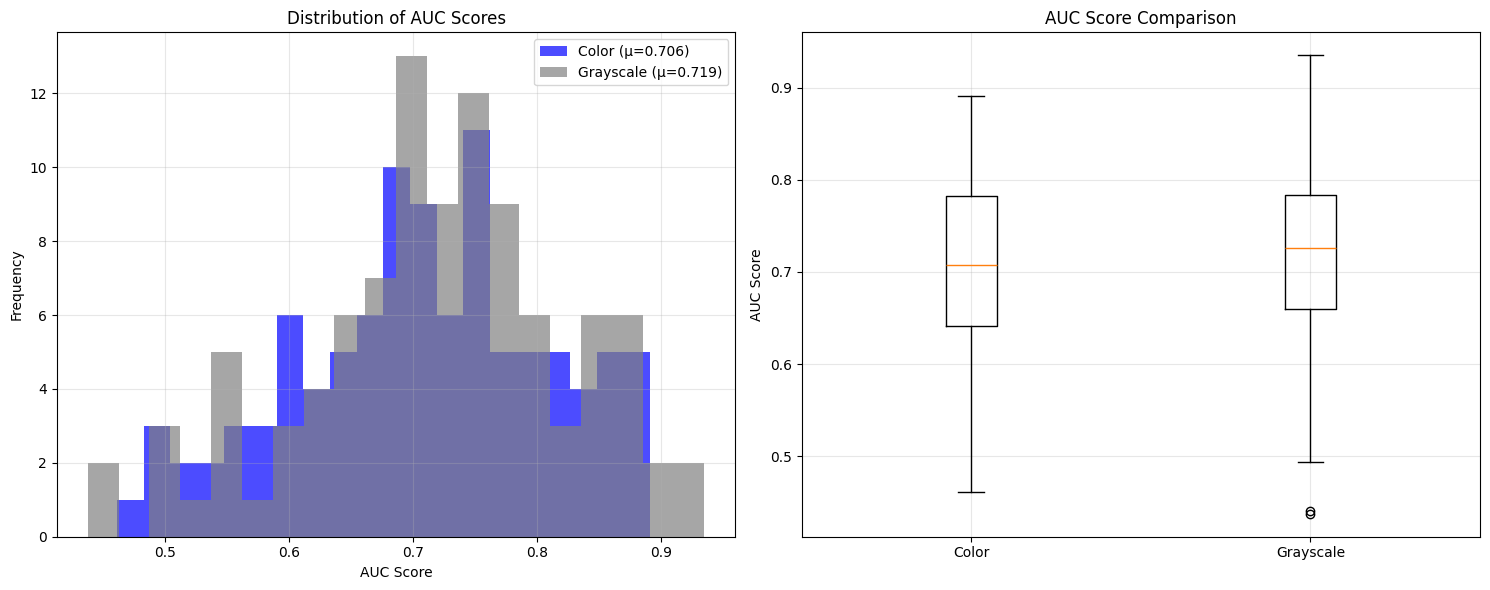


FINAL RESULTS SUMMARY
Color Spectrograms:     AUC = 0.7061 ± 0.1027
Grayscale Spectrograms: AUC = 0.7186 ± 0.1061


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class SpectrogramDataset(Dataset):
    """Custom dataset for loading spectrogram images"""

    def __init__(self, data_dir, color_type='color', transform=None):
        self.data_dir = Path(data_dir)
        self.color_type = color_type
        self.transform = transform
        self.samples = []

        hc_dir = self.data_dir / 'HC_AH' / color_type
        if hc_dir.exists():
            for img_path in hc_dir.glob('*.jpg'):
                self.samples.append((img_path, 0))

        pd_dir = self.data_dir / 'PD_AH' / color_type
        if pd_dir.exists():
            for img_path in pd_dir.glob('*.jpg'):
                self.samples.append((img_path, 1))

        print(f"Loaded {len(self.samples)} samples")
        print(f"HC samples: {sum(1 for _, label in self.samples if label == 0)}")
        print(f"PD samples: {sum(1 for _, label in self.samples if label == 1)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class InceptionClassifier(nn.Module):
    """Modified Inception v3 for Parkinson's Disease classification"""

    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(InceptionClassifier, self).__init__()

        self.inception = models.inception_v3(pretrained=True)

        num_features = self.inception.fc.in_features
        self.inception.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        self._freeze_early_layers()

    def _freeze_early_layers(self):
        """Freeze early layers to use as feature extractor"""
        for param in self.inception.parameters():
            param.requires_grad = False

        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        features = self.inception(x)

        if isinstance(features, tuple):
            features = features[0]

        output = self.classifier(features)
        return output

def get_transforms():
    """Get data transforms for training and validation"""

    train_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    """Training function"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_outputs = []
        all_targets = []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

                all_outputs.extend(torch.softmax(output, dim=1)[:, 1].cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        val_auc = roc_auc_score(all_targets, all_outputs)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}')
        print('-' * 60)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_auc': val_auc
    }

def evaluate_model(model, test_loader, device='cuda'):
    """Comprehensive model evaluation"""

    model.eval()
    all_outputs = []
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data)

            probabilities = torch.softmax(output, dim=1)
            _, predicted = torch.max(output.data, 1)

            all_outputs.extend(probabilities[:, 1].cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    auc = roc_auc_score(all_targets, all_outputs)
    accuracy = sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)

    cm = confusion_matrix(all_targets, all_predictions)
    report = classification_report(all_targets, all_predictions,
                                 target_names=['HC', 'PD'], output_dict=True)

    return {
        'auc': auc,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'probabilities': all_outputs,
        'targets': all_targets
    }

def run_cross_validation(data_dir, num_runs=100, color_type='color'):
    """Run multiple train/test splits as described in the paper"""

    print(f"Running cross-validation on {color_type} spectrograms...")
    print(f"Data path: {data_dir}")

    train_transform, val_transform = get_transforms()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    all_aucs = []

    for run in range(num_runs):
        print(f"\n{'='*20} Run {run+1}/{num_runs} {'='*20}")

        dataset = SpectrogramDataset(data_dir, color_type=color_type, transform=train_transform)

        if len(dataset) == 0:
            print(f"Error: No samples found in {data_dir}")
            print("Please check your directory structure:")
            print(f"Expected: {data_dir}/HC_AH/{color_type}/*.jpg")
            print(f"Expected: {data_dir}/PD_AH/{color_type}/*.jpg")
            return [], 0, 0

        total_size = len(dataset)
        train_size = int(0.7 * total_size)
        test_size = total_size - train_size

        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        train_dataset.dataset.transform = train_transform
        test_dataset.dataset.transform = val_transform

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

        model = InceptionClassifier(num_classes=2, dropout_rate=0.5)

        training_history = train_model(model, train_loader, test_loader,
                                     num_epochs=10, device=device)

        test_results = evaluate_model(model, test_loader, device=device)

        all_aucs.append(test_results['auc'])

        print(f"Run {run+1} - Test AUC: {test_results['auc']:.4f}")

        checkpoint_path = f"model_checkpoint_run_{run+1}_{color_type}.h5"
        torch.save({
            'model_state_dict': model.state_dict(),
            'auc': test_results['auc'],
            'run': run+1
        }, checkpoint_path)

    mean_auc = np.mean(all_aucs)
    std_auc = np.std(all_aucs)

    print(f"Cross-validation Results ({color_type} spectrograms):")
    print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"Min AUC: {np.min(all_aucs):.4f}")
    print(f"Max AUC: {np.max(all_aucs):.4f}")

    results_df = pd.DataFrame({
        'Run': range(1, num_runs + 1),
        'AUC': all_aucs
    })
    results_df.to_excel(f'cross_validation_results_{color_type}.xlsx', index=False)

    return all_aucs, mean_auc, std_auc

def plot_results(color_aucs, gray_aucs):
    """Plot comparison of results"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.hist(color_aucs, bins=20, alpha=0.7, label=f'Color (μ={np.mean(color_aucs):.3f})', color='blue')
    ax1.hist(gray_aucs, bins=20, alpha=0.7, label=f'Grayscale (μ={np.mean(gray_aucs):.3f})', color='gray')
    ax1.set_xlabel('AUC Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of AUC Scores')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.boxplot([color_aucs, gray_aucs], labels=['Color', 'Grayscale'])
    ax2.set_ylabel('AUC Score')
    ax2.set_title('AUC Score Comparison')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cross_validation_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    data_dir = "/content/drive/MyDrive/prior dataset/spectrograms_output/"

    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    color_aucs, color_mean, color_std = run_cross_validation(
        data_dir, num_runs=100, color_type='color'
    )

    gray_aucs, gray_mean, gray_std = run_cross_validation(
        data_dir, num_runs=100, color_type='gray'
    )

    plot_results(color_aucs, gray_aucs)

    print("FINAL RESULTS SUMMARY")
    print(f"Color Spectrograms:     AUC = {color_mean:.4f} ± {color_std:.4f}")
    print(f"Grayscale Spectrograms: AUC = {gray_mean:.4f} ± {gray_std:.4f}")